<a href="https://colab.research.google.com/github/gulnuravci/reddit_sentiment_analysis/blob/main/reddit_sentiment_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction

I want to build a tool that gives a daily rundown of reddit user's sentiment on the "Magnificent Seven" - Apple, Microsoft, Alphabet, Amazon, Nvidia, Tesla, and Meta.

I am doing this as a proof of concept.

# Set up

## Installs

In [1]:
pip install asyncpraw

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.7/196.7 kB 3.0 MB/s eta 0:00:00


In [2]:
pip install transformers datasets evaluate accelerate

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.0/542.0 kB 7.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 6.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.4/302.4 kB 11.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 5.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 5.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 8.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 401.2/401.2 kB 12.8 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (41

In [ ]:
pip install transformers[torch] accelerate -U

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.0/9.0 MB 37.3 MB/s eta 0:00:00
  Attempting uninstall: transformers
    Found existing installation: transformers 4.40.1
    Uninstalling transformers-4.40.1:
      Successfully uninstalled transformers-4.40.1


In [3]:
pip install huggingface_hub

In [ ]:
pip install schedule

In [4]:
try:
  import gradio as gr
except:
  !pip -q install gradio
  import gradio as gr

print(f"Gradio version: {gr.__version__}")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.3/12.3 MB 51.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.0/92.0 kB 10.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 314.6/314.6 kB 21.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 5.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 142.5/142.5 kB 9.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.7/8.7 MB 38.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.2/47.2 kB 3.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.8/60.8 kB 5.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.9/129.9 kB 11.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 7.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 3.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.9/71.9 kB 7.7 MB/s et

## Imports

In [135]:
import asyncpraw
import asyncio
import pandas as pd
import tqdm
import re
import csv
import matplotlib.pyplot as plt
import numpy as np
import evaluate
import requests
import asyncprawcore
import schedule
import time
import pytz
import shutil

from pathlib import Path
from google.colab import drive
from typing import List, Dict, Any
from google.colab import userdata
from collections import defaultdict
from asyncpraw.models import MoreComments, Submission
from transformers import AutoTokenizer, AutoModelForSequenceClassification, DataCollatorWithPadding, TrainingArguments, Trainer, pipeline
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from huggingface_hub import InferenceClient, notebook_login
from datetime import datetime

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

ModuleNotFoundError: No module named 'schedule'

## Access reddit

In [ ]:
def get_access_to_reddit(user_agent="financial sentiment analysis project (research phase) (by u/ditalinianalysis)"):
  reddit = asyncpraw.Reddit(
      client_id=userdata.get("client_id"),
      client_secret=userdata.get('secret'),
      user_agent=user_agent
      )
  return reddit

# Extracting data

What are some ways to get data on what we are looking for?
- Look at a list of subs
- Search for posts that include a list of keywords

What is a reliable way to relate comments to each other and the post? Is it sufficient to make them a single string?

## Exploring reddit.subreddits

In [ ]:
async def search_subreddits_by_name(search_string: str,
                                    include_nsfw: bool,
                                    exact: bool) -> List[asyncpraw.models.Subreddit]:
  """
  async for ... in search_by_name(query: str, *, include_nsfw: bool = True, exact: bool = False) → List[asyncpraw.models.Subreddit]

  Return list of Subreddits whose names begin with query.

  Parameters:
  query – Search for subreddits beginning with this string.
  exact – Return only exact matches to query (default: False).
  include_nsfw – Include subreddits labeled NSFW (default: True).
  """
  subs = []
  async for subreddit in reddit.subreddits.search_by_name(search_string, include_nsfw=include_nsfw, exact=exact):
    subs.append(subreddit)
  return subs

In [ ]:
async def search_subreddits_by_keyword_in_name_or_description(search_string: str) -> List[asyncpraw.models.Subreddit]:
  """
  search(query: str, **generator_kwargs: str | int | Dict[str, str])→ AsyncIterator[asyncpraw.models.Subreddit]

  Return a ListingGenerator of subreddits matching query. Additional keyword arguments are passed in the initialization of ListingGenerator.

  Subreddits are searched by both their title and description.

  Parameters:
  query – The query string to filter subreddits by.
  """
  subs = []
  async for subreddit in reddit.subreddits.search(search_string):
    subs.append(subreddit)
  return subs

In [ ]:
async def filter_subreddits_by_keywords(subreddits: List[asyncpraw.models.Subreddit], keywords: List[str], min_keyword_count: int = 2) -> List[asyncpraw.models.Subreddit]:
  filtered_subreddits = []

  for subreddit in subreddits:
      title = subreddit.title.lower()
      description = subreddit.description.lower() if subreddit.description else ""


      # Check if the subreddit contains a minimum number of keywords
      keyword_count = sum(keyword.lower() in title or keyword.lower() in description for keyword in keywords)
      if keyword_count >= min_keyword_count:
          filtered_subreddits.append(subreddit)

  return filtered_subreddits

In [ ]:
def get_subreddits_name_title_description(subreddits: List[asyncpraw.models.Subreddit]) -> Dict[asyncpraw.models.Subreddit,str]:
  subreddit_name_title_descriptions = {}
  for subreddit in subreddits:
    name = subreddit.display_name
    title = subreddit.title
    description = subreddit.description if subreddit.description else ""
    text = "Name:" + name + "\nTitle: " + title + "\nDescription: " + description
    subreddit_name_title_descriptions[subreddit] = text[:512]
  return subreddit_name_title_descriptions

## Exploring reddit.front

"Sorting by "new" will frequently update to show you new posts. Sorting by "Hot" and "Best" are similar, but sorting by "Hot" should surface fresher posts as it is related to upvotes + time. Sorting by "Top" will surface posts with the highest vote counts within the selected time frame."

In [ ]:
async def front_best_posts() -> List[asyncpraw.models.Submission]:
  """
  best(**generator_kwargs: str | int)→ AsyncIterator[asyncpraw.models.Submission]

  Return a ListingGenerator for best items. Additional keyword arguments are passed in the initialization of ListingGenerator.
  """
  posts = []
  async for post in reddit.front.best():
    posts.append(post)
  return posts

In [ ]:
async def front_hot_posts(time_filter: str = "day") -> List[asyncpraw.models.Submission]:
  """
  hot(**generator_kwargs: str | int | Dict[str, str])→ AsyncIterator[Any]

  Return a ListingGenerator for hot items.

  Additional keyword arguments are passed in the initialization of ListingGenerator.
  """
  posts = []
  async for post in reddit.front.hot():
    posts.append(post)
  return posts


## Useful functions

In [ ]:
def get_submission_information(submission: asyncpraw.models.Submission) -> Dict[str, Any]:
  """
  Submission class: https://asyncpraw.readthedocs.io/en/stable/code_overview/models/submission.html#asyncpraw.models.Submission
  """
  return vars(submission)

In [ ]:
 async def probe_subs_for_posts(subs: List[str],
                                num_posts: int,
                                time_filter: str = "day"):
  """
  Iterate through selected subreddits, retrieve a specified number of top posts from each subreddit,
  sort the comments for each post and pick the top few comments along with some of its replies,
  and store the posts.

  Args:
      subs (List[str]): A list of subreddit names to probe for posts.
      num_posts (int): The number of top posts to retrieve from each subreddit.
      time_filter (str, optional): The time period to filter posts by. Default is "day".
          Possible values: "all", "day", "hour", "month", "week", "year".

  Returns:
      defaultdict: A defaultdict where keys are subreddit names and values are lists of
      top posts retrieved from each subreddit.
  """
  # key -> subreddit, value -> list of posts
  posts = defaultdict(list)
  failed_subreddits = []
  # for each subreddit
  for sub in subs:
    try:
      async for submission in sub.top(limit=num_posts, time_filter=time_filter):
        posts[sub].append(submission)
    except Exception as e:
      print(f"Error processing posts from subreddit {sub.display_name}")
      failed_subreddits.append(sub.display_name)
  return posts, failed_subreddits

In [ ]:
async def probe_submissions_for_comments(submission: asyncpraw.models.Submission,
                                         num_comments: int,
                                         sort_type: str) -> List[asyncpraw.models.Comment]:
  """
  Retrieve comments from a Reddit submission and return a list of comments.

  Args:
      submission (asyncpraw.models.Submission): The Reddit submission object.
      num_comments (int): The number of comments to retrieve.
      sort_type (str): The sorting type for comments.
          Possible values: 'confidence', 'top', 'new', 'controversial', 'old', 'random', 'qa'.

  Returns:
      List[asyncpraw.models.Comment]: A list of comment objects retrieved from the submission.

  Note:
      - This function sorts the comments based on the specified sort_type.
      - If there are 'MoreComments' objects encountered, they are skipped.
  """
  comments_list = []
  submission.comment_sort = sort_type
  submission.comment_limit = num_comments
  await submission.load()

  comments = await submission.comments()
  comments.replace_more(limit=None)
  all_comments = comments.list()
  for comment in all_comments:
    if isinstance(comment, MoreComments):
      continue
    comments_list.append(comment)
  return comments_list

In [ ]:
from collections import defaultdict

def default_dict_list():
  return defaultdict(list)

def default_dict_dict_list():
  return defaultdict(default_dict_list)

def default_dict_dict_dict_list():
  return defaultdict(default_dict_dict_list)

In [ ]:
def create_experiment_file(filename, header):
  timestamp = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
  with open(filename, 'a') as file:
      file.write(header + "\n")
      file.write(f"{timestamp}\n")
      file.write("----------------------------\n")

def add_to_experiment_file(filename, data):
    with open(filename, 'a') as file:
        file.write(f"{data}\n")

In [ ]:
def write_subsidary_parent_company_csv(subsidiaries:List[List[str]], csv_filename):
  with open(csv_filename, 'w', newline='') as csv_file:
    writer = csv.writer(csv_file)
    writer.writerow(["Subsidiary", "Parent Company"])
    for subsidiary in subsidiaries:
      writer.writerow(subsidiary)

def write_parent_company_keywords_csv(keywords:Dict[str, List[str]], csv_filename):
    with open(csv_filename, 'w', newline='') as csv_file:
        writer = csv.writer(csv_file)
        writer.writerow(["Parent Company", "Keywords"])
        for parent_company, keywords_list in keywords.items():
            keywords_string = ', '.join(keywords_list)
            writer.writerow([parent_company, keywords_string])

def read_subsidary_parent_company_csv(csv_filename: str) -> List[List[str]]:
    subsidiaries = []
    with open(csv_filename, newline='') as csv_file:
        reader = csv.reader(csv_file)
        next(reader)  # Skip header row
        for row in reader:
            subsidiaries.append(row)
    return subsidiaries

def read_parent_company_keywords_csv(csv_filename: str) -> Dict[str, List[str]]:
    keywords = {}
    with open(csv_filename, newline='') as csv_file:
        reader = csv.reader(csv_file)
        next(reader)  # Skip header row
        for row in reader:
            parent_company, *keyword_list = row
            keywords[parent_company] = keyword_list
    return keywords

In [ ]:
def plot_results_one_image(results):
  fig, axs = plt.subplots(3, 2, figsize=(12, 10))

  color_map = {
      'Apple': 'lightgray',
      'Microsoft': 'deepskyblue',
      'Alphabet': 'yellow',
      'Amazon': 'orange',
      'Nvidia': 'limegreen',
      'Tesla': 'red',
      'Meta': 'royalblue'
  }

  parent_companies = list(results['Num subreddits that were included per parent company'].keys())

  for company, num_subs in results["Num subreddits that were included per parent company"].items():
    axs[0, 0].barh(company, num_subs, color=color_map.get(company, 'gray'))
  axs[0, 0].set_title('Number of Subreddits per Parent Company')
  axs[0, 0].set_xlabel('Number of Technology Related Subreddits')

  for company, num_posts in results["Num of posts extracted for each parent company"].items():
    axs[0, 1].barh(company, num_posts, color=color_map.get(company, 'gray'))
  axs[0, 1].set_title('Number of Posts Extracted per Parent Company')
  axs[0, 1].set_xlabel('Number of Posts')

  for company, num_comments in results["Num of comments extracted for each parent company"].items():
    axs[1, 0].barh(company, num_comments, color=color_map.get(company, 'gray'))
  axs[1, 0].set_title('Number of Comments Extracted per Parent Company')
  axs[1, 0].set_xlabel('Number of Comments')

  for company, num_interactions in results["Num of interactions for each parent company"].items():
    axs[1, 1].barh(company, num_interactions, color=color_map.get(company, 'gray'))
  axs[1, 1].set_title('Number of Interactions per Parent Company')
  axs[1, 1].set_xlabel('Number of Interactions')

  for company, num_interactions in results["Average sentiment for each parent company"].items():
    axs[2, 0].barh(company, num_interactions, color=color_map.get(company, 'gray'))
  axs[2, 0].set_title('Average Sentiment per Parent Company')
  axs[2,0].set_xlabel('Average Sentiment')
  axs[2,0].set_xlim(-1, 1)  # Set the x-axis limits to range from -1 to 1

  bar_width = 0.25
  index = np.arange(7)

  companies = list(results["Num of positive sentiments for each parent company"].keys())
  positive_sentiments = [results["Num of positive sentiments for each parent company"][company] for company in companies]
  negative_sentiments = [results["Num of negative sentiments for each parent company"][company] for company in companies]
  neutral_sentiments = [results["Num of neutral sentiments for each parent company"][company] for company in companies]

  axs[2, 1].bar(index, positive_sentiments, bar_width, label='Positive Sentiments', color='skyblue')
  axs[2, 1].bar(index + bar_width, negative_sentiments, bar_width, label='Negative Sentiments', color='salmon')
  axs[2, 1].bar(index + 2 * bar_width, neutral_sentiments, bar_width, label='Neutral Sentiments', color='lightgreen')

  axs[2, 1].set_ylabel('Number of Sentiments')
  axs[2, 1].set_title('Sentiment Distribution for Each Parent Company')
  axs[2, 1].set_xticks(index + bar_width)
  axs[2, 1].set_xticklabels(companies, rotation=45)
  axs[2, 1].legend()

  plt.tight_layout()

  plt.savefig("results.png")

  return ["results.png"]

  # plt.show()

# Models

## Topic Classifier (Subreddit Descriptions)

1. Need a topic classifier fine-tuned on subreddit descriptions to distinguish if that subreddit has to do with specific technology companies/stocks.

2. Need a topic classifier that will classify if a submission is technology related.

### Clean Text

In [ ]:
def clean_text(raw_text):
    # Remove newline characters
    cleaned_text = raw_text.replace('\n', ' ')

    # Remove URLs
    cleaned_text = re.sub(r'http\S+', '', cleaned_text)

    # Remove special characters and multiple spaces
    cleaned_text = re.sub(r'[^a-zA-Z0-9\s]', '', cleaned_text)
    cleaned_text = re.sub(r'\s+', ' ', cleaned_text).strip()

    return cleaned_text

### Data Collection

Get subreddit title and descriptions based on keywords. Will manually label whether it is technology related or not in a google sheets.

In [ ]:
reddit = get_access_to_reddit()

In [ ]:
technology_keywords = ["Tesla", "Meta"]

In [ ]:
all_subreddits = []
for keyword in technology_keywords:
  curr_keyword_subreddits = await search_subreddits_by_keyword_in_name_or_title(keyword)
  for subreddit in curr_keyword_subreddits:
    name = subreddit.display_name
    title = subreddit.title
    description = clean_text(subreddit.description) if subreddit.description else ""
    all_subreddits.append("Name:" + name + "\nTitle:" + title + "\nDescription:" + description)

In [ ]:
def create_or_append_csv(csv_file_path, data, append=False):
  path = Path(csv_file_path)

  # If append is True and and file path doesn't exist, end function
  if append and not path.exists():
    print("Asked to append and", path, "path does not exist.")
    return

  # Open the CSV file in append mode if specified
  mode = 'a' if append else 'w'

  with open(path, mode, newline='', encoding='utf-8') as file:
    writer = csv.writer(file)

    # Write the header only if the file is newly created or not in append mode
    if not append:
        writer.writerow(["Text"])

    writer.writerows(map(lambda x: [x], data))

  if append:
      print(f"Data appended to existing CSV file '{path}'.")
  else:
      print(f"New CSV file '{path}' created successfully.")

In [ ]:
create_or_append_csv(csv_file_path="tesla_meta_unlabeled_dataset", data=all_subreddits, append=False)

New CSV file 'nvidia_unlabeled_dataset' created successfully.


In [ ]:
len(all_subreddits)

200

### Import labeled data and create training and test split

Import csv data from github, which is a single csv of labeled subreddit descriptions.

In [ ]:
!git clone https://github.com/gulnuravci/financial_sentiment_analysis
!cp financial_sentiment_analysis/technology_topic_classification_dataset.csv .

Cloning into 'financial_sentiment_analysis'...
remote: Enumerating objects: 6, done.
remote: Counting objects: 100% (6/6), done.
remote: Compressing objects: 100% (4/4), done.
remote: Total 6 (delta 0), reused 0 (delta 0), pack-reused 0
Receiving objects: 100% (6/6), 334.66 KiB | 2.57 MiB/s, done.


Remove duplicates and plot what the [not] technology related subreddits.

Number of duplicates dropped: 122
Number of not technology related subreddits: 582
Number of technology related subreddits: 501


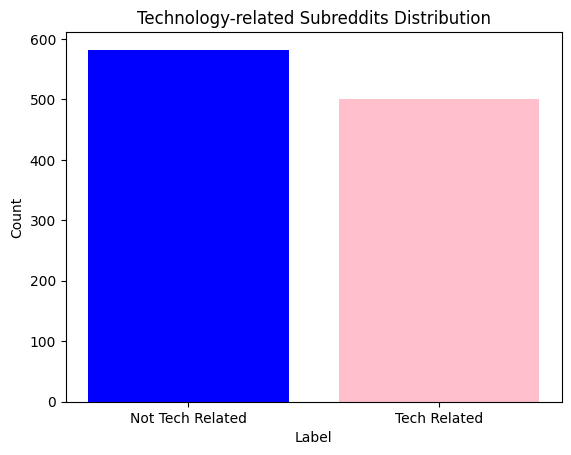

In [ ]:
def remove_duplicates_and_print(data_frame):
    # Drop duplicates based on the 'Text' column
    unique_df = data_frame.drop_duplicates(subset='Text', keep='first')

    print(f"Number of duplicates dropped: {len(data_frame) - len(unique_df)}")

    return unique_df

csv_file_path = 'financial_sentiment_analysis/technology_topic_classification_dataset.csv'

df = pd.read_csv(csv_file_path)

unique_df = remove_duplicates_and_print(df)

count_0 = df['Label'].value_counts().get(0)
count_1 = df['Label'].value_counts().get(1)

print(f"Number of not technology related subreddits: {count_0}")
print(f"Number of technology related subreddits: {count_1}")

labels = ['Not Tech Related', 'Tech Related']
counts = [count_0, count_1]

plt.bar(labels, counts, color=['blue', 'pink'])
plt.xlabel('Label')
plt.ylabel('Count')
plt.title('Technology-related Subreddits Distribution')
plt.show()

Create train and test splits with the processed subreddit data.

In [ ]:
# Split the DataFrame into training and testing sets
train_df, test_df = train_test_split(unique_df, test_size=0.2, random_state=42)

# Specify file paths for the train and test CSV files
train_csv_file_path = 'financial_sentiment_analysis/train_dataset.csv'
test_csv_file_path = 'financial_sentiment_analysis/test_dataset.csv'

# Save the training and testing sets to CSV files
train_df.to_csv(train_csv_file_path, index=False)
test_df.to_csv(test_csv_file_path, index=False)

# Print information about the split
print(f"Number of rows in the training set: {len(train_df)}")
print(f"Number of rows in the testing set: {len(test_df)}")

Number of rows in the training set: 770
Number of rows in the testing set: 193


I downloaded these two csv files and uploaded them to Hugging Face as a dataset.

### Hugging Face login (read)

In [ ]:
notebook_login()

### Import Hugging Face subreddit database

In [ ]:
from datasets import load_dataset
dataset = load_dataset("gulnuravci/subreddit_title_description_technology_classification")
dataset = dataset.rename_column("Label", "labels")
dataset = dataset.rename_column("Text", "text")
dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'labels'],
        num_rows: 770
    })
    test: Dataset({
        features: ['text', 'labels'],
        num_rows: 193
    })
})

In [ ]:
dataset["train"], dataset["test"]

(Dataset({
     features: ['text', 'labels'],
     num_rows: 770
 }),
 Dataset({
     features: ['text', 'labels'],
     num_rows: 193
 }))

### Preprocess

Following a similar flow of this topic classification tutorial on Hugging Face: https://huggingface.co/docs/transformers/en/tasks/sequence_classification

In [ ]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")

In [ ]:
def preprocess_function(data):
  """
  Create a preprocessing function to tokenize text and truncate sequences to be
  no longer than DistilBERT’s maximum input length.
  """
  return tokenizer(data["text"], truncation=True)

In [ ]:
tokenized_dataset = dataset.map(preprocess_function, batched=True)

Map:   0%|          | 0/770 [00:00<?, ? examples/s]

Map:   0%|          | 0/193 [00:00<?, ? examples/s]

DataCollatorWithPadding: https://huggingface.co/docs/transformers/v4.38.2/en/main_classes/data_collator#transformers.DataCollatorWithPadding

In [ ]:
# Data collator that will dynamically pad the inputs received.
# It’s more efficient to dynamically pad the sentences to the longest length in a batch during collation,
# instead of padding the whole dataset to the maximum length.
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

### Evaluate

Accuracy metric: https://huggingface.co/spaces/evaluate-metric/accuracy

In [ ]:
accuracy = evaluate.load("accuracy")

In [ ]:
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return accuracy.compute(predictions=predictions, references=labels)

### Hugging Face login (write)

In [ ]:
notebook_login()

### Train

In [ ]:
id2label = {0: "NOT TECHNOLOGY RELATED", 1: "TECHNOLOGY RELATED"}
label2id = {"NOT TECHNOLOGY RELATED": 0, "TECHNOLOGY RELATED": 1}

In [ ]:
model = AutoModelForSequenceClassification.from_pretrained(
    "distilbert-base-uncased", num_labels=2, id2label=id2label, label2id=label2id
)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
 training_args = TrainingArguments(
    output_dir="gulnuravci/subreddit_description_topic_classifier",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=2,
    weight_decay=0.01,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    push_to_hub=True,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["test"],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.418108,0.823834
2,No log,0.391512,0.829016


TrainOutput(global_step=98, training_loss=0.42222871585768096, metrics={'train_runtime': 4970.2163, 'train_samples_per_second': 0.31, 'train_steps_per_second': 0.02, 'total_flos': 190340645796168.0, 'train_loss': 0.42222871585768096, 'epoch': 2.0})

In [ ]:
trainer.push_to_hub()

CommitInfo(commit_url='https://huggingface.co/gulnuravci/subreddit_description_topic_classifier/commit/392aa0fc9e495b5ee4bb97a8c5e029255a8fc561', commit_message='End of training', commit_description='', oid='392aa0fc9e495b5ee4bb97a8c5e029255a8fc561', pr_url=None, pr_revision=None, pr_num=None)

# Main

In [ ]:
reddit = get_access_to_reddit()

In [ ]:
# the first value is the name of the subsidiary
# the second value is the parent company
magnificent_seven = [["Apple", "Apple"],
                     ["Microsoft", "Microsoft"],
                     ["Alphabet", "Alphabet"],
                     ["Google", "Alphabet"],
                     ["YouTube", "Alphabet"],
                     ["Waze", "Alphabet"],
                     ["Amazon", "Amazon"],
                     ["Nvidia", "Nvidia"],
                     ["Tesla", "Tesla"],
                     ["Facebook", "Meta"],
                     ["Instagram", "Meta"],
                     ["WhatsApp", "Meta"],
                     ["Oculus", "Meta"]]

In [ ]:
create_experiment_file("extracting_data_notes", "Extracting Data Notes")

In [ ]:
add_to_experiment_file("extracting_data_notes", "magnificent_seven = " + str(magnificent_seven))

## Subreddit filtering based on company keywords

Let's try to get subreddits like this. I will search for subreddits with a single keyword that will be the company name. I will do additional searches for specific keywords included in the title and description of each subreddit to decide if I should include it or not. Finally, I will run each of the remaining subreddits through a topic classifier to make sure it is infact a technology related company.

In [ ]:
apple_keywords = ["Apple", "MacBook Air", "MacBook Pro", "iMac", "Mac mini", "Mac Studio", "Mac Pro",
                  "iPad Pro", "iPad Air", "iPad", "iPad mini", "Apple Pencil",
                  "iPhone 15", "iPhone 14", "iPhone 13", "iPhone SE",
                  "Apple Watch Series 9", "Apple Watch Ultra 2", "Apple Watch SE", "Apple Watch Nike", "Apple Watch Hérmes",
                  "Apple Vision Pro",
                  "AirPods Pro", "AirPods Max",
                  "Apple TV", "HomePod",
                  "Apple One", "Apple TV+", "Apple Music", "Apple Arcade", "Apple Fitness+", "Apple News+", "Apple Podcasts", "Apple Books", "App Store",
                  "AppleCare+", "iCloud", "iTunes", "Siri",
                  "iOS", "iPadOS", "macOS", "tvOS", "visionOS", "watchOS",
                  "Swift", "SwiftUI", "SwiftPlaygrounds", "TestFlight", "Xcode", "Xcode Cloud", "SF Symbols",
                  "AAPL"]

microsoft_keywords = ["Microsoft",
                      "Access", "Accessibility", "Account",
                      "Clipchamp", "Cortana",
                      "Defender", "Delve",
                      "Education", "Excel",
                      "Family", "Forms",
                      "Internet Explorer",
                      "Microsoft 365", "Microsoft Office", "Microsoft Advertising", "Microsoft Copilot", "Microsoft Edge", "Microsoft Lens", "Microsoft Lists",
                      "Microsoft Loop", "Microsoft Start", "Microsoft Store", "Microsoft Stream", "Microsoft Syntex", "Microsoft Teams", "Microsoft Viva",
                      "Microsoft Azure", "Microsoft SQL Server"
                      "OneDrive", "OneNote", "Outlook",
                      "Phone Link", "Planner", "PowerPoint", "Project", "Publisher",
                      "Security", "SharePoint", "Skype", "Surface", "Sway", "SwiftKey",
                      "To Do",
                      "Visio",
                      "Whiteboard", "Windows", "Word",
                      "Xbox",
                      "Yammer",
                      "Surface", "Surface Pro", "Surface Go 3", "Surface Laptop",
                      "Visual Studio",
                      "Hololens"
                      "MSFT"]

alphabet_keywords = ["Google", "Android", "Android Auto", "Android TV", "Calendar", "Chrome", "Chromebook", "Chromecast", "Contacts", "Docs", "Drawings", "Drive",
                     "Earth", "Family Link", "Finance", "Forms", "Gemini", "Gmail", "Google Assistant", "Google Chat", "Google Classroom", "Google Fit",
                     "Google Flights", "Google Groups", "Google Home", "Google Maps", "Google Meet", "Google One", "Google Pay", "Google Photos", "Google Play",
                     "Google Store", "Google Shopping", "Google TV", "Google Wallet", "Google Workspace", "Google Ads", "Google Analytics", "AdWords", "Lens",
                     "Nest", "News", "Pixel", "Pixel Buds", "Pixelbook Go", "Scholar", "Search", "Sheets", "Sites", "Slides", "Translate", "Travel", "Waze",
                     "YouTube", "YouTube Kids", "YouTube Music", "YouTube TV",
                     "GOOG"]

amazon_keywords = ["Amazon", "Amazon Web Services", "AWS", "Prime", "Music", "Alexa", "Echo", "Amazon Drive", "Kindle", "Fresh", "FireTV", "Whole Foods",
                   "Amazon Go", "Ring", "Jeff Bezos", "AMZN"]

nvidia_keywords = ["Data Center GPUs", "DGX", "EGX", "HGX", "Grace CPU", "Grace Hopper", "BlueField DPU", "SuperNICs", "OVS", "AI Enterprise", "NGC",
                   "Virtual GPU", "vGPU", "H200", "H100", "L4", "L40S", "L40", "A100", "A2", "A10", "A16", "A30", "A40", "Base Command", "CUDA-X",
                   "Fleet Command", "Hopper", "Ada Lovelace", "Ampere", "NVLink-C2C", "NVLink", "NVSwitch", "Tensor Cores", "Morpheus",
                   "Accelerated Computing", "Cloud Computing", "Colocation", "Edge Computing", "High Performance Computing", "Networking", "Virtualization",
                   "MLOps", "Chips", "AI", "CUDA", "GPU", "GeForce", "RTX", "Ray Tracing", "G-Sync",
                   "NVDA"]

tesla_keywords = ["Tesla", "Model S", "Model 3", "Model X", "Model Y", "Cybertruck", "Solar Panels", "Solar Roof", "Powerwall", "Megapack", "Charging",
                  "Home Charging", "Supercharging", "Supercharger", "PyTorch", "Self-Driving", "Elon Musk", "Autopilot", "EV", "Electric Vehicle", "Battery Energy",
                  "TSLA"]

meta_keywords = ["Facebook", "Instagram", "WhatsApp", "Oculus", "Meta", "Mark Zuckerberg", "Meta Quest", "Reality Labs", "Horizon Workrooms", "MetaVerse",
                 "META"]

In [ ]:
magnificent_seven_keywords = {"Apple": apple_keywords,
                              "Microsoft": microsoft_keywords,
                              "Alphabet": alphabet_keywords,
                              "Amazon": amazon_keywords,
                              "Nvidia": nvidia_keywords,
                              "Tesla": tesla_keywords,
                              "Meta": meta_keywords}

In [ ]:
add_to_experiment_file("extracting_data_notes", "")
add_to_experiment_file("extracting_data_notes", "Keywords:")
for company_name, keywords in magnificent_seven_keywords.items():
  add_to_experiment_file("extracting_data_notes", company_name + " = " + str(keywords))

In [ ]:
# create a dictionary that will store the company as the key and associated subreddit as a list of values
subreddits_to_include = {}
# count how many subreddits were originally extracted
all_sub_count = 0
# for each index, company name of the seven companies
for i, subsidiary_company in enumerate(magnificent_seven):
  # get all the subreddits that have that company name in the title or description
  all_subreddits_for_company = await search_subreddits_by_keyword_in_name_or_description(subsidiary_company[0])
  # increment total subreddit count by how many subreddits were extracted
  all_sub_count += len(all_subreddits_for_company)
  # further filter these subreddits based on how many keywords associated with the current company they contain
  filtered_subreddits = await filter_subreddits_by_keywords(subreddits=all_subreddits_for_company,
                                                            keywords=magnificent_seven_keywords[subsidiary_company[1]],
                                                            min_keyword_count=1)
  # set the list of filtered company subreddits to the dictionary
  subreddits_to_include[subsidiary_company[1]] = filtered_subreddits

print("Num subreddits without keywords filter:", all_sub_count)
print("Num subreddits with keywords filter:", sum([len(company_subreddits) for company_subreddits in subreddits_to_include.values()]))

Num subreddits without keywords filter: 1253
Num subreddits with keywords filter: 536


In [ ]:
add_to_experiment_file("extracting_data_notes", "")
add_to_experiment_file("extracting_data_notes", "Num subreddits without keywords filter: 1253")
add_to_experiment_file("extracting_data_notes", "Num subreddits with keywords filter: 536")

As can be seen above, filtering the subreddits based on keywords contained in its title and description narrows down the subreddits under consideration. This makes running the topic classification model to determine if the subreddit is technology related quicker.


## Subreddit filtering based on subreddit binary topic classifier

In [ ]:
subreddit = await reddit.subreddit("AppleM1", fetch=True)
name = subreddit.display_name
title = subreddit.title
description = subreddit.description if subreddit.description else ""
text = "Name:" + name + "\nTitle: " + title + "\nDescription: " + description
text

'Name:AppleM1\nTitle: AppleM1\nDescription: This subreddit is dedicated to the M1, the first Apple Silicon chip for the Mac.'

In [ ]:
topic_classifier_client = InferenceClient(model="gulnuravci/subreddit_description_topic_classifier", token=userdata.get('HF_TOKEN_READ'))

In [ ]:
output = topic_classifier_client.text_classification(text)
output

[{'label': 'TECHNOLOGY RELATED', 'score': 0.9390692710876465},
 {'label': 'NOT TECHNOLOGY RELATED', 'score': 0.06093068793416023}]

In [ ]:
def process_output(output):
  result_dict = {'TECHNOLOGY RELATED': 0.0, 'NOT TECHNOLOGY RELATED': 0.0}

  for prediction in output:
    label = prediction['label']
    score = prediction['score']

    if label == 'TECHNOLOGY RELATED':
        result_dict['TECHNOLOGY RELATED'] = score
    elif label == 'NOT TECHNOLOGY RELATED':
        result_dict['NOT TECHNOLOGY RELATED'] = score

  return result_dict

In [ ]:
process_output(output)

{'TECHNOLOGY RELATED': 0.9390692710876465,
 'NOT TECHNOLOGY RELATED': 0.06093068793416023}

In [ ]:
# dictionary where the key is the parent company name and the value is a list of subreddits
# that passed the topic classifier as being 'technology related'
subreddits_passed_topic_classifier = defaultdict(list)
total_companies_being_processed = 0
# for each company key in the subreddits to include (based on keyword filtering) dictionary
for company, subreddits_list in tqdm(subreddits_to_include.items()):
  # get a dictionary where the key is the subreddit object and value is text format of the company's name, title, and description
  name_title_descriptions = get_subreddits_name_title_description(subreddits_to_include[company])
  # for each subreddit under the current company
  for subreddit_object, subreddit_description in name_title_descriptions.items():
    # pass the subreddit's description through the subreddit topic classifier
    output = topic_classifier_client.text_classification(subreddit_description)

    # process output
    output = process_output(output)

    # if technology related
    if output['TECHNOLOGY RELATED'] > output['NOT TECHNOLOGY RELATED']:
      subreddits_passed_topic_classifier[company].append((subreddit_object, output['TECHNOLOGY RELATED'], output['NOT TECHNOLOGY RELATED']))

    total_companies_being_processed += 1

print("\nTotal subreddits that ran through the model: ", total_companies_being_processed)
print("Total subreddits that were marked with being technology related: ", sum([len(items) for items in subreddits_passed_topic_classifier.values()]))
subreddits_passed_topic_classifier

100%|██████████| 7/7 [00:39<00:00,  5.60s/it]

Total subreddits that ran through the model:  536
Total subreddits that were marked with being technology related:  408


defaultdict(list,
            {'Apple': [(Subreddit(display_name='apple'),
               0.9459022283554077,
               0.054097793996334076),
              (Subreddit(display_name='AppleWatch'),
               0.9440438151359558,
               0.055956169962882996),
              (Subreddit(display_name='AppleMusic'),
               0.9431213736534119,
               0.05687863379716873),
              (Subreddit(display_name='iphone'),
               0.9252777695655823,
               0.07472218573093414),
              (Subreddit(display_name='appletv'),
               0.949877142906189,
               0.05012287199497223),
              (Subreddit(display_name='AppleCard'),
               0.9370117783546448,
               0.06298822164535522),
              (Subreddit(display_name='technology'),
               0.8963473439216614,
               0.10365273058414459),
              (Subreddit(display_name='applehelp'),
               0.9459660053253174,
               0.054034

In [ ]:
add_to_experiment_file("extracting_data_notes", "")
add_to_experiment_file("extracting_data_notes", "Total subreddits that ran through the model:  536")
add_to_experiment_file("extracting_data_notes", "Total subreddits that were marked with being technology related:  408")

### Write/read csv functions for parent companies and their associated subreddit ids

In [ ]:
def write_subreddit_classification_data_to_csv(data: defaultdict, csv_filename: str) -> None:
    """
    Write subreddit classification data to a CSV file.

    Args:
        data (defaultdict): A defaultdict where keys are parent company names and values are lists of tuples
            containing subreddit display names, technology related scores, and not technology related scores.
        csv_filename (str): The filename for the CSV file to be created.

    Returns:
        None
    """
    with open(csv_filename, 'w', newline='') as csvfile:
        fieldnames = ['Parent Company', 'Display Name', 'TECHNOLOGY RELATED', 'NOT TECHNOLOGY RELATED']
        writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
        writer.writeheader()

        for parent_company, subreddits in data.items():
            for subreddit, tech_related, not_tech_related in subreddits:
                writer.writerow({
                    'Parent Company': parent_company,
                    'Display Name': subreddit.display_name,
                    'TECHNOLOGY RELATED': tech_related,
                    'NOT TECHNOLOGY RELATED': not_tech_related
                })

async def read_subreddit_classification_data_from_csv(csv_filename: str) -> defaultdict:
  """
  Read subreddit classification data from a CSV file and return it in the original format.

  Args:
      csv_filename (str): The filename of the CSV file to read.
      reddit: An instance of the Reddit API client.

  Returns:
      defaultdict: A defaultdict where keys are parent company names and values are lists of tuples
          containing subreddit objects, technology related scores, and not technology related scores.
  """
  data = defaultdict(list)

  with open(csv_filename, newline='') as csvfile:
      reader = csv.DictReader(csvfile)
      for row in tqdm(reader):
          parent_company = row['Parent Company']
          display_name = row['Display Name']
          tech_related = float(row['TECHNOLOGY RELATED'])
          not_tech_related = float(row['NOT TECHNOLOGY RELATED'])
          try:
              subreddit_object = await reddit.subreddit(display_name, fetch=True)
          except Exception as e:
              print(f"An error occurred while fetching subreddit {display_name}: {e}")
              continue

          data[parent_company].append((subreddit_object, tech_related, not_tech_related))

  return data

In [ ]:
write_subreddit_classification_data_to_csv(data=subreddits_passed_topic_classifier, csv_filename="subreddits_passed_topic_classifier.csv")

### Visualize number of subreddits for each parent company

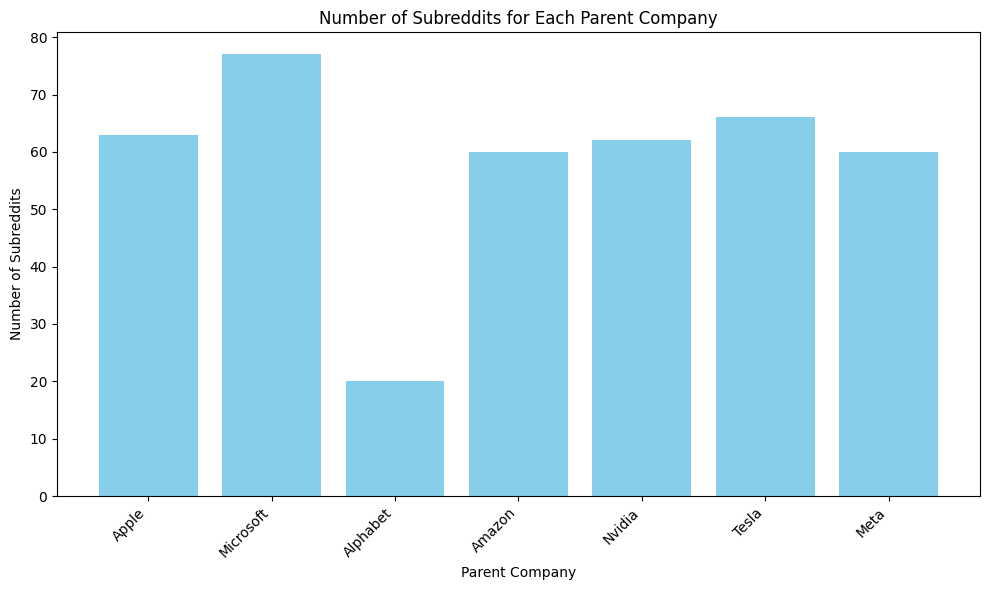

In [ ]:
# plot how many subreddits we ended up with for each parent company
parent_company_counts = {parent_company: len(subreddits) for parent_company, subreddits in subreddits_passed_topic_classifier.items()}
parent_companies = list(parent_company_counts.keys())
subreddit_counts = list(parent_company_counts.values())

plt.figure(figsize=(10, 6))
plt.bar(parent_companies, subreddit_counts, color='skyblue')
plt.xlabel('Parent Company')
plt.ylabel('Number of Subreddits')
plt.title('Number of Subreddits for Each Parent Company')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

## Extracting relevant posts from subreddits

I need to extract posts from each subreddit (in proportional amounts). I can consider taking X amount of hot posts, X amount of controversial posts, etc. I can record the upvotes/downvote ratios. Pass it through a sentiment analysis model to give it a positive/negative score. I can also say get the top 3 comments and up to 3 of their subcomments and also run those through sentiment analysis so it adds on to the overall post's sentiment score to some capacity. It is likely that a lot of the posts might be neutral, so I should make sure I depict that properly in my results.

In [ ]:
await reddit.subreddit("playboicarti", fetch=True)

Subreddit(display_name='playboicarti')

In [ ]:
# get subreddit data that has passed the topic classifier
subreddits_passed_topic_classifier = await read_subreddit_classification_data_from_csv("subreddits_passed_topic_classifier.csv")

An error occurred while fetching subreddit AmazonWebServices: received 403 HTTP response


In [ ]:
subreddits_passed_topic_classifier

defaultdict(list,
            {'Apple': [(Subreddit(display_name='apple'),
               0.9459022283554077,
               0.054097793996334076),
              (Subreddit(display_name='AppleWatch'),
               0.9440438151359558,
               0.055956169962882996),
              (Subreddit(display_name='AppleMusic'),
               0.9431213736534119,
               0.05687863379716873),
              (Subreddit(display_name='iphone'),
               0.9252777695655823,
               0.07472218573093414),
              (Subreddit(display_name='appletv'),
               0.949877142906189,
               0.05012287199497223),
              (Subreddit(display_name='AppleCard'),
               0.9370117783546448,
               0.06298822164535522),
              (Subreddit(display_name='technology'),
               0.8963473439216614,
               0.10365273058414459),
              (Subreddit(display_name='applehelp'),
               0.9459660053253174,
               0.054034

In [ ]:
parent_company_posts = {}
parent_company_post_counts = {}
failed_subreddits = []
for parent_company, subreddits_and_scores in tqdm(subreddits_passed_topic_classifier.items()):
  # create a list of subreddits from the list of tuples that contain the subreddit objects
  subreddits = [item[0] for item in subreddits_and_scores]
  # get X amount of posts from each of the subreddits associated with the current parent company
  current_parent_company_posts, current_failed_subreddits = await probe_subs_for_posts(subreddits, num_posts=5)
  # store failed subreddits
  failed_subreddits.extend(current_failed_subreddits)
  # add key -> parent company, value -> dictionary where key is subreddit object and value is list of submission objects
  parent_company_posts[parent_company] = current_parent_company_posts
  # count how many posts are added per parent company
  parent_company_post_counts[parent_company] = sum(len(value) for key, value in current_parent_company_posts.items())
parent_company_post_counts, parent_company_posts, failed_subreddits

  0%|          | 0/7 [00:00<?, ?it/s]

Error processing posts from subreddit apple_news
Error processing posts from subreddit AppleWatchApps
Error processing posts from subreddit AppleIPTV


 14%|█▍        | 1/7 [00:09<00:58,  9.70s/it]

Error processing posts from subreddit AppleWatches
Error processing posts from subreddit Microsoft_Build
Error processing posts from subreddit MicrosoftInsiders


 29%|██▊       | 2/7 [01:29<04:14, 50.83s/it]

Error processing posts from subreddit TechNewsToday


 43%|████▎     | 3/7 [01:49<02:27, 36.96s/it]

Error processing posts from subreddit AmazonTopRated
Error processing posts from subreddit AmazonWebServices


 57%|█████▋    | 4/7 [02:49<02:17, 45.96s/it]

Error processing posts from subreddit GauGAN


 86%|████████▌ | 6/7 [04:57<00:56, 56.49s/it]

Error processing posts from subreddit OculusMods
Error processing posts from subreddit OculusNames
Error processing posts from subreddit OculusQuestGerman
Error processing posts from subreddit OculusQuest_Sverige


100%|██████████| 7/7 [05:58<00:00, 51.16s/it]


({'Apple': 152,
  'Microsoft': 197,
  'Alphabet': 82,
  'Amazon': 152,
  'Nvidia': 205,
  'Tesla': 152,
  'Meta': 112},
 {'Apple': defaultdict(list,
              {Subreddit(display_name='apple'): [Submission(id='1c2g9lx'),
                Submission(id='1c2lhr4'),
                Submission(id='1c2ojbt'),
                Submission(id='1c2l0rh'),
                Submission(id='1c2moii')],
               Subreddit(display_name='AppleWatch'): [Submission(id='1c279ms'),
                Submission(id='1c2ildr'),
                Submission(id='1c20qop'),
                Submission(id='1c2blfc'),
                Submission(id='1c2akzp')],
               Subreddit(display_name='AppleMusic'): [Submission(id='1c23zym'),
                Submission(id='1c2jekt'),
                Submission(id='1c20btg'),
                Submission(id='1c28y95'),
                Submission(id='1c2kjdy')],
               Subreddit(display_name='iphone'): [Submission(id='1c1ytvi'),
                Submission(id='1c

In [ ]:
add_to_experiment_file("extracting_data_notes", "")
add_to_experiment_file("extracting_data_notes", "Failed subreddits = " + str(failed_subreddits))
add_to_experiment_file("extracting_data_notes",  "Number of failed subreddits: " + str(len(failed_subreddits)))

In [ ]:
add_to_experiment_file("extracting_data_notes", "")
add_to_experiment_file("extracting_data_notes", "Number of posts extracted for each parent company = " + str(parent_company_post_counts))
add_to_experiment_file("extracting_data_notes", "Total number of posts = " + str(sum(parent_company_post_counts.values())))

### Visualize number of posts extracted for each parent company

In [ ]:
def visualize_company_posts(data):
  companies = list(data.keys())
  post_counts = list(data.values())

  plt.figure(figsize=(10, 6))
  plt.barh(companies, post_counts, color='skyblue')
  plt.xlabel('Number of Posts')
  plt.ylabel('Parent Companies')
  plt.title('Number of Posts Extracted from Each Parent Company Related Subreddits')
  plt.show()

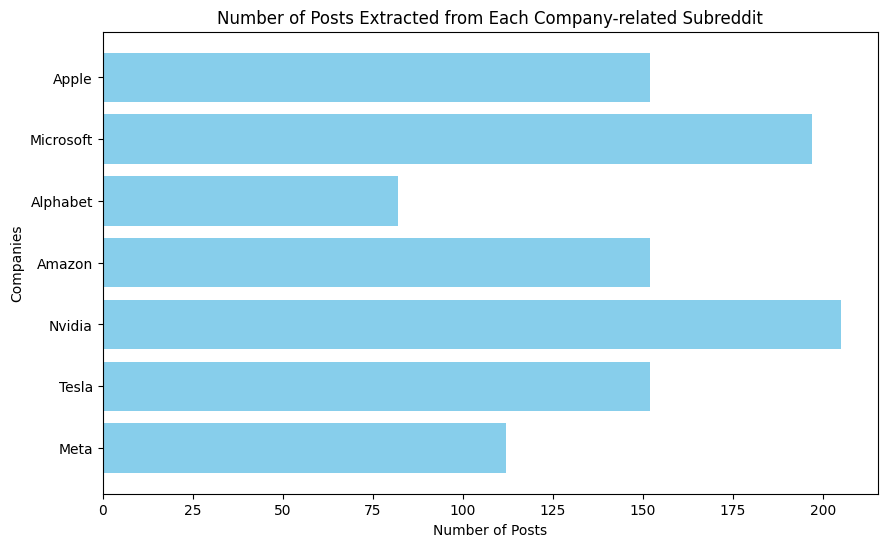

In [ ]:
visualize_company_posts(parent_company_post_counts)

### Write/read csv functions for subreddit ids and post ids

In [ ]:
def write_subreddit_data_to_csv(data: defaultdict, csv_filename: str):
    """
    Write subreddit data stored in a defaultdict to a CSV file.

    Args:
        data (defaultdict): A defaultdict containing subreddit objects and their submissions.
        csv_filename (str): The filename for the CSV file to be created.
        reddit: An instance of the Reddit API client.

    Returns:
        None
    """
    with open(csv_filename, 'w', newline='') as csvfile:
        fieldnames = ['Parent Company', 'Subreddit Display Name', 'Submission IDs']
        writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
        writer.writeheader()

        for parent_company, subreddit_data in data.items():
            for subreddit, submissions in subreddit_data.items():
                submission_ids = [submission.id for submission in submissions]
                writer.writerow({
                    'Parent Company': parent_company,
                    'Subreddit Display Name': subreddit.display_name,
                    'Submission IDs': ','.join(submission_ids)
                })

async def read_subreddit_data_from_csv(csv_filename: str) -> defaultdict:
  """
  Read subreddit data from a CSV file and reconstruct the defaultdict.

  Args:
      csv_filename (str): The filename of the CSV file to read.
      reddit: An instance of the Reddit API client.

  Returns:
      defaultdict: A defaultdict containing subreddit objects and their submission objects.
  """
  data = defaultdict(dict)

  with open(csv_filename, newline='') as csvfile:
      reader = csv.DictReader(csvfile)
      for row in tqdm(reader):
          parent_company = row['Parent Company']
          display_name = row['Subreddit Display Name']
          submission_ids = row['Submission IDs'].split(',')

          try:
            subreddit_object = await reddit.subreddit(display_name, fetch=True)
            submissions = [await reddit.submission(submission_id) for submission_id in submission_ids]
          except Exception as e:
            print(f"Error processing a post from subreddit {display_name}")
          data[parent_company][subreddit_object] = submissions

  return data


In [ ]:
write_subreddit_data_to_csv(parent_company_posts, "parent_company_post_ids.csv")

## Get post comments

In [ ]:
subreddits_and_post_ids = await read_subreddit_data_from_csv("parent_company_post_ids.csv")

Error processing a post from subreddit cordcutters


or

In [ ]:
subreddits_and_post_ids = parent_company_posts

In [ ]:
subreddits_and_post_ids

{'Apple': defaultdict(list,
             {Subreddit(display_name='apple'): [Submission(id='1c2g9lx'),
               Submission(id='1c2lhr4'),
               Submission(id='1c2ojbt'),
               Submission(id='1c2l0rh'),
               Submission(id='1c2moii')],
              Subreddit(display_name='AppleWatch'): [Submission(id='1c279ms'),
               Submission(id='1c2ildr'),
               Submission(id='1c20qop'),
               Submission(id='1c2blfc'),
               Submission(id='1c2akzp')],
              Subreddit(display_name='AppleMusic'): [Submission(id='1c23zym'),
               Submission(id='1c2jekt'),
               Submission(id='1c20btg'),
               Submission(id='1c28y95'),
               Submission(id='1c2kjdy')],
              Subreddit(display_name='iphone'): [Submission(id='1c1ytvi'),
               Submission(id='1c27011'),
               Submission(id='1c237xo'),
               Submission(id='1c27uhs'),
               Submission(id='1c2jsll')],
     

In [ ]:
post_comments = default_dict_dict_dict_list()
post_comment_counts = defaultdict(int)
for parent_company, subreddit_dict in tqdm(subreddits_and_post_ids.items()):
  for subreddit, posts in subreddit_dict.items():
    for post in posts:
      # get X relevant comments
      comments = await probe_submissions_for_comments(submission = post,
                                                      num_comments = 2,
                                                      sort_type = "best")
      post_comments[parent_company][subreddit][post] = comments
      post_comment_counts[parent_company] += len(comments)
post_comment_counts, post_comments

  0%|          | 0/7 [00:00<?, ?it/s]<ipython-input-151-45803badbee9>:7: DeprecationWarning: `Submission.comments` is now a property and no longer needs to be awaited. This will raise an error in a future version of Async PRAW.
  comments = await probe_submissions_for_comments(submission = post,
<ipython-input-16-5a2553066f9f>:26: RuntimeWarning: coroutine 'CommentForest.replace_more' was never awaited
  comments.replace_more(limit=None)
100%|██████████| 7/7 [13:38<00:00, 116.95s/it]


(defaultdict(int,
             {'Apple': 246,
              'Microsoft': 274,
              'Alphabet': 137,
              'Amazon': 237,
              'Nvidia': 342,
              'Tesla': 238,
              'Meta': 165}),
 defaultdict(<function __main__.default_dict_dict_list()>,
             {'Apple': defaultdict(<function __main__.default_dict_list()>,
                          {Subreddit(display_name='apple'): defaultdict(list,
                                       {Submission(id='1c2g9lx'): [Comment(id='kz9tc14'),
                                         Comment(id='kz9uosc')],
                                        Submission(id='1c2lhr4'): [Comment(id='kzavoe7'),
                                         Comment(id='kzb2fof')],
                                        Submission(id='1c2ojbt'): [Comment(id='kzbdlx0'),
                                         Comment(id='kzbev1k')],
                                        Submission(id='1c2l0rh'): [Comment(id='kzau5ri'),
        

In [ ]:
add_to_experiment_file("extracting_data_notes", "")
add_to_experiment_file("extracting_data_notes", "Number of comments extracted for each parent company = " + str(post_comment_counts))
add_to_experiment_file("extracting_data_notes", "Total number of comments = " + str(sum(post_comment_counts.values())))

### Visualize the number of comments extracted from posts under each parent company

In [ ]:
def visualize_company_comments(data):
  companies = list(data.keys())
  comment_counts = list(data.values())

  plt.figure(figsize=(10, 6))
  plt.barh(companies, comment_counts, color='skyblue')
  plt.xlabel('Number of Comments')
  plt.ylabel('Companies')
  plt.title('Number of Comments Under Posts for Each Parent Company')
  plt.gca().invert_yaxis()  # Invert y-axis to display the company with the highest comment count on top
  plt.show()

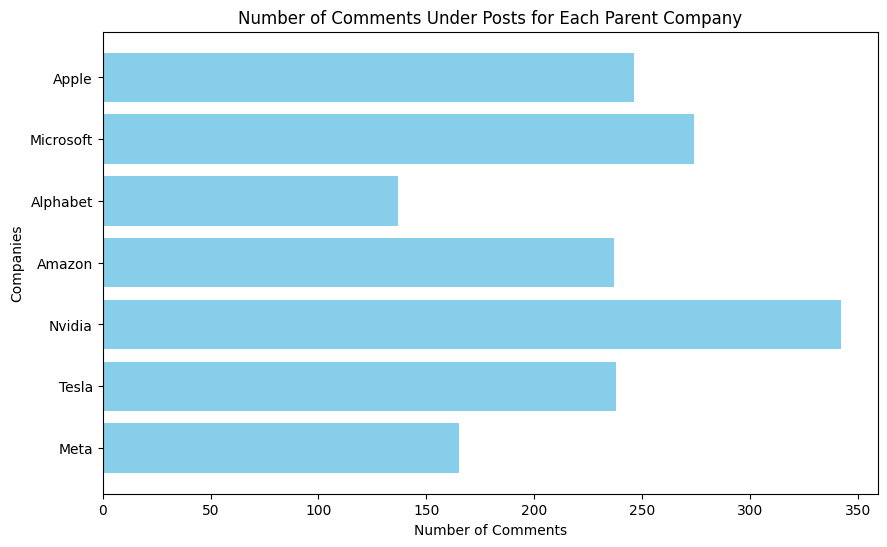

In [ ]:
visualize_company_comments(post_comment_counts)

### Write/read csv functions to storing comment ids for each post

In [ ]:
def write_post_comments_to_csv(data: dict, csv_filename: str) -> None:
  """
  Write post comments data to a CSV file.

  Args:
      data (dict): A dictionary where keys are Submission objects and values are lists of Comment objects.
      csv_filename (str): The filename for the CSV file to be created.

  Returns:
      None
  """
  with open(csv_filename, 'w', newline='') as csvfile:
      fieldnames = ['Parent Company', 'Subreddit Display Name', 'Submission ID', 'Comment IDs']
      writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
      writer.writeheader()

      for parent_company, subreddit_dict in data.items():
        for subreddit, posts in subreddit_dict.items():
          for post, comments in posts.items():
            writer.writerow({
                'Parent Company': parent_company,
                'Subreddit Display Name': subreddit.display_name,
                'Submission ID': post.id,
                'Comment IDs': ','.join(comment.id for comment in comments)
            })

async def read_post_comments_from_csv(csv_filename: str) -> dict:
  """
  Read post comments data from a CSV file and reconstruct the dictionary.

  Args:
      csv_filename (str): The filename of the CSV file to read.

  Returns:
      dict: A dictionary where keys are asyncpraw.models.Submission objects and values are lists of
          asyncpraw.models.Comment objects.
  """
  data = default_dict_dict_dict_list()
  failed_posts = []
  failed_comments = []

  with open(csv_filename, newline='') as csvfile:
      reader = csv.DictReader(csvfile)
      for row in tqdm(reader):
        parent_company = row['Parent Company']
        subreddit_display_name = row['Subreddit Display Name']
        submission_id = row['Submission ID']
        comment_ids = row['Comment IDs'].split(',')

        try:
            submission = await reddit.submission(submission_id)
        except Exception as e:
            print(f"Error processing submission {submission_id}: {e}")
            failed_posts.append(submission_id)

        comments = []
        for comment_id in comment_ids:
          try:
            if comment_id != "" and comment_id != None:
              comment = await reddit.comment(comment_id)
              comments.append(comment)
          except Exception as e:
              print(f"Error processing comment {comment_id}: {e}")
              failed_comments.append(comment_id)

        data[parent_company][subreddit_display_name][submission] = comments

  print(f"Failed to process {len(failed_posts)} posts and {len(failed_comments)} comments.")
  return data, failed_posts, failed_comments

In [ ]:
write_post_comments_to_csv(data=post_comments, csv_filename="post_comments.csv")

## Run post and comments through sentiment analysis model

In [ ]:
post_comments, failed_posts, failed_comments = await read_post_comments_from_csv(csv_filename="post_comments.csv")

283it [12:06,  4.07s/it]

Error processing submission 1c7v7lq: received 429 HTTP response


484it [22:05,  2.39s/it]

Error processing submission 1c850ya: received 429 HTTP response


672it [32:06,  3.81s/it]

Error processing submission 1c82fug: received 429 HTTP response


1807it [1:32:06,  2.66s/it]

Error processing submission 1c7ly67: received 429 HTTP response


1987it [1:41:58,  2.16s/it]

Error processing submission 1am3nqm: received 403 HTTP response


2555it [2:13:16,  4.17s/it]WARNING:asyncprawcore:Retrying due to 500 status: GET https://oauth.reddit.com/comments/1c82u0y/
2633it [2:16:50,  3.12s/it]

Failed to process 5 posts and 0 comments.


### Failed posts and comments during import from csv

In [ ]:
failed_posts

['1c8akd0', '1c821gw']

In [ ]:
failed_comments

['l09bdqb', 'l0banx0', 'l0a6hl8', 'l09b7vd', 'l08bakp', 'l0d0hvo', 'l0au79t']

### Sentiment analysis calculation explanation

Run post title + text and associated comments through sentiment analysis.

Multiply the ratio of upvote/downvote for each of the post and comments by its sentiment score.

    Ex:
    "Economy sucks" 70k upvotes, sentiment score: 0.3

    "No it doesn't" 30k upvotes, sentiment score: 0.5

    (70,000 x 0.3 + 30,000 x 0.5)/(70,000 + 30,000) = 0.36



The distilbert no neutral sentiment model gives you the numerical score for the sentiment for the stronger label, so if "Economy sucks" is more negative than positive, it'll give you the "Negative" Label with the score.

What would be a good way to tabulate the results?

    Ex:
    "Economy sucks" 70k upvotes, sentiment score: Negative->0.8

    "No the economy is actually great" 30k upvotes, sentiment score: Positive->0.9

    (70,000 x -0.8 + 30,000 x 0.9)/(70,000 + 30,000) = -0.29

    This is the sentiment score you get with the post and its comment considered together.

    Let's consider the case where the post and all the comments were 100% positive:

    (70,000 x 1 + 30,000 x 1)/(70,000 + 30,000) = 1

    Let's consider the case where the post and all the comments were 100% negative:

    (70,000 x -1 + 30,000 x -1)/(70,000 + 30,000) = -1

This means that the we are looking at a scale between -1 and 1 for the sentiment scores.

It might be interesting to compare Finbert and regular Bert sentiment analysis.

Or actually might need to scrap the whole financial aspect of it and just focus on regular sentiment analysis for now. It seems like financial sentiment analysis comes up neutral a lot when the text doesn't explicitly mention finance topics.

Potential sentiment analysis models:

* distilbert/distilbert-base-uncased-finetuned-sst-2-english

* ProsusAI/finbert

* lxyuan/distilbert-base-multilingual-cased-sentiments-student

### Separate post comments by parent companies for processing

In [ ]:
apple_post_comments = {"Apple":post_comments["Apple"]}

In [ ]:
microsoft_post_comments = {"Microsoft":post_comments["Microsoft"]}

In [ ]:
alphabet_post_comments = {"Alphabet":post_comments["Alphabet"]}

In [ ]:
amazon_post_comments = {"Amazon":post_comments["Amazon"]}

In [ ]:
nvidia_post_comments = {"Nvidia":post_comments["Nvidia"]}

In [ ]:
tesla_post_comments = {"Tesla":post_comments["Tesla"]}

In [ ]:
meta_post_comments = {"Meta":post_comments["Meta"]}

## Distilbert with no neutral sentiment analysis using distilbert/distilbert-base-uncased-finetuned-sst-2-english

In [ ]:
distilbert_no_neutral_client = InferenceClient(model="distilbert/distilbert-base-uncased-finetuned-sst-2-english", token=userdata.get('HF_TOKEN_READ'))

In [ ]:
output = distilbert_no_neutral_client.text_classification("Economy is great")
output

[{'label': 'POSITIVE', 'score': 0.999854326248169},
 {'label': 'NEGATIVE', 'score': 0.00014564006414730102}]

In [ ]:
for post, comments in post_comments.items():
  print("Post username:", post.name)
  print("Post title:", post.title)
  print("Post selftext:", post.selftext)
  print("post upvote_ratio:", post.upvote_ratio)
  for comment in comments:
    print("Comment body:",  comment.body)
    print("Comment score:", comment.score)
    print("Comment parent_id:", comment.parent_id)

Streaming output truncated to the last 5000 lines.
>  
>It's a like-for-like replacement to Clippy - but made and maintained inside of reddit servers! The bot is called [/r/reputatorbot](https://www.reddit.com/r/reputatorbot)

In other words, nothing changes (except for the message you'll receive when you award a point).

So I'll tip my hat to the new botstitutionTake a bow for the new botolutionSmile and grin at the change all aroundPick up my keyboard and playJust like yesterdayThen I'll get on my knees and prayThat people start replying with "solution verified" one day.

(OK, I'll stop now.)

*I am a bot, and this action was performed automatically. Please [contact the moderators of this subreddit](/message/compose/?to=/r/MSAccess) if you have any questions or concerns.*
Comment score: 1
Comment parent_id: t3_1bfpczn
Comment body: Hold on, what the?

Clippy was a she?
Comment score: 3
Comment parent_id: t3_1bfpczn
Post name: t3_1bfnpnt
Post title: Help with MS Access Query (or Data 

Note: model only accepts 512 characters for inference.

In [ ]:
distilbert_no_neutral_sentiments = defaultdict(list)
distilbert_no_neutral_interactions = defaultdict(int)
distilbert_no_neutral_positive_sentiments = defaultdict(int)
distilbert_no_neutral_negative_sentiments = defaultdict(int)
for parent_company, subreddit_dict in tqdm(meta_post_comments.items()):
  for subreddit, posts in subreddit_dict.items():
    for post, comments in posts.items():
      post_text = post.title + post.selftext
      post_sentiment = distilbert_no_neutral_client.text_classification(post_text[:512])

      if post_sentiment[0]['label'] == 'POSITIVE':
        post_sentiment = post_sentiment[0]['score']
        distilbert_no_neutral_positive_sentiments[parent_company] += 1
      else:
        post_sentiment = -post_sentiment[0]['score']
        distilbert_no_neutral_negative_sentiments[parent_company] += 1
      post_upvote_ratio = post.upvote_ratio

      total_interaction = 0
      total_interaction += post_upvote_ratio

      sentiment_weights = 0
      sentiment_weights += post_upvote_ratio * post_sentiment

      for comment in comments:
        comment_sentiment = distilbert_no_neutral_client.text_classification(comment.body[:512])
        if comment_sentiment[0]['label'] == 'POSITIVE':
          comment_sentiment = comment_sentiment[0]['score']
          distilbert_no_neutral_positive_sentiments[parent_company] += 1
        else:
          comment_sentiment = -comment_sentiment[0]['score']
          distilbert_no_neutral_negative_sentiments[parent_company] += 1
        comment_score = comment.score

        total_interaction += comment_score
        sentiment_weights += comment_score * comment_sentiment

      if total_interaction:
        total_sentiment = sentiment_weights/total_interaction
      else:
        total_sentiment = 0
      distilbert_no_neutral_sentiments[parent_company].append(total_sentiment)
      distilbert_no_neutral_interactions[parent_company] += total_interaction

100%|██████████| 1/1 [00:30<00:00, 30.93s/it]


In [ ]:
apple_distilbert_no_neutral_sentiments = distilbert_no_neutral_sentiments
apple_distilbert_no_neutral_interactions = distilbert_no_neutral_interactions
apple_distilbert_no_neutral_positive_sentiments = distilbert_no_neutral_positive_sentiments
apple_distilbert_no_neutral_negative_sentiments = distilbert_no_neutral_negative_sentiments

In [ ]:
len(apple_distilbert_no_neutral_sentiments["Apple"]), apple_distilbert_no_neutral_positive_sentiments, apple_distilbert_no_neutral_negative_sentiments

(349, defaultdict(int, {'Apple': 250}), defaultdict(int, {'Apple': 849}))

In [ ]:
microsoft_distilbert_no_neutral_sentiments = distilbert_no_neutral_sentiments
microsoft_distilbert_no_neutral_interactions = distilbert_no_neutral_interactions
microsoft_distilbert_no_neutral_positive_sentiments = distilbert_no_neutral_positive_sentiments
microsoft_distilbert_no_neutral_negative_sentiments = distilbert_no_neutral_negative_sentiments

In [ ]:
len(microsoft_distilbert_no_neutral_sentiments["Microsoft"]), microsoft_distilbert_no_neutral_positive_sentiments, microsoft_distilbert_no_neutral_negative_sentiments

(511,
 defaultdict(int, {'Microsoft': 317}),
 defaultdict(int, {'Microsoft': 1254}))

In [ ]:
alphabet_distilbert_no_neutral_sentiments = distilbert_no_neutral_sentiments
alphabet_distilbert_no_neutral_interactions = distilbert_no_neutral_interactions
alphabet_distilbert_no_neutral_positive_sentiments = distilbert_no_neutral_positive_sentiments
alphabet_distilbert_no_neutral_negative_sentiments = distilbert_no_neutral_negative_sentiments

In [ ]:
len(alphabet_distilbert_no_neutral_sentiments["Alphabet"]), alphabet_distilbert_no_neutral_positive_sentiments, alphabet_distilbert_no_neutral_negative_sentiments

(241, defaultdict(int, {'Alphabet': 134}), defaultdict(int, {'Alphabet': 565}))

In [ ]:
amazon_distilbert_no_neutral_sentiments = distilbert_no_neutral_sentiments
amazon_distilbert_no_neutral_interactions = distilbert_no_neutral_interactions
amazon_distilbert_no_neutral_positive_sentiments = distilbert_no_neutral_positive_sentiments
amazon_distilbert_no_neutral_negative_sentiments = distilbert_no_neutral_negative_sentiments

In [ ]:
len(amazon_distilbert_no_neutral_sentiments["Amazon"]), amazon_distilbert_no_neutral_positive_sentiments, amazon_distilbert_no_neutral_negative_sentiments

(358, defaultdict(int, {'Amazon': 254}), defaultdict(int, {'Amazon': 886}))

In [ ]:
nvidia_distilbert_no_neutral_sentiments = distilbert_no_neutral_sentiments
nvidia_distilbert_no_neutral_interactions = distilbert_no_neutral_interactions
nvidia_distilbert_no_neutral_positive_sentiments = distilbert_no_neutral_positive_sentiments
nvidia_distilbert_no_neutral_negative_sentiments = distilbert_no_neutral_negative_sentiments

In [ ]:
len(nvidia_distilbert_no_neutral_sentiments["Nvidia"]), nvidia_distilbert_no_neutral_positive_sentiments, nvidia_distilbert_no_neutral_negative_sentiments

(575, defaultdict(int, {'Nvidia': 386}), defaultdict(int, {'Nvidia': 1517}))

In [ ]:
tesla_distilbert_no_neutral_sentiments = distilbert_no_neutral_sentiments
tesla_distilbert_no_neutral_interactions = distilbert_no_neutral_interactions
tesla_distilbert_no_neutral_positive_sentiments = distilbert_no_neutral_positive_sentiments
tesla_distilbert_no_neutral_negative_sentiments = distilbert_no_neutral_negative_sentiments

In [ ]:
len(tesla_distilbert_no_neutral_sentiments["Tesla"]), tesla_distilbert_no_neutral_positive_sentiments, tesla_distilbert_no_neutral_negative_sentiments

(342, defaultdict(int, {'Tesla': 266}), defaultdict(int, {'Tesla': 915}))

In [ ]:
meta_distilbert_no_neutral_sentiments = distilbert_no_neutral_sentiments
meta_distilbert_no_neutral_interactions = distilbert_no_neutral_interactions
meta_distilbert_no_neutral_positive_sentiments = distilbert_no_neutral_positive_sentiments
meta_distilbert_no_neutral_negative_sentiments = distilbert_no_neutral_negative_sentiments

In [ ]:
len(meta_distilbert_no_neutral_sentiments["Meta"]), meta_distilbert_no_neutral_positive_sentiments, meta_distilbert_no_neutral_negative_sentiments

(255, defaultdict(int, {'Meta': 239}), defaultdict(int, {'Meta': 542}))

In [ ]:
distilbert_no_neutral_sentiments = apple_distilbert_no_neutral_sentiments | microsoft_distilbert_no_neutral_sentiments | alphabet_distilbert_no_neutral_sentiments | amazon_distilbert_no_neutral_sentiments | nvidia_distilbert_no_neutral_sentiments | tesla_distilbert_no_neutral_sentiments | meta_distilbert_no_neutral_sentiments

In [ ]:
distilbert_no_neutral_interactions = apple_distilbert_no_neutral_interactions | microsoft_distilbert_no_neutral_interactions | alphabet_distilbert_no_neutral_interactions | amazon_distilbert_no_neutral_interactions | nvidia_distilbert_no_neutral_interactions | tesla_distilbert_no_neutral_interactions | meta_distilbert_no_neutral_interactions

In [ ]:
distilbert_no_neutral_positive_sentiments = apple_distilbert_no_neutral_positive_sentiments | microsoft_distilbert_no_neutral_positive_sentiments | alphabet_distilbert_no_neutral_positive_sentiments | amazon_distilbert_no_neutral_positive_sentiments | nvidia_distilbert_no_neutral_positive_sentiments | tesla_distilbert_no_neutral_positive_sentiments | meta_distilbert_no_neutral_positive_sentiments

In [ ]:
distilbert_no_neutral_negative_sentiments = apple_distilbert_no_neutral_negative_sentiments | microsoft_distilbert_no_neutral_negative_sentiments | alphabet_distilbert_no_neutral_negative_sentiments | amazon_distilbert_no_neutral_negative_sentiments | nvidia_distilbert_no_neutral_negative_sentiments | tesla_distilbert_no_neutral_negative_sentiments | meta_distilbert_no_neutral_negative_sentiments

In [ ]:
distilbert_no_neutral_sentiments

defaultdict(list,
            {'Apple': [-0.9959336044815228,
              -0.803245780793234,
              -0.492478229939027,
              -0.0112958961489609,
              0.910549120944843,
              -0.996549963951111,
              -0.9978698080974071,
              -0.9919072810457624,
              -0.9986677177453691,
              0.3527574811656577,
              -0.9572300743366081,
              0.11466948282784292,
              0.9633771015211366,
              -0.5910394286034678,
              0.999550215726675,
              -0.9914501272728173,
              -0.7181846018760436,
              -0.48459339293812226,
              -1.5857360241088003,
              0.9609265619868659,
              -0.34037427107493085,
              8.907914161682129e-05,
              -0.9826299548149109,
              0.9992334453477016,
              -0.9657595091395907,
              0.010108754810260448,
              -0.5328083038330078,
              -0.9901190102100372,

In [ ]:
# number of upvote/downvote ratio for all the posts and comments from all the subs
# combined for a specific company
distilbert_no_neutral_interactions

defaultdict(int,
            {'Apple': 54616.96999999994,
             'Microsoft': 106148.37999999999,
             'Alphabet': 50762.21999999997,
             'Amazon': 53008.049999999996,
             'Nvidia': 101909.15000000008,
             'Tesla': 85860.02999999998,
             'Meta': 79131.40000000002})

In [ ]:
distilbert_no_neutral_positive_sentiments

defaultdict(int,
            {'Apple': 250,
             'Microsoft': 317,
             'Alphabet': 134,
             'Amazon': 254,
             'Nvidia': 386,
             'Tesla': 266,
             'Meta': 239})

In [ ]:
distilbert_no_neutral_negative_sentiments

defaultdict(int,
            {'Apple': 849,
             'Microsoft': 1254,
             'Alphabet': 565,
             'Amazon': 886,
             'Nvidia': 1517,
             'Tesla': 915,
             'Meta': 542})

In [ ]:
distilbert_no_neutral_average_sentiments = {}
for parent_company, sentiment_values in distilbert_no_neutral_sentiments.items():
  distilbert_no_neutral_average_sentiments[parent_company] = sum(sentiment_values)/len(sentiment_values)

distilbert_no_neutral_average_sentiments

{'Apple': -0.5319841422771242,
 'Microsoft': -0.583243630381412,
 'Alphabet': -0.5933607495025442,
 'Amazon': -0.604038289944676,
 'Nvidia': -0.5776627010419763,
 'Tesla': -0.5328201860546641,
 'Meta': -0.37984941109609893}

In [ ]:
create_experiment_file("distilbert_no_neutral_notes", "Sentiment analysis using distilbert with no neutral")
add_to_experiment_file("distilbert_no_neutral_notes", "")
add_to_experiment_file("distilbert_no_neutral_notes", "Model: distilbert/distilbert-base-uncased-finetuned-sst-2-english")
add_to_experiment_file("distilbert_no_neutral_notes", "Average sentiments per parent company = " + str(distilbert_no_neutral_average_sentiments))
add_to_experiment_file("distilbert_no_neutral_notes", "Interactions per parent company = " + str(distilbert_no_neutral_interactions))
add_to_experiment_file("distilbert_no_neutral_notes", "Positive sentiments per parent company = " + str(distilbert_no_neutral_positive_sentiments))
add_to_experiment_file("distilbert_no_neutral_notes", "Negative sentiments per parent company = " + str(distilbert_no_neutral_negative_sentiments))

### Visualize average sentiments, interactions, and positive and neutral sentiment scores

In [ ]:
def visualize_average_sentiment(sentiment_data):
  companies = list(sentiment_data.keys())
  avg_sentiments = list(sentiment_data.values())

  plt.figure(figsize=(10, 6))
  plt.barh(companies, avg_sentiments, color='skyblue')
  plt.xlabel('Average Sentiment')
  plt.ylabel('Companies')
  plt.title('Average Sentiment per Parent Company')
  plt.xlim(-1, 1)  # Set the x-axis limits to range from -1 to 1
  plt.gca().invert_yaxis()  # Invert y-axis to display the company with the highest sentiment on top
  plt.show()

In [ ]:
def visualize_overall_interaction(interaction_data):
  companies = list(interaction_data.keys())
  interactions = list(interaction_data.values())

  plt.figure(figsize=(10, 6))
  plt.barh(companies, interactions, color='skyblue')
  plt.xlabel('Overall Interaction (Posts + Comments)')
  plt.ylabel('Companies')
  plt.title('Overall Interaction for Each Parent Company')
  plt.gca().invert_yaxis()  # Invert y-axis to display the company with the highest interaction on top
  plt.show()

In [ ]:
def visualize_positive_negative_sentiments(positive_sentiment_data, negative_sentiment_data):
  companies = list(positive_sentiment_data.keys())
  positive_sentiments = [positive_sentiment_data[company] for company in companies]
  negative_sentiments = [negative_sentiment_data[company] for company in companies]

  bar_width = 0.35
  index = np.arange(len(companies))

  plt.figure(figsize=(10, 6))
  plt.bar(index, positive_sentiments, bar_width, label='Positive Sentiments', color='skyblue')
  plt.bar(index + bar_width, negative_sentiments, bar_width, label='Negative Sentiments', color='salmon')

  plt.xlabel('Companies')
  plt.ylabel('Number of Sentiments')
  plt.title('Positive and Negative Sentiments for Each Parent Company')
  plt.xticks(index + bar_width / 2, companies, rotation=45)
  plt.legend()
  plt.tight_layout()
  plt.show()

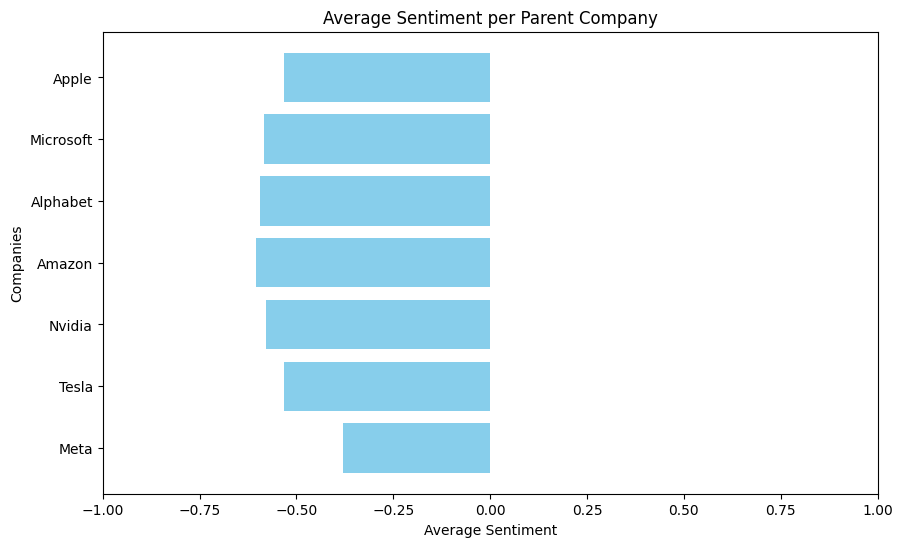

In [ ]:
visualize_average_sentiment(distilbert_no_neutral_average_sentiments)

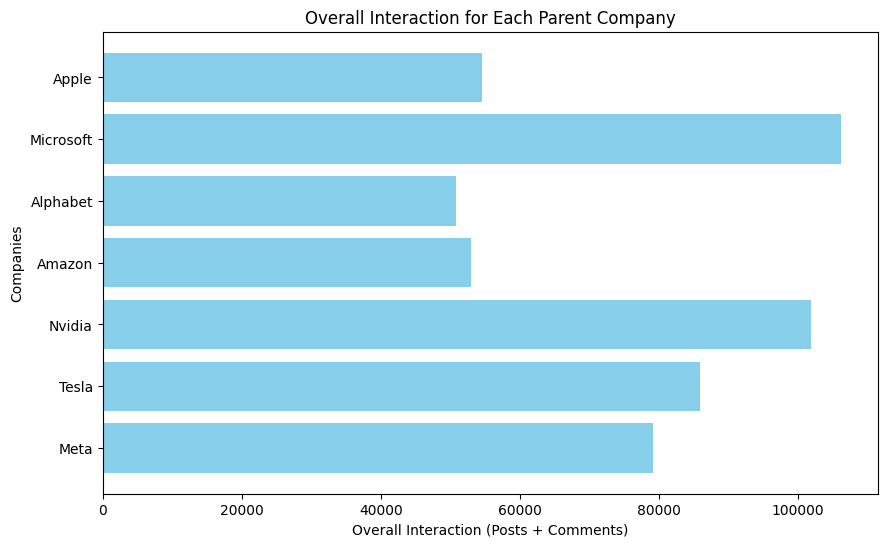

In [ ]:
visualize_overall_interaction(distilbert_no_neutral_interactions)

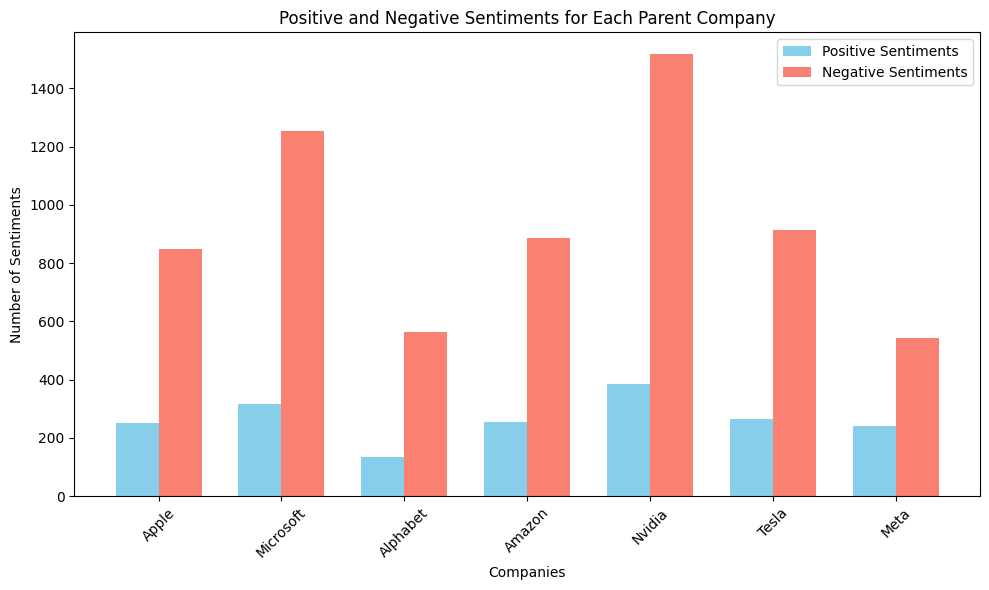

In [ ]:
visualize_positive_negative_sentiments(distilbert_no_neutral_positive_sentiments,
                                       distilbert_no_neutral_negative_sentiments)

### Write/read csv functions for parent company average sentiment score, interactions, positive and negative sentiment score counts

In [ ]:
import csv
from collections import defaultdict

def write_company_sentiments_to_csv(data: dict, interactions: dict, positive_sentiments: dict, negative_sentiments: dict, csv_filename: str) -> None:
    """
    Write company average sentiment data along with interaction counts, positive sentiments, and negative sentiments to a CSV file.

    Args:
        data (dict): A dictionary where keys are str objects (parent companies) and values are int objects (average sentiments).
        interactions (dict): A dictionary where keys are parent companies and values are int objects (interaction counts).
        positive_sentiments (dict): A dictionary where keys are parent companies and values are int objects (number of positive sentiments).
        negative_sentiments (dict): A dictionary where keys are parent companies and values are int objects (number of negative sentiments).
        csv_filename (str): The filename for the CSV file to be created.

    Returns:
        None
    """
    with open(csv_filename, 'w', newline='') as csvfile:
        fieldnames = ['Parent Company', 'Average Sentiment', 'Interactions', 'Positive Sentiments', 'Negative Sentiments']
        writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
        writer.writeheader()

        for parent_company, average_sentiment in data.items():
            interactions_count = interactions.get(parent_company, 0)
            positive_sentiments_count = positive_sentiments.get(parent_company, 0)
            negative_sentiments_count = negative_sentiments.get(parent_company, 0)

            # Round the numbers to three decimal places
            average_sentiment = round(average_sentiment, 3)
            interactions_count = round(interactions_count, 3)
            positive_sentiments_count = round(positive_sentiments_count, 3)
            negative_sentiments_count = round(negative_sentiments_count, 3)

            writer.writerow({
                'Parent Company': parent_company,
                'Average Sentiment': average_sentiment,
                'Interactions': interactions_count,
                'Positive Sentiments': positive_sentiments_count,
                'Negative Sentiments': negative_sentiments_count
            })

def read_company_sentiments_from_csv(csv_filename: str) -> dict:
    """
    Read company average sentiment data along with interaction counts, positive sentiments, and negative sentiments from a CSV file and reconstruct the dictionary.

    Args:
        csv_filename (str): The filename of the CSV file to read.

    Returns:
        dict: A dictionary where keys are str objects (parent companies) and values are dictionaries containing sentiment data.
    """
    data = defaultdict(dict)

    with open(csv_filename, newline='') as csvfile:
        reader = csv.DictReader(csvfile)
        for row in tqdm(reader):
            parent_company = row['Parent Company']
            sentiment_data = {
                'Average Sentiment': float(row['Average Sentiment']),
                'Interactions': int(row['Interactions']),
                'Positive Sentiments': int(row['Positive Sentiments']),
                'Negative Sentiments': int(row['Negative Sentiments'])
            }
            data[parent_company] = sentiment_data

    return data


In [ ]:
write_company_sentiments_to_csv(data=distilbert_no_neutral_average_sentiments,
                                interactions=distilbert_no_neutral_interactions,
                                positive_sentiments=distilbert_no_neutral_positive_sentiments,
                                negative_sentiments=distilbert_no_neutral_negative_sentiments,
                                csv_filename="distilbert_no_neutral_results.csv")

## Financial sentiment analysis using ProsusAI/finbert

In [ ]:
finbert_client = InferenceClient(model="ProsusAI/finbert", token=userdata.get('HF_TOKEN_READ'))

In [ ]:
output = finbert_client.text_classification("The economy great and the stocks are good.")
output

[TextClassificationOutputElement(label='positive', score=0.6863113045692444),
 TextClassificationOutputElement(label='neutral', score=0.26789069175720215),
 TextClassificationOutputElement(label='negative', score=0.04579795524477959)]

In [ ]:
# if the highest score is neutral
if output[0]['label'] == 'neutral':
  print("post is neutral")
  print(output[0]["score"])
# if the highest score is positive
elif output[0]['label'] == 'positive':
  print("post is positive")
  print(output[0]["score"])
# if the highest score is negative
elif output[0]['label'] == 'negative':
  print("post is negative")
  print(output[0]["score"])

post is positive
0.6863113045692444


How to account for neutral in sentiment calculation?

Okay so my theory is, Finbert is super specific to financial data so it is going to return neutral for almost all the posts. I'm going to count as the post sentiment being 0 if it turns out to be neutral, but will still include the interaction on the post in the total sentiment calculation for the post, because the comments may have positive or negative sentiments that we want to include.

In [ ]:
finbert_sentiments = defaultdict(list)
finbert_interactions = defaultdict(int)
finbert_neutral_sentiments = defaultdict(int)
finbert_positive_sentiments = defaultdict(int)
finbert_negative_sentiments = defaultdict(int)

for parent_company, subreddit_dict in tqdm(meta_post_comments.items()):
  for subreddit, posts in subreddit_dict.items():
    for post, comments in posts.items():
      post_text = post.title + post.selftext
      post_sentiment = finbert_client.text_classification(post_text[:512])

      # if the highest score is neutral
      if post_sentiment[0]['label'] == 'neutral':
        post_sentiment = 0
        finbert_neutral_sentiments[parent_company] += 1
      # if the highest score is positive
      elif post_sentiment[0]['label'] == 'positive':
        post_sentiment = post_sentiment[0]['score']
        finbert_positive_sentiments[parent_company] += 1
      # if the highest score is negative
      elif post_sentiment[0]['label'] == 'negative':
        post_sentiment = -post_sentiment[0]['score']
        finbert_negative_sentiments[parent_company] += 1

      post_upvote_ratio = post.upvote_ratio

      total_interaction = 0
      total_interaction += post_upvote_ratio

      sentiment_weights = 0
      sentiment_weights += post_upvote_ratio * post_sentiment

      for comment in comments:
        comment_sentiment = finbert_client.text_classification(comment.body[:512])

        # if comment score is neutral
        if comment_sentiment[0]['label'] == 'neutral':
          comment_sentiment = 0
          finbert_neutral_sentiments[parent_company] += 1
        # if comment score is positive
        elif comment_sentiment[0]['label'] == 'positive':
          comment_sentiment = comment_sentiment[0]['score']
          finbert_positive_sentiments[parent_company] += 1
        # if comment score is negative
        elif comment_sentiment[0]['label'] == 'negative':
          comment_sentiment = -comment_sentiment[0]['score']
          finbert_negative_sentiments[parent_company] += 1

        comment_score = comment.score

        total_interaction += comment_score
        sentiment_weights += comment_score * comment_sentiment

      if total_interaction:
        total_sentiment = sentiment_weights/total_interaction
      else:
        total_sentiment = 0
      finbert_sentiments[parent_company].append(total_sentiment)
      finbert_interactions[parent_company] += total_interaction

100%|██████████| 1/1 [02:48<00:00, 168.83s/it]


In [ ]:
apple_finbert_sentiments = finbert_sentiments
apple_finbert_interactions = finbert_interactions
apple_finbert_positive_sentiments = finbert_positive_sentiments
apple_finbert_negative_sentiments = finbert_negative_sentiments
apple_finbert_neutral_sentiments = finbert_neutral_sentiments

In [ ]:
apple_finbert_sentiments["Apple"][:5]

[-0.0010247600470218105, 0.0, -0.15343198937619285, 0.0, 0.0]

In [ ]:
len(apple_finbert_sentiments["Apple"]), apple_finbert_interactions, apple_finbert_positive_sentiments, apple_finbert_negative_sentiments, apple_finbert_neutral_sentiments

(349,
 defaultdict(int, {'Apple': 55040.62999999997}),
 defaultdict(int, {'Apple': 22}),
 defaultdict(int, {'Apple': 107}),
 defaultdict(int, {'Apple': 971}))

In [ ]:
microsoft_finbert_sentiments = finbert_sentiments
microsoft_finbert_interactions = finbert_interactions
microsoft_finbert_positive_sentiments = finbert_positive_sentiments
microsoft_finbert_negative_sentiments = finbert_negative_sentiments
microsoft_finbert_neutral_sentiments = finbert_neutral_sentiments

In [ ]:
microsoft_finbert_sentiments["Microsoft"][:5]

[0.0, 0.0, 0.0, -0.1756360353404329, -0.3496029776727368]

In [ ]:
len(microsoft_finbert_sentiments["Microsoft"]), microsoft_finbert_interactions, microsoft_finbert_positive_sentiments, microsoft_finbert_negative_sentiments, microsoft_finbert_neutral_sentiments

(509,
 defaultdict(int, {'Microsoft': 106983.30000000002}),
 defaultdict(int, {'Microsoft': 36}),
 defaultdict(int, {'Microsoft': 139}),
 defaultdict(int, {'Microsoft': 1390}))

In [ ]:
alphabet_finbert_sentiments = finbert_sentiments
alphabet_finbert_interactions = finbert_interactions
alphabet_finbert_positive_sentiments = finbert_positive_sentiments
alphabet_finbert_negative_sentiments = finbert_negative_sentiments
alphabet_finbert_neutral_sentiments = finbert_neutral_sentiments

In [ ]:
len(alphabet_finbert_sentiments["Alphabet"]), alphabet_finbert_interactions, alphabet_finbert_positive_sentiments, alphabet_finbert_negative_sentiments, alphabet_finbert_neutral_sentiments

(241,
 defaultdict(int, {'Alphabet': 51219.59999999998}),
 defaultdict(int, {'Alphabet': 14}),
 defaultdict(int, {'Alphabet': 75}),
 defaultdict(int, {'Alphabet': 610}))

In [ ]:
amazon_finbert_sentiments = finbert_sentiments
amazon_finbert_interactions = finbert_interactions
amazon_finbert_positive_sentiments = finbert_positive_sentiments
amazon_finbert_negative_sentiments = finbert_negative_sentiments
amazon_finbert_neutral_sentiments = finbert_neutral_sentiments

In [ ]:
len(amazon_finbert_sentiments["Amazon"]), amazon_finbert_interactions, amazon_finbert_positive_sentiments, amazon_finbert_negative_sentiments, amazon_finbert_neutral_sentiments

(358,
 defaultdict(int, {'Amazon': 53432.129999999976}),
 defaultdict(int, {'Amazon': 14}),
 defaultdict(int, {'Amazon': 112}),
 defaultdict(int, {'Amazon': 1015}))

In [ ]:
nvidia_finbert_sentiments = finbert_sentiments
nvidia_finbert_interactions = finbert_interactions
nvidia_finbert_positive_sentiments = finbert_positive_sentiments
nvidia_finbert_negative_sentiments = finbert_negative_sentiments
nvidia_finbert_neutral_sentiments = finbert_neutral_sentiments

In [ ]:
len(nvidia_finbert_sentiments["Nvidia"]), nvidia_finbert_interactions, nvidia_finbert_positive_sentiments, nvidia_finbert_negative_sentiments, nvidia_finbert_neutral_sentiments

(574,
 defaultdict(int, {'Nvidia': 102716.11000000004}),
 defaultdict(int, {'Nvidia': 62}),
 defaultdict(int, {'Nvidia': 133}),
 defaultdict(int, {'Nvidia': 1706}))

In [ ]:
tesla_finbert_sentiments = finbert_sentiments
tesla_finbert_interactions = finbert_interactions
tesla_finbert_positive_sentiments = finbert_positive_sentiments
tesla_finbert_negative_sentiments = finbert_negative_sentiments
tesla_finbert_neutral_sentiments = finbert_neutral_sentiments

In [ ]:
len(tesla_finbert_sentiments["Tesla"]), tesla_finbert_interactions, tesla_finbert_positive_sentiments, tesla_finbert_negative_sentiments, tesla_finbert_neutral_sentiments

(342,
 defaultdict(int, {'Tesla': 86765.07999999997}),
 defaultdict(int, {'Tesla': 40}),
 defaultdict(int, {'Tesla': 183}),
 defaultdict(int, {'Tesla': 959}))

In [ ]:
meta_finbert_sentiments = finbert_sentiments
meta_finbert_interactions = finbert_interactions
meta_finbert_positive_sentiments = finbert_positive_sentiments
meta_finbert_negative_sentiments = finbert_negative_sentiments
meta_finbert_neutral_sentiments = finbert_neutral_sentiments

In [ ]:
len(meta_finbert_sentiments["Meta"]), meta_finbert_interactions, meta_finbert_positive_sentiments, meta_finbert_negative_sentiments, meta_finbert_neutral_sentiments

(256,
 defaultdict(int, {'Meta': 79531.52000000003}),
 defaultdict(int, {'Meta': 25}),
 defaultdict(int, {'Meta': 41}),
 defaultdict(int, {'Meta': 717}))

In [ ]:
finbert_sentiments = apple_finbert_sentiments | microsoft_finbert_sentiments | alphabet_finbert_sentiments | amazon_finbert_sentiments | nvidia_finbert_sentiments | tesla_finbert_sentiments | meta_finbert_sentiments

In [ ]:
finbert_interactions = apple_finbert_interactions | microsoft_finbert_interactions | alphabet_finbert_interactions | amazon_finbert_interactions | nvidia_finbert_interactions | tesla_finbert_interactions | meta_finbert_interactions

In [ ]:
finbert_positive_sentiments = apple_finbert_positive_sentiments | microsoft_finbert_positive_sentiments | alphabet_finbert_positive_sentiments | amazon_finbert_positive_sentiments | nvidia_finbert_positive_sentiments | tesla_finbert_positive_sentiments | meta_finbert_positive_sentiments

In [ ]:
finbert_negative_sentiments = apple_finbert_negative_sentiments | microsoft_finbert_negative_sentiments | alphabet_finbert_negative_sentiments | amazon_finbert_negative_sentiments | nvidia_finbert_negative_sentiments | tesla_finbert_negative_sentiments | meta_finbert_negative_sentiments

In [ ]:
finbert_neutral_sentiments = apple_finbert_neutral_sentiments | microsoft_finbert_neutral_sentiments | alphabet_finbert_neutral_sentiments | amazon_finbert_neutral_sentiments | nvidia_finbert_neutral_sentiments | tesla_finbert_neutral_sentiments | meta_finbert_neutral_sentiments

In [ ]:
finbert_average_sentiments = {}
for parent_company, sentiment_values in finbert_sentiments.items():
  finbert_average_sentiments[parent_company] = sum(sentiment_values)/len(sentiment_values)

finbert_average_sentiments

{'Apple': -0.03997022301043706,
 'Microsoft': -0.03690894008198013,
 'Alphabet': -0.042108649604943184,
 'Amazon': -0.04497552522835559,
 'Nvidia': -0.01171595935377834,
 'Tesla': -0.08132958600670832,
 'Meta': -0.009949445478302465}

In [ ]:
finbert_interactions

defaultdict(int,
            {'Apple': 55040.62999999997,
             'Microsoft': 106983.30000000002,
             'Alphabet': 51219.59999999998,
             'Amazon': 53432.129999999976,
             'Nvidia': 102716.11000000004,
             'Tesla': 86765.07999999997,
             'Meta': 79531.52000000003})

In [ ]:
finbert_positive_sentiments

defaultdict(int,
            {'Apple': 22,
             'Microsoft': 36,
             'Alphabet': 14,
             'Amazon': 14,
             'Nvidia': 62,
             'Tesla': 40,
             'Meta': 25})

In [ ]:
finbert_negative_sentiments

defaultdict(int,
            {'Apple': 107,
             'Microsoft': 139,
             'Alphabet': 75,
             'Amazon': 112,
             'Nvidia': 133,
             'Tesla': 183,
             'Meta': 41})

In [ ]:
finbert_neutral_sentiments

defaultdict(int,
            {'Apple': 971,
             'Microsoft': 1390,
             'Alphabet': 610,
             'Amazon': 1015,
             'Nvidia': 1706,
             'Tesla': 959,
             'Meta': 717})

In [ ]:
create_experiment_file("finbert_notes", "Sentiment analysis using finbert")
add_to_experiment_file("finbert_notes", "")
add_to_experiment_file("finbert_notes", "Model: ProsusAI/finbert")
add_to_experiment_file("finbert_notes", "Average sentiments per parent company = " + str(finbert_average_sentiments))
add_to_experiment_file("finbert_notes", "Interactions per parent company = " + str(finbert_interactions))
add_to_experiment_file("finbert_notes", "Positive sentiments per parent company = " + str(finbert_positive_sentiments))
add_to_experiment_file("finbert_notes", "Negative sentiments per parent company = " + str(finbert_negative_sentiments))
add_to_experiment_file("finbert_notes", "Neutral sentiments per parent company = " + str(finbert_neutral_sentiments))

### Visualize average sentiments, interactions, and positive, negative, and neutral sentiment scores

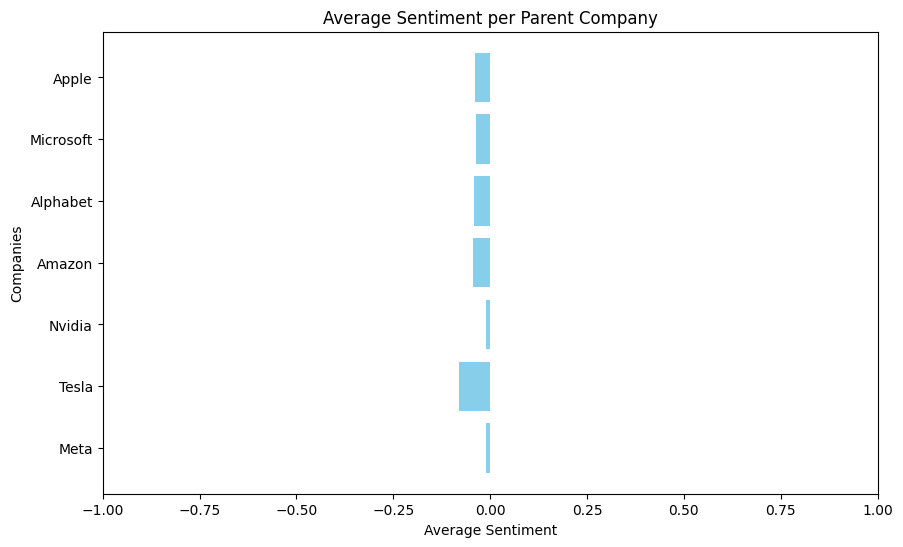

In [ ]:
visualize_average_sentiment(finbert_average_sentiments)

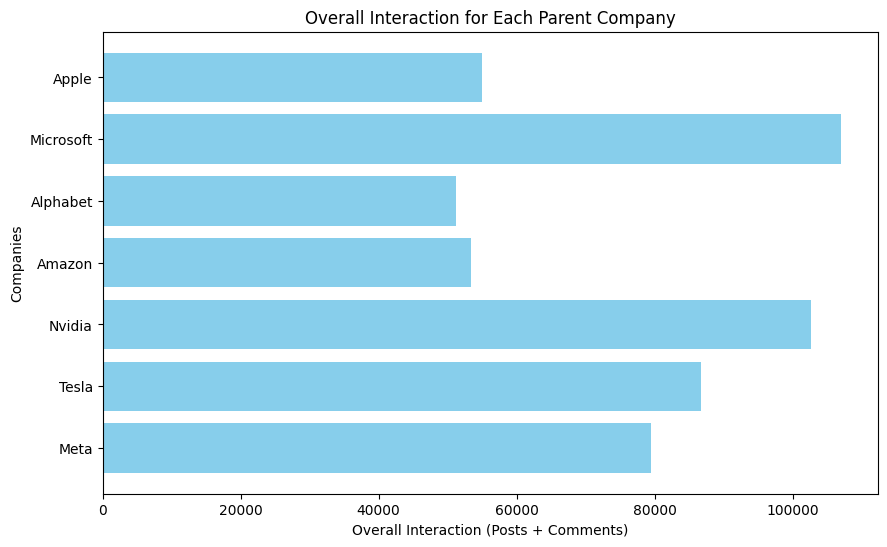

In [ ]:
visualize_overall_interaction(finbert_interactions)

In [ ]:
def visualize_sentiments(positive_sentiment_data, negative_sentiment_data, neutral_sentiment_data):
    companies = list(positive_sentiment_data.keys())
    positive_sentiments = [positive_sentiment_data[company] for company in companies]
    negative_sentiments = [negative_sentiment_data[company] for company in companies]
    neutral_sentiments = [neutral_sentiment_data[company] for company in companies]

    bar_width = 0.25
    index = np.arange(len(companies))

    plt.figure(figsize=(10, 6))
    plt.bar(index, positive_sentiments, bar_width, label='Positive Sentiments', color='skyblue')
    plt.bar(index + bar_width, negative_sentiments, bar_width, label='Negative Sentiments', color='salmon')
    plt.bar(index + 2*bar_width, neutral_sentiments, bar_width, label='Neutral Sentiments', color='lightgreen')

    plt.xlabel('Companies')
    plt.ylabel('Number of Sentiments')
    plt.title('Sentiments for Each Parent Company')
    plt.xticks(index + bar_width, companies, rotation=45)
    plt.legend()
    plt.tight_layout()
    plt.show()

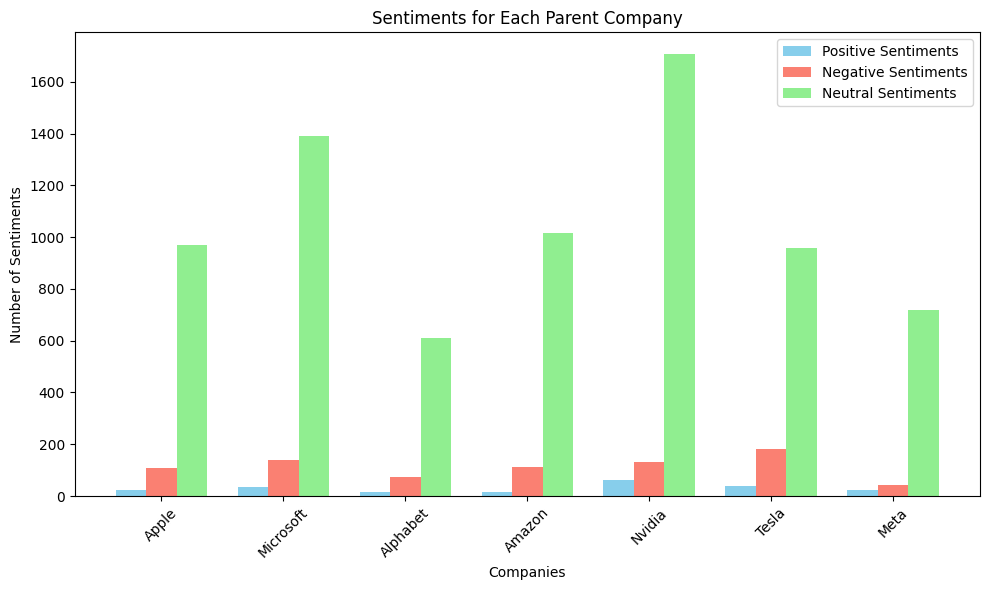

In [ ]:
visualize_sentiments(finbert_positive_sentiments, finbert_negative_sentiments, finbert_neutral_sentiments)

### Write/read csv functions for parent company average sentiment score, interactions, positive, negative, and neutral sentiment scores

In [ ]:
def write_company_sentiments_to_csv(data: dict, interactions: dict, positive_sentiments: dict, negative_sentiments: dict, neutral_sentiments: dict, csv_filename: str) -> None:
  """
  Write company average sentiment data along with interaction counts, positive sentiments, negative sentiments, and neutral sentiments to a CSV file.

  Args:
      data (dict): A dictionary where keys are str objects (parent companies) and values are int objects (average sentiments).
      interactions (dict): A dictionary where keys are parent companies and values are int objects (interaction counts).
      positive_sentiments (dict): A dictionary where keys are parent companies and values are int objects (number of positive sentiments).
      negative_sentiments (dict): A dictionary where keys are parent companies and values are int objects (number of negative sentiments).
      neutral_sentiments (dict): A dictionary where keys are parent companies and values are int objects (number of neutral sentiments).
      csv_filename (str): The filename for the CSV file to be created.

  Returns:
      None
  """
  with open(csv_filename, 'w', newline='') as csvfile:
      fieldnames = ['Parent Company', 'Average Sentiment', 'Interactions', 'Positive Sentiments', 'Negative Sentiments', 'Neutral Sentiments']
      writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
      writer.writeheader()

      for parent_company, average_sentiment in data.items():
          interactions_count = interactions.get(parent_company, 0)
          positive_sentiments_count = positive_sentiments.get(parent_company, 0)
          negative_sentiments_count = negative_sentiments.get(parent_company, 0)
          neutral_sentiments_count = neutral_sentiments.get(parent_company, 0)

          # Round the numbers to three decimal places
          average_sentiment = round(average_sentiment, 3)
          interactions_count = round(interactions_count, 3)
          positive_sentiments_count = round(positive_sentiments_count, 3)
          negative_sentiments_count = round(negative_sentiments_count, 3)
          neutral_sentiments_count = round(neutral_sentiments_count, 3)

          writer.writerow({
              'Parent Company': parent_company,
              'Average Sentiment': average_sentiment,
              'Interactions': interactions_count,
              'Positive Sentiments': positive_sentiments_count,
              'Negative Sentiments': negative_sentiments_count,
              'Neutral Sentiments': neutral_sentiments_count
          })

def read_company_sentiments_from_csv(csv_filename: str) -> dict:
  """
  Read company average sentiment data along with interaction counts, positive sentiments, negative sentiments, and neutral sentiments from a CSV file and reconstruct the dictionary.

  Args:
      csv_filename (str): The filename of the CSV file to read.

  Returns:
      dict: A dictionary where keys are str objects (parent companies) and values are dictionaries containing sentiment data.
  """
  data = defaultdict(dict)

  with open(csv_filename, newline='') as csvfile:
      reader = csv.DictReader(csvfile)
      for row in reader:
          parent_company = row['Parent Company']
          sentiment_data = {
              'Average Sentiment': float(row['Average Sentiment']),
              'Interactions': int(row['Interactions']),
              'Positive Sentiments': int(row['Positive Sentiments']),
              'Negative Sentiments': int(row['Negative Sentiments']),
              'Neutral Sentiments': int(row['Neutral Sentiments'])
          }
          data[parent_company] = sentiment_data

  return data


In [ ]:
write_company_sentiments_to_csv(data=finbert_average_sentiments,
                                interactions=finbert_interactions,
                                positive_sentiments=finbert_positive_sentiments,
                                negative_sentiments=finbert_negative_sentiments,
                                neutral_sentiments=finbert_neutral_sentiments,
                                csv_filename="finbert_results.csv")

## Distilbert with neutral using lxyuan/distilbert-base-multilingual-cased-sentiments-student

In [ ]:
distilbert_neutral_client = InferenceClient(model="lxyuan/distilbert-base-multilingual-cased-sentiments-student", token=userdata.get('HF_TOKEN_READ'))

In [ ]:
output = distilbert_neutral_client.text_classification("The economy sucks and the stocks are bad.")
output

[TextClassificationOutputElement(label='negative', score=0.9451038837432861),
 TextClassificationOutputElement(label='neutral', score=0.03315608575940132),
 TextClassificationOutputElement(label='positive', score=0.021740064024925232)]

In [ ]:
# if the highest score is neutral
if output[0]['label'] == 'neutral':
  print("post is neutral")
  print(output[0]["score"])
# if the highest score is positive
elif output[0]['label'] == 'positive':
  print("post is positive")
  print(output[0]["score"])
# if the highest score is negative
elif output[0]['label'] == 'negative':
  print("post is negative")
  print(output[0]["score"])

post is negative
0.9451038837432861


In [ ]:
distilbert_neutral_sentiments = defaultdict(list)
distilbert_neutral_interactions = defaultdict(int)
distilbert_neutral_neutral_sentiments = defaultdict(int)
distilbert_neutral_positive_sentiments = defaultdict(int)
distilbert_neutral_negative_sentiments = defaultdict(int)

for parent_company, subreddit_dict in tqdm(meta_post_comments.items()):
  for subreddit, posts in subreddit_dict.items():
    for post, comments in posts.items():
      post_text = post.title + post.selftext
      post_sentiment = distilbert_neutral_client.text_classification(post_text[:512])

      # if the highest score is neutral
      if post_sentiment[0]['label'] == 'neutral':
        post_sentiment = 0
        distilbert_neutral_neutral_sentiments[parent_company] += 1
      # if the highest score is positive
      elif post_sentiment[0]['label'] == 'positive':
        post_sentiment = post_sentiment[0]['score']
        distilbert_neutral_positive_sentiments[parent_company] += 1
      # if the highest score is negative
      elif post_sentiment[0]['label'] == 'negative':
        post_sentiment = -post_sentiment[0]['score']
        distilbert_neutral_negative_sentiments[parent_company] += 1

      post_upvote_ratio = post.upvote_ratio

      total_interaction = 0
      total_interaction += post_upvote_ratio

      sentiment_weights = 0
      sentiment_weights += post_upvote_ratio * post_sentiment

      for comment in comments:
        comment_sentiment = distilbert_neutral_client.text_classification(comment.body[:512])

        # if comment score is neutral
        if comment_sentiment[0]['label'] == 'neutral':
          comment_sentiment = 0
          distilbert_neutral_neutral_sentiments[parent_company] += 1
        # if comment score is positive
        elif comment_sentiment[0]['label'] == 'positive':
          comment_sentiment = comment_sentiment[0]['score']
          distilbert_neutral_positive_sentiments[parent_company] += 1
        # if comment score is negative
        elif comment_sentiment[0]['label'] == 'negative':
          comment_sentiment = -comment_sentiment[0]['score']
          distilbert_neutral_negative_sentiments[parent_company] += 1

        comment_score = comment.score

        total_interaction += comment_score
        sentiment_weights += comment_score * comment_sentiment

      if total_interaction:
        total_sentiment = sentiment_weights/total_interaction
      else:
        total_sentiment = 0
      distilbert_neutral_sentiments[parent_company].append(total_sentiment)
      distilbert_neutral_interactions[parent_company] += total_interaction

100%|██████████| 1/1 [02:57<00:00, 177.84s/it]


In [ ]:
apple_distilbert_neutral_sentiments = distilbert_neutral_sentiments
apple_distilbert_neutral_interactions = distilbert_neutral_interactions
apple_distilbert_neutral_positive_sentiments = distilbert_neutral_positive_sentiments
apple_distilbert_neutral_negative_sentiments = distilbert_neutral_negative_sentiments
apple_distilbert_neutral_neutral_sentiments = distilbert_neutral_neutral_sentiments

In [ ]:
len(apple_distilbert_neutral_sentiments["Apple"]), apple_distilbert_neutral_interactions, apple_distilbert_neutral_positive_sentiments, apple_distilbert_neutral_negative_sentiments, apple_distilbert_neutral_neutral_sentiments

(349,
 defaultdict(int, {'Apple': 55040.62999999997}),
 defaultdict(int, {'Apple': 487}),
 defaultdict(int, {'Apple': 507}),
 defaultdict(int, {'Apple': 106}))

In [ ]:
microsoft_distilbert_neutral_sentiments = distilbert_neutral_sentiments
microsoft_distilbert_neutral_interactions = distilbert_neutral_interactions
microsoft_distilbert_neutral_positive_sentiments = distilbert_neutral_positive_sentiments
microsoft_distilbert_neutral_negative_sentiments = distilbert_neutral_negative_sentiments
microsoft_distilbert_neutral_neutral_sentiments = distilbert_neutral_neutral_sentiments

In [ ]:
len(microsoft_distilbert_neutral_sentiments["Microsoft"]), microsoft_distilbert_neutral_interactions, microsoft_distilbert_neutral_positive_sentiments, microsoft_distilbert_neutral_negative_sentiments, microsoft_distilbert_neutral_neutral_sentiments

(509,
 defaultdict(int, {'Microsoft': 106983.30000000002}),
 defaultdict(int, {'Microsoft': 663}),
 defaultdict(int, {'Microsoft': 764}),
 defaultdict(int, {'Microsoft': 138}))

In [ ]:
alphabet_distilbert_neutral_sentiments = distilbert_neutral_sentiments
alphabet_distilbert_neutral_interactions = distilbert_neutral_interactions
alphabet_distilbert_neutral_positive_sentiments = distilbert_neutral_positive_sentiments
alphabet_distilbert_neutral_negative_sentiments = distilbert_neutral_negative_sentiments
alphabet_distilbert_neutral_neutral_sentiments = distilbert_neutral_neutral_sentiments

In [ ]:
len(alphabet_distilbert_neutral_sentiments["Alphabet"]), alphabet_distilbert_neutral_interactions, alphabet_distilbert_neutral_positive_sentiments, alphabet_distilbert_neutral_negative_sentiments, alphabet_distilbert_neutral_neutral_sentiments

(241,
 defaultdict(int, {'Alphabet': 51219.59999999998}),
 defaultdict(int, {'Alphabet': 277}),
 defaultdict(int, {'Alphabet': 356}),
 defaultdict(int, {'Alphabet': 66}))

In [ ]:
amazon_distilbert_neutral_sentiments = distilbert_neutral_sentiments
amazon_distilbert_neutral_interactions = distilbert_neutral_interactions
amazon_distilbert_neutral_positive_sentiments = distilbert_neutral_positive_sentiments
amazon_distilbert_neutral_negative_sentiments = distilbert_neutral_negative_sentiments
amazon_distilbert_neutral_neutral_sentiments = distilbert_neutral_neutral_sentiments

In [ ]:
len(amazon_distilbert_neutral_sentiments["Amazon"]), amazon_distilbert_neutral_interactions, amazon_distilbert_neutral_positive_sentiments, amazon_distilbert_neutral_negative_sentiments, amazon_distilbert_neutral_neutral_sentiments

(358,
 defaultdict(int, {'Amazon': 53432.129999999976}),
 defaultdict(int, {'Amazon': 517}),
 defaultdict(int, {'Amazon': 534}),
 defaultdict(int, {'Amazon': 90}))

In [ ]:
nvidia_distilbert_neutral_sentiments = distilbert_neutral_sentiments
nvidia_distilbert_neutral_interactions = distilbert_neutral_interactions
nvidia_distilbert_neutral_positive_sentiments = distilbert_neutral_positive_sentiments
nvidia_distilbert_neutral_negative_sentiments = distilbert_neutral_negative_sentiments
nvidia_distilbert_neutral_neutral_sentiments = distilbert_neutral_neutral_sentiments

In [ ]:
len(nvidia_distilbert_neutral_sentiments["Nvidia"]), nvidia_distilbert_neutral_interactions, nvidia_distilbert_neutral_positive_sentiments, nvidia_distilbert_neutral_negative_sentiments, nvidia_distilbert_neutral_neutral_sentiments

(574,
 defaultdict(int, {'Nvidia': 102716.11000000004}),
 defaultdict(int, {'Nvidia': 832}),
 defaultdict(int, {'Nvidia': 906}),
 defaultdict(int, {'Nvidia': 163}))

In [ ]:
tesla_distilbert_neutral_sentiments = distilbert_neutral_sentiments
tesla_distilbert_neutral_interactions = distilbert_neutral_interactions
tesla_distilbert_neutral_positive_sentiments = distilbert_neutral_positive_sentiments
tesla_distilbert_neutral_negative_sentiments = distilbert_neutral_negative_sentiments
tesla_distilbert_neutral_neutral_sentiments = distilbert_neutral_neutral_sentiments

In [ ]:
len(tesla_distilbert_neutral_sentiments["Tesla"]), tesla_distilbert_neutral_interactions, tesla_distilbert_neutral_positive_sentiments, tesla_distilbert_neutral_negative_sentiments, tesla_distilbert_neutral_neutral_sentiments

(342,
 defaultdict(int, {'Tesla': 86765.07999999997}),
 defaultdict(int, {'Tesla': 447}),
 defaultdict(int, {'Tesla': 664}),
 defaultdict(int, {'Tesla': 71}))

In [ ]:
meta_distilbert_neutral_sentiments = distilbert_neutral_sentiments
meta_distilbert_neutral_interactions = distilbert_neutral_interactions
meta_distilbert_neutral_positive_sentiments = distilbert_neutral_positive_sentiments
meta_distilbert_neutral_negative_sentiments = distilbert_neutral_negative_sentiments
meta_distilbert_neutral_neutral_sentiments = distilbert_neutral_neutral_sentiments

In [ ]:
len(meta_distilbert_neutral_sentiments["Meta"]), meta_distilbert_neutral_interactions, meta_distilbert_neutral_positive_sentiments, meta_distilbert_neutral_negative_sentiments, meta_distilbert_neutral_neutral_sentiments

(256,
 defaultdict(int, {'Meta': 79531.52000000003}),
 defaultdict(int, {'Meta': 420}),
 defaultdict(int, {'Meta': 325}),
 defaultdict(int, {'Meta': 38}))

In [ ]:
distilbert_neutral_sentiments = apple_distilbert_neutral_sentiments | microsoft_distilbert_neutral_sentiments | alphabet_distilbert_neutral_sentiments | amazon_distilbert_neutral_sentiments | nvidia_distilbert_neutral_sentiments | tesla_distilbert_neutral_sentiments | meta_distilbert_neutral_sentiments

In [ ]:
distilbert_neutral_interactions = apple_distilbert_neutral_interactions | microsoft_distilbert_neutral_interactions | alphabet_distilbert_neutral_interactions | amazon_distilbert_neutral_interactions | nvidia_distilbert_neutral_interactions | tesla_distilbert_neutral_interactions | meta_distilbert_neutral_interactions

In [ ]:
distilbert_neutral_positive_sentiments = apple_distilbert_neutral_positive_sentiments | microsoft_distilbert_neutral_positive_sentiments | alphabet_distilbert_neutral_positive_sentiments | amazon_distilbert_neutral_positive_sentiments | nvidia_distilbert_neutral_positive_sentiments | tesla_distilbert_neutral_positive_sentiments | meta_distilbert_neutral_positive_sentiments

In [ ]:
distilbert_neutral_negative_sentiments = apple_distilbert_neutral_negative_sentiments | microsoft_distilbert_neutral_negative_sentiments | alphabet_distilbert_neutral_negative_sentiments | amazon_distilbert_neutral_negative_sentiments | nvidia_distilbert_neutral_negative_sentiments | tesla_distilbert_neutral_negative_sentiments | meta_distilbert_neutral_negative_sentiments

In [ ]:
distilbert_neutral_neutral_sentiments = apple_distilbert_neutral_neutral_sentiments | microsoft_distilbert_neutral_neutral_sentiments | alphabet_distilbert_neutral_neutral_sentiments | amazon_distilbert_neutral_neutral_sentiments | nvidia_distilbert_neutral_neutral_sentiments | tesla_distilbert_neutral_neutral_sentiments | meta_distilbert_neutral_neutral_sentiments

In [ ]:
distilbert_neutral_average_sentiments = {}
for parent_company, sentiment_values in distilbert_neutral_sentiments.items():
  distilbert_neutral_average_sentiments[parent_company] = sum(sentiment_values)/len(sentiment_values)

distilbert_neutral_average_sentiments

{'Apple': 0.02989300881037396,
 'Microsoft': -0.015184586402506977,
 'Alphabet': -0.03742125782334853,
 'Amazon': 0.015697744245213235,
 'Nvidia': 0.00022476754409319412,
 'Tesla': -0.08907833982091441,
 'Meta': 0.1363168491307826}

In [ ]:
distilbert_neutral_interactions

defaultdict(int,
            {'Apple': 55040.62999999997,
             'Microsoft': 106983.30000000002,
             'Alphabet': 51219.59999999998,
             'Amazon': 53432.129999999976,
             'Nvidia': 102716.11000000004,
             'Tesla': 86765.07999999997,
             'Meta': 79531.52000000003})

In [ ]:
distilbert_neutral_positive_sentiments

defaultdict(int,
            {'Apple': 487,
             'Microsoft': 663,
             'Alphabet': 277,
             'Amazon': 517,
             'Nvidia': 832,
             'Tesla': 447,
             'Meta': 420})

In [ ]:
distilbert_neutral_negative_sentiments

defaultdict(int,
            {'Apple': 507,
             'Microsoft': 764,
             'Alphabet': 356,
             'Amazon': 534,
             'Nvidia': 906,
             'Tesla': 664,
             'Meta': 325})

In [ ]:
distilbert_neutral_neutral_sentiments

defaultdict(int,
            {'Apple': 106,
             'Microsoft': 138,
             'Alphabet': 66,
             'Amazon': 90,
             'Nvidia': 163,
             'Tesla': 71,
             'Meta': 38})

In [ ]:
create_experiment_file("distilbert_neutral_notes", "Sentiment analysis using distilbert with neutral")
add_to_experiment_file("distilbert_neutral_notes", "")
add_to_experiment_file("distilbert_neutral_notes", "Model: lxyuan/distilbert-base-multilingual-cased-sentiments-student")
add_to_experiment_file("distilbert_neutral_notes", "Average sentiments per parent company = " + str(distilbert_neutral_average_sentiments))
add_to_experiment_file("distilbert_neutral_notes", "Interactions per parent company = " + str(distilbert_neutral_interactions))
add_to_experiment_file("distilbert_neutral_notes", "Positive sentiments per parent company = " + str(distilbert_neutral_positive_sentiments))
add_to_experiment_file("distilbert_neutral_notes", "Negative sentiments per parent company = " + str(distilbert_neutral_negative_sentiments))
add_to_experiment_file("distilbert_neutral_notes", "Neutral sentiments per parent company = " + str(distilbert_neutral_neutral_sentiments))

### Visualize average sentiments, interactions, and positive, negative, and neutral sentiment scores

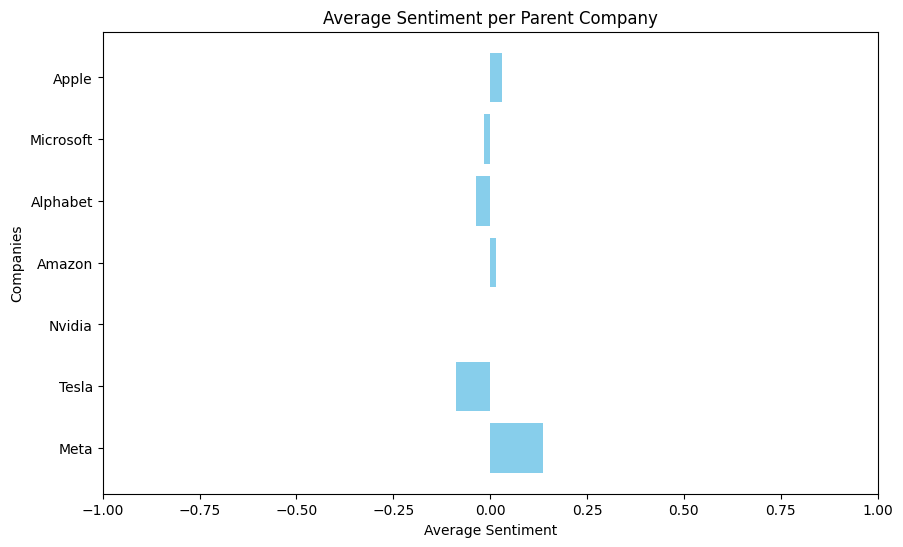

In [ ]:
visualize_average_sentiment(distilbert_neutral_average_sentiments)

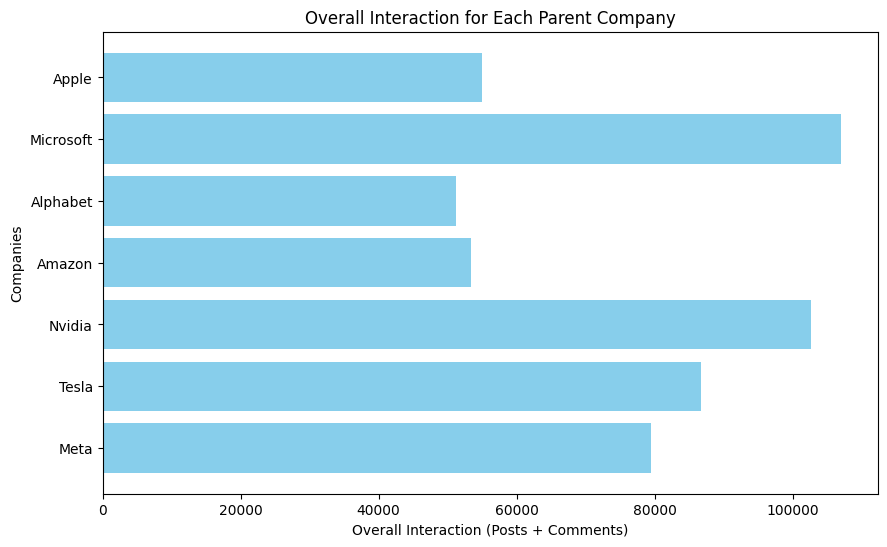

In [ ]:
visualize_overall_interaction(distilbert_neutral_interactions)

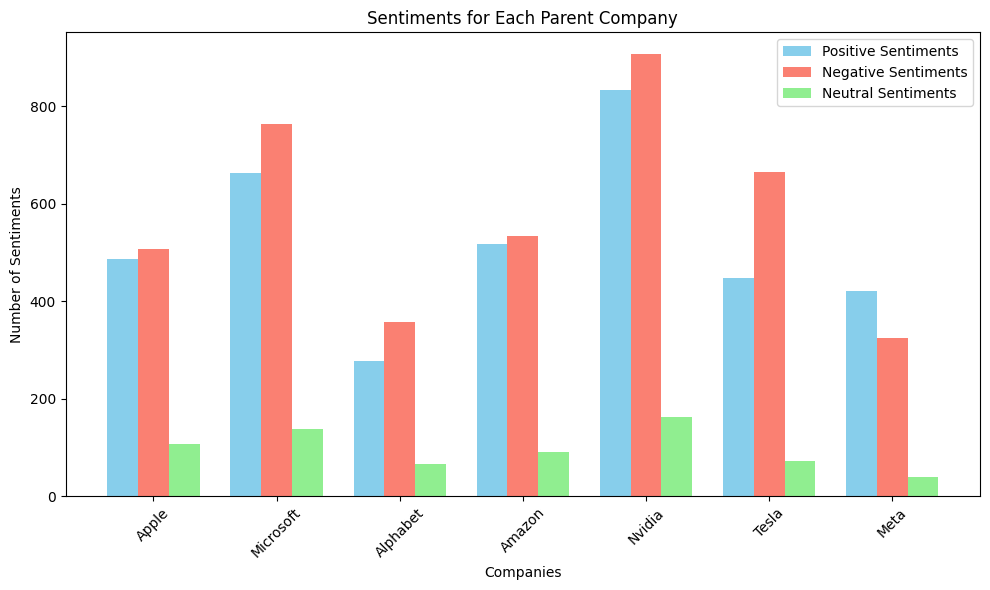

In [ ]:
visualize_sentiments(distilbert_neutral_positive_sentiments, distilbert_neutral_negative_sentiments, distilbert_neutral_neutral_sentiments)

### Write/read csv functions for parent company average sentiment score, interactions, positive, negative, and neutral sentiment scores

In [ ]:
write_company_sentiments_to_csv(data=distilbert_neutral_average_sentiments,
                                interactions=distilbert_neutral_interactions,
                                positive_sentiments=distilbert_neutral_positive_sentiments,
                                negative_sentiments=distilbert_neutral_negative_sentiments,
                                neutral_sentiments=distilbert_neutral_neutral_sentiments,
                                csv_filename="distilbert_neutral_results.csv")

# Deploying to Hugging Face

## Accessing inference endpoints

In [ ]:
API_URL = "https://wk6x4kfrdikhsi0n.us-east-1.aws.endpoints.huggingface.cloud"
headers = {
	"Accept" : "application/json",
	"Authorization": "Bearer " + userdata.get("HF_TOKEN_READ"),
	"Content-Type": "application/json"
}

In [ ]:
def query(payload):
	response = requests.post(API_URL, headers=headers, json=payload)
	return response.json()

In [ ]:
output = query(
{
	"inputs": [""],
	"parameters": {}
})

output

[{'label': 'positive', 'score': 0.5004075765609741}]

## Creating paths

In [ ]:
# create deploy path
reddit_sentiment_analysis_path = Path("deploy/reddit_sentiment_analysis/")

# remove files that might already exist and create new directory
if reddit_sentiment_analysis_path.exists():
  shutil.rmtree(reddit_sentiment_analysis_path)
  reddit_sentiment_analysis_path.mkdir(parents=True, # make the parent folders?
                                       exist_ok=True) # create it even if it already exists?
else:
  reddit_sentiment_analysis_path.mkdir(parents=True, # make the parent folders?
                                       exist_ok=True) # create it even if it already exists?

# check what's in the folder
!ls deploy/reddit_sentiment_analysis/

In [ ]:
write_subsidary_parent_company_csv(magnificent_seven, "subsidiary_parent.csv")

In [ ]:
write_parent_company_keywords_csv(magnificent_seven_keywords, "parent_keywords.csv")

In [ ]:
subreddits_csv_path = Path("deploy/reddit_sentiment_analysis/subreddits_passed_topic_classifier.csv/")
subsidiaries_csv_path = Path("deploy/reddit_sentiment_analysis/subsidiary_parent.csv/")
keywords_csv_path = Path("deploy/reddit_sentiment_analysis/parent_keywords.csv/")

!git clone https://github.com/gulnuravci/reddit_sentiment_analysis

!cp "reddit_sentiment_analysis/apr 19, 2024 data/subreddits_passed_topic_classifier.csv" .
!cp "reddit_sentiment_analysis/subsidiary_parent.csv" .
!cp "reddit_sentiment_analysis/parent_keywords.csv" .

if not subreddits_csv_path.exists():
  shutil.copy2(src="subreddits_passed_topic_classifier.csv", dst=subreddits_csv_path)
if not subsidiaries_csv_path.exists():
  shutil.copy2(src="subsidiary_parent.csv", dst=subsidiaries_csv_path)
if not keywords_csv_path.exists():
  shutil.copy2(src="parent_keywords.csv", dst=keywords_csv_path)

!rm -rf reddit_sentiment_analysis

Cloning into 'reddit_sentiment_analysis'...
remote: Enumerating objects: 50, done.
remote: Counting objects: 100% (50/50), done.
remote: Compressing objects: 100% (47/47), done.
remote: Total 50 (delta 8), reused 0 (delta 0), pack-reused 0
Receiving objects: 100% (50/50), 1.08 MiB | 6.77 MiB/s, done.
Resolving deltas: 100% (8/8), done.


In [ ]:
!ls deploy/reddit_sentiment_analysis/

## Writing scripts for demo

In [ ]:
%%writefile deploy/reddit_sentiment_analysis/helper.py
import asyncpraw
import asyncio
import re
import csv
import matplotlib.pyplot as plt
import requests
import asyncprawcore
import os
import ast

from typing import List, Dict, Any
from collections import defaultdict
from asyncpraw.models import MoreComments, Submission
from tqdm import tqdm
from huggingface_hub import InferenceClient, login

def get_access_to_reddit(user_agent="financial sentiment analysis project (research phase) (by u/ditalinianalysis)"):
  reddit = asyncpraw.Reddit(
      client_id=os.getenv("REDDIT_CLIENT_ID"),
      client_secret=os.getenv("REDDIT_SECRET"),
      user_agent=user_agent
      )
  return reddit

def get_write_access_to_hf():
  login(token=os.getenv("HF_TOKEN_WRITE"), write_permission=True)

async def search_subreddits_by_keyword_in_name_or_description(reddit, search_string: str) -> List[asyncpraw.models.Subreddit]:
  """
  search(query: str, **generator_kwargs: str | int | Dict[str, str])→ AsyncIterator[asyncpraw.models.Subreddit]
  Return a ListingGenerator of subreddits matching query. Additional keyword arguments are passed in the initialization of ListingGenerator.
  Subreddits are searched by both their title and description.
  Parameters:
  query – The query string to filter subreddits by.
  """
  subs = []
  async for subreddit in reddit.subreddits.search(search_string):
    subs.append(subreddit)
  return subs

async def filter_subreddits_by_keywords(subreddits: List[asyncpraw.models.Subreddit], keywords: List[str], min_keyword_count: int = 2) -> List[asyncpraw.models.Subreddit]:
  filtered_subreddits = []

  for subreddit in subreddits:
      title = subreddit.title.lower()
      description = subreddit.description.lower() if subreddit.description else ""


      # Check if the subreddit contains a minimum number of keywords
      keyword_count = sum(keyword.lower() in title or keyword.lower() in description for keyword in keywords)
      if keyword_count >= min_keyword_count:
          filtered_subreddits.append(subreddit)

  return filtered_subreddits

def get_subreddits_name_title_description(subreddits: List[asyncpraw.models.Subreddit]) -> Dict[asyncpraw.models.Subreddit,str]:
  subreddit_name_title_descriptions = {}
  for subreddit in subreddits:
    name = subreddit.display_name
    title = subreddit.title
    description = subreddit.description if subreddit.description else ""
    text = "Name:" + name + "\nTitle: " + title + "\nDescription: " + description
    subreddit_name_title_descriptions[subreddit] = text[:512]
  return subreddit_name_title_descriptions


def process_output(output):
  """Process output from subreddit topic classifier."""
  result_dict = {'TECHNOLOGY RELATED': 0.0, 'NOT TECHNOLOGY RELATED': 0.0}

  for prediction in output:
    label = prediction['label']
    score = prediction['score']

    if label == 'TECHNOLOGY RELATED':
        result_dict['TECHNOLOGY RELATED'] = score
    elif label == 'NOT TECHNOLOGY RELATED':
        result_dict['NOT TECHNOLOGY RELATED'] = score

  return result_dict

async def probe_subs_for_posts(subs: List[str],
                                num_posts: int,
                                time_filter: str = "day"):
  """
  Iterate through selected subreddits, retrieve a specified number of top posts from each subreddit,
  sort the comments for each post and pick the top few comments along with some of its replies,
  and store the posts.
  Args:
      subs (List[str]): A list of subreddit names to probe for posts.
      num_posts (int): The number of top posts to retrieve from each subreddit.
      time_filter (str, optional): The time period to filter posts by. Default is "day".
          Possible values: "all", "day", "hour", "month", "week", "year".
  Returns:
      defaultdict: A defaultdict where keys are subreddit names and values are lists of
      top posts retrieved from each subreddit.
  """
  # key -> subreddit, value -> list of posts
  posts = defaultdict(list)
  failed_subreddits = []
  # for each subreddit
  for sub in subs:
    try:
      async for submission in sub.top(limit=num_posts, time_filter=time_filter):
        posts[sub].append(submission)
    except Exception as e:
      print(f"Error processing posts from subreddit {sub.display_name}")
      failed_subreddits.append(sub.display_name)
  return posts, failed_subreddits

def default_dict_list():
  return defaultdict(list)

def default_dict_dict_list():
  return defaultdict(default_dict_list)

def default_dict_dict_dict_list():
  return defaultdict(default_dict_dict_list)

async def probe_submissions_for_comments(submission: asyncpraw.models.Submission,
                                         num_comments: int,
                                         sort_type: str) -> List[asyncpraw.models.Comment]:
  """
  Retrieve comments from a Reddit submission and return a list of comments.
  Args:
      submission (asyncpraw.models.Submission): The Reddit submission object.
      num_comments (int): The number of comments to retrieve.
      sort_type (str): The sorting type for comments.
          Possible values: 'confidence', 'top', 'new', 'controversial', 'old', 'random', 'qa'.
  Returns:
      List[asyncpraw.models.Comment]: A list of comment objects retrieved from the submission.
  Note:
      - This function sorts the comments based on the specified sort_type.
      - If there are 'MoreComments' objects encountered, they are skipped.
  """
  comments_list = []
  submission.comment_sort = sort_type
  submission.comment_limit = num_comments
  await submission.load()

  comments = await submission.comments()
  comments.replace_more(limit=None)
  all_comments = comments.list()
  for comment in all_comments:
    if isinstance(comment, MoreComments):
      continue
    comments_list.append(comment)
  return comments_list

def results_str_to_dict(input_results):
  for key, value in input_results.items():
    if type(value) == int: continue
    elif not value.isdigit() and "{" in value:
      start_index = value.find("{")
      end_index = value.find("}")
      substring = value[start_index:end_index+1]
      converted_value = ast.literal_eval(substring)
      # print("substring:", substring)
      # print("type(converted_value):", type(converted_value))
      input_results[key] = converted_value
    elif value.isdigit():
      input_results[key] = int(value)
  return input_results

In [ ]:
%%writefile deploy/reddit_sentiment_analysis/app.py

import asyncpraw
import asyncio
import csv
import matplotlib.pyplot as plt
import requests
import asyncprawcore
import time
import os
import pandas as pd
import numpy as np
import gradio as gr

from pathlib import Path
from typing import List, Dict, Any
from collections import defaultdict
from asyncpraw.models import MoreComments, Submission
from tqdm import tqdm
from huggingface_hub import InferenceClient, notebook_login
from datetime import datetime, timedelta
from datasets import load_dataset
from helper import get_access_to_reddit, get_write_access_to_hf, search_subreddits_by_keyword_in_name_or_description, filter_subreddits_by_keywords, get_subreddits_name_title_description, process_output, probe_subs_for_posts, default_dict_dict_dict_list, probe_submissions_for_comments, results_str_to_dict

async def main_async():
  results = {}
  reddit = get_access_to_reddit()

  # -- read in files --
  print("reading in files...")

  # read in subreddits csv and convert the display names column to a set
  subreddits_csv_df = pd.read_csv("subreddits_passed_topic_classifier.csv")
  subreddits_display_names_set = set(subreddits_csv_df["Display Name"])

  # read in csvs that store subsidiaries and keywords for each parent company
  subsidiaries_csv_df = pd.read_csv("subsidiary_parent.csv")
  subsidiary_parent_dict = defaultdict(list)
  for subsidiary, parent in zip(subsidiaries_csv_df["Subsidiary"], subsidiaries_csv_df["Parent Company"]):
    subsidiary_parent_dict[parent].append(subsidiary)

  keywords_csv_df = pd.read_csv("parent_keywords.csv")
  parent_keywords_dict = dict(zip(keywords_csv_df["Parent Company"], keywords_csv_df["Keywords"]))

  # -- extract subreddits using keywords technique --
  print("extracting subreddits using keywords technique...")

  # company is the key and associated subreddits as a list of subreddit objects
  subreddits_to_include = {}
  # count how many subreddits were originally extracted
  all_sub_count = 0
  # for each index, company name of the seven companies
  for parent, subsidiaries in subsidiary_parent_dict.items():
    for subsidiary in subsidiaries:
      # get all the subreddits that have that company name in the title or description
      all_subreddits_for_company = await search_subreddits_by_keyword_in_name_or_description(reddit, subsidiary)
      # increment total subreddit count by how many subreddits were extracted
      all_sub_count += len(all_subreddits_for_company)
      # further filter these subreddits based on how many keywords associated with the current company they contain
      filtered_subreddits = await filter_subreddits_by_keywords(subreddits=all_subreddits_for_company,
                                                                keywords=parent_keywords_dict[parent],
                                                                min_keyword_count=1)
      # store filtered subsidiary/parent company subreddits at appropriate key
      subreddits_to_include[parent] = filtered_subreddits

  results["Num subreddits with subsidiary/parent company name in its name or description"] = all_sub_count
  results["Num subreddits after using keywords filter"] = sum([len(company_subreddits) for company_subreddits in subreddits_to_include.values()])

  # -- pass new subreddits through classifier to determine if they are technology related --
  print("passing new subreddits through classifier to determine if they are technology related...")

  topic_classifier_client = InferenceClient(model="gulnuravci/subreddit_description_topic_classifier", token=os.getenv("HF_TOKEN_READ"))

  # key is the parent company and the value is a list of subreddit objects that are technology related
  subreddits_passed_topic_classifier = defaultdict(list)
  # count new subreddits
  num_companies_through_model = 0
  # for each company key in the subreddits to include (based on keyword filtering) dictionary
  for company, subreddits_list in tqdm(subreddits_to_include.items()):
    # get a dictionary where the key is the subreddit object and value is text format of the company's name, title, and description
    name_title_descriptions = get_subreddits_name_title_description(subreddits_to_include[company])
    # for each subreddit under the current company
    for subreddit_object, subreddit_description in name_title_descriptions.items():
      # if subreddit is not new, skip inference
      if subreddit_object.display_name in subreddits_display_names_set:
        subreddits_passed_topic_classifier[company].append(subreddit_object)
        continue

      # pass the subreddit's description through the subreddit topic classifier
      output = topic_classifier_client.text_classification(subreddit_description)

      # process output
      output = process_output(output)

      # if technology related
      if output['TECHNOLOGY RELATED'] > output['NOT TECHNOLOGY RELATED']:
        subreddits_passed_topic_classifier[company].append(subreddit_object)

      num_companies_through_model += 1
    # time.sleep(10)
  parent_company_counts = {parent_company: len(subreddits) for parent_company, subreddits in subreddits_passed_topic_classifier.items()}

  results["Num old subreddits that were automatically included"] = len(subreddits_display_names_set)
  results["Num subreddits that ran through the model"] = num_companies_through_model
  results["Total subreddits that are technology related (including old and new subreddits)"] = sum([len(items) for items in subreddits_passed_topic_classifier.values()])
  results["Num subreddits that were included per parent company"] = parent_company_counts

  # -- get posts from subreddits --
  print("getting posts from subreddits...")

  parent_company_posts = {}
  parent_company_post_counts = {}
  failed_subreddits = defaultdict(list)
  for parent_company, subreddits in tqdm(subreddits_passed_topic_classifier.items()):
    # get X amount of posts from each of the subreddits associated with the current parent company
    current_parent_company_posts, current_failed_subreddits = await probe_subs_for_posts(subreddits, num_posts=1)
    # store failed subreddits
    failed_subreddits[parent_company].extend(current_failed_subreddits)
    # add key -> parent company, value -> dictionary where key is subreddit object and value is list of submission objects
    parent_company_posts[parent_company] = current_parent_company_posts
    # count how many posts are added per parent company
    parent_company_post_counts[parent_company] = sum(len(value) for key, value in current_parent_company_posts.items())
    # time.sleep(20)

  results["Num of posts extracted for each parent company"] = parent_company_post_counts
  results["Failed subreddits while extracting posts"] = failed_subreddits

  # -- get comments from posts --
  print("getting comments from posts...")

  post_comments = default_dict_dict_dict_list()
  post_comment_counts = defaultdict(int)
  for parent_company, subreddit_dict in tqdm(parent_company_posts.items()):
    for subreddit, posts in subreddit_dict.items():
      for post in posts:
        # get X relevant comments
        comments = await probe_submissions_for_comments(submission = post,
                                                        num_comments = 1,
                                                        sort_type = "best")
        post_comments[parent_company][subreddit][post] = comments
        post_comment_counts[parent_company] += len(comments)
    #     time.sleep(1)
      time.sleep(5)
    # time.sleep(20)

  results["Num of comments extracted for each parent company"] = post_comment_counts
  post_comments_save = post_comments
  return results, post_comments

def main(results, post_comments):
  # -- run posts and comments through sentiment analysis --
  print("running posts and comments through sentiment analysis...")

  API_URL = "https://wk6x4kfrdikhsi0n.us-east-1.aws.endpoints.huggingface.cloud"
  headers = {
    "Accept" : "application/json",
    "Authorization": "Bearer " + os.getenv("HF_TOKEN_READ"),
    "Content-Type": "application/json"
  }

  def query(payload):
    response = requests.post(API_URL, headers=headers, json=payload)
    return response.json()

  query({
      "inputs": "testing economy is great",
      "parameters": {}
  })
  time.sleep(20)

  query({
      "inputs": "testing economy sucks",
      "parameters": {}
  })
  time.sleep(20)

  sentiments = defaultdict(list)
  interactions = defaultdict(int)
  neutral_sentiments = defaultdict(int)
  positive_sentiments = defaultdict(int)
  negative_sentiments = defaultdict(int)

  for parent_company, subreddit_dict in tqdm(post_comments.items()):
    for subreddit, posts in subreddit_dict.items():
      for post, comments in posts.items():
        total_interaction = 0
        sentiment_weights = 0
        post_text = post.title + post.selftext

        post_sentiment = query(
        {
          "inputs": post_text[:512],
          "parameters": {}
        })

        if not post_sentiment: continue

        # if the highest score is neutral
        if post_sentiment[0]['label'] == 'neutral':
          post_sentiment = 0
          neutral_sentiments[parent_company] += 1
        # if the highest score is positive
        elif post_sentiment[0]['label'] == 'positive':
          post_sentiment = post_sentiment[0]['score']
          positive_sentiments[parent_company] += 1
        # if the highest score is negative
        elif post_sentiment[0]['label'] == 'negative':
          post_sentiment = -post_sentiment[0]['score']
          negative_sentiments[parent_company] += 1

        post_upvote_ratio = post.upvote_ratio

        total_interaction += post_upvote_ratio

        sentiment_weights += post_upvote_ratio * post_sentiment

        for comment in comments:
          comment_sentiment = query(
          {
            "inputs": comment.body[:512],
            "parameters": {}
          })
          print("post sentiment:", post_sentiment)
          if not comment_sentiment: continue

          # if comment score is neutral
          if comment_sentiment[0]['label'] == 'neutral':
            comment_sentiment = 0
            neutral_sentiments[parent_company] += 1
          # if comment score is positive
          elif comment_sentiment[0]['label'] == 'positive':
            comment_sentiment = comment_sentiment[0]['score']
            positive_sentiments[parent_company] += 1
          # if comment score is negative
          elif comment_sentiment[0]['label'] == 'negative':
            comment_sentiment = -comment_sentiment[0]['score']
            negative_sentiments[parent_company] += 1

          comment_score = comment.score

          total_interaction += comment_score
          sentiment_weights += comment_score * comment_sentiment

        if total_interaction:
          total_sentiment = sentiment_weights/total_interaction
        else:
          total_sentiment = 0
        sentiments[parent_company].append(total_sentiment)
        interactions[parent_company] += total_interaction

  results["Num of interactions for each parent company"] = interactions
  results["Num of neutral sentiments for each parent company"] = neutral_sentiments
  results["Num of positive sentiments for each parent company"] = positive_sentiments
  results["Num of negative sentiments for each parent company"] = negative_sentiments

  # -- calculate average sentiments --
  print("calculating average sentiments...")
  average_sentiments = {}
  for parent_company, sentiment_values in sentiments.items():
    average_sentiments[parent_company] = sum(sentiment_values)/len(sentiment_values)

  average_sentiments

  results["Average sentiment for each parent company"] = average_sentiments

  print("returning results...")
  return results

def plot_results(results):
  color_map = {
      'Apple': 'lightgray',
      'Microsoft': 'deepskyblue',
      'Alphabet': 'yellow',
      'Amazon': 'orange',
      'Nvidia': 'limegreen',
      'Tesla': 'red',
      'Meta': 'royalblue'
  }
  fig, axs = plt.subplots(figsize=(8, 6))
  for company, num_subs in results["Num subreddits that were included per parent company"].items():
    plt.barh(company, num_subs, color=color_map.get(company, 'gray'))
  axs.set_title('Number of Subreddits per Parent Company')
  axs.set_xlabel('Number of Technology Related Subreddits')
  plt.tight_layout()
  plt.savefig("results_num_subs.png")

  fig, axs = plt.subplots(figsize=(8, 6))
  for company, num_posts in results["Num of posts extracted for each parent company"].items():
    axs.barh(company, num_posts, color=color_map.get(company, 'gray'))
  axs.set_title('Number of Posts Extracted per Parent Company')
  axs.set_xlabel('Number of Posts')
  plt.tight_layout()
  plt.savefig("results_num_posts.png")

  fig, axs = plt.subplots(figsize=(8, 6))
  for company, num_comments in results["Num of comments extracted for each parent company"].items():
    axs.barh(company, num_comments, color=color_map.get(company, 'gray'))
  axs.set_title('Number of Comments Extracted per Parent Company')
  axs.set_xlabel('Number of Comments')
  plt.tight_layout()
  plt.savefig("results_num_comments.png")

  fig, axs = plt.subplots(figsize=(8, 6))
  for company, num_interactions in results["Num of interactions for each parent company"].items():
    axs.barh(company, num_interactions, color=color_map.get(company, 'gray'))
  axs.set_title('Number of Interactions per Parent Company')
  axs.set_xlabel('Number of Interactions')
  plt.tight_layout()
  plt.savefig("results_num_interactions.png")

  fig, axs = plt.subplots(figsize=(8, 6))
  for company, num_interactions in results["Average sentiment for each parent company"].items():
    axs.barh(company, num_interactions, color=color_map.get(company, 'gray'))
  axs.set_title('Average Sentiment per Parent Company')
  axs.set_xlabel('Average Sentiment')
  axs.set_xlim(-1, 1)  # Set the x-axis limits to range from -1 to 1
  plt.tight_layout()
  plt.savefig("results_average_sentiment.png")

  fig, axs = plt.subplots(figsize=(8, 6))
  bar_width = 0.25
  index = np.arange(7)

  companies = list(results["Num of positive sentiments for each parent company"].keys())
  positive_sentiments = [results["Num of positive sentiments for each parent company"][company] for company in companies]
  negative_sentiments = [results["Num of negative sentiments for each parent company"][company] for company in companies]
  neutral_sentiments = [results["Num of neutral sentiments for each parent company"][company] for company in companies]

  axs.bar(index, positive_sentiments, bar_width, label='Positive Sentiments', color='skyblue')
  axs.bar(index + bar_width, negative_sentiments, bar_width, label='Negative Sentiments', color='salmon')
  axs.bar(index + 2 * bar_width, neutral_sentiments, bar_width, label='Neutral Sentiments', color='lightgreen')

  axs.set_ylabel('Number of Sentiments')
  axs.set_title('Sentiment Distribution for Each Parent Company')
  axs.set_xticks(index + bar_width)
  axs.set_xticklabels(companies, rotation=45)
  axs.legend()
  plt.tight_layout()
  plt.savefig("results_sentiment_distribution.png")

def plot():
    # load results dataset from hugging face
    reddit_sentiment_analysis_results = load_dataset("gulnuravci/reddit_sentiment_analysis_results", split="train")

    # return latest results
    latest_results = reddit_sentiment_analysis_results[-1]

    # convert string datetime to datetime object
    latest_results_datetime = datetime.strptime(reddit_sentiment_analysis_results[-1]['Datetime'], "%Y-%m-%d %H:%M:%S")

    # get current time
    current_datetime = datetime.now()

    # calculate the time difference between the current datetime and the datetime of the last entry
    time_difference = current_datetime - latest_results_datetime

    print("time_difference > timedelta(hours=24):", time_difference > timedelta(hours=24))

    # check if the time difference is greater than 24 hours
    if time_difference < timedelta(hours=24):
        results = results_str_to_dict(latest_results)
    else:
        # define an asynchronous function to fetch today's results
        async def fetch_todays_results():
            async_results, post_comments = await main_async()
            return main(async_results, post_comments)
        # run the asynchronous function and wait for the results
        todays_results = asyncio.run(fetch_todays_results())
        # add datetime to results
        todays_results["Datetime"] = current_datetime.strftime("%Y-%m-%d %H:%M:%S")
        # convert non string values to string
        todays_results = {key: str(value) for key, value in todays_results.items()}
        # add results to dataset
        reddit_sentiment_analysis_results = reddit_sentiment_analysis_results.add_item(todays_results)
        # get write permission to hugging face
        get_write_access_to_hf()
        # push to hugging face
        reddit_sentiment_analysis_results.push_to_hub("gulnuravci/reddit_sentiment_analysis_results")
        # convert string results to dict
        results = results_str_to_dict(todays_results)

    plot_results(results)
    return "results_num_subs.png", "results_num_posts.png", "results_num_comments.png", "results_num_interactions.png", "results_average_sentiment.png", "results_sentiment_distribution.png"

def launch_gradio_app():
  # gradio app launch
  title = "Reddit Sentiment Analysis"
  description = ""
  article = "Read more at: "

  demo = gr.Interface(plot,
                      inputs=None,
                      outputs=[gr.Gallery(label="Today", columns=[3,2])],
                      title=title,
                      description=description,
                      article=article)
  demo.launch()

launch_gradio_app()

In [ ]:
%%writefile deploy/reddit_sentiment_analysis/requirements.txt
gradio>=3.1.4
asyncpraw >= 7.7.1

Overwriting deploy/reddit_sentiment_analysis/requirements.txt


In [ ]:
!ls deploy/reddit_sentiment_analysis/

app.py	   parent_keywords.csv	subreddits_passed_topic_classifier.csv
helper.py  requirements.txt	subsidiary_parent.csv


In [ ]:
# Change into and then zip the spongebob_character_identifier folder but exclude certain files
!cd deploy/reddit_sentiment_analysis/ && zip -r ../reddit_sentiment_analysis.zip * -x "*.pyc" "*.ipynb" "*__pycache__*" "*ipynb_checkpoints*"

# Download the zipped app
try:
  from google.colab import files
  files.download("deploy/reddit_sentiment_analysis.zip")
except:
  print("Not running in Google Colab, can't use google.colab.files.download(), please manually download.")

updating: app.py (deflated 75%)
updating: helper.py (deflated 65%)
updating: parent_keywords.csv (deflated 53%)
updating: requirements.txt (stored 0%)
updating: subreddits_passed_topic_classifier.csv (deflated 57%)
updating: subsidiary_parent.csv (deflated 37%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Testing before deployment

In [133]:
import asyncpraw
import asyncio
import re
import csv
import matplotlib.pyplot as plt
import requests
import asyncprawcore
import os
import ast

from typing import List, Dict, Any
from collections import defaultdict
from asyncpraw.models import MoreComments, Submission
from tqdm import tqdm
from huggingface_hub import InferenceClient, login

def get_access_to_reddit(user_agent="financial sentiment analysis project (research phase) (by u/ditalinianalysis)"):
  reddit = asyncpraw.Reddit(
      client_id=userdata.get("client_id"),
      client_secret=userdata.get("secret"),
      user_agent=user_agent
      )
  return reddit

def get_write_access_to_hf():
  login(token=userdata.get("HF_TOKEN_WRITE"), write_permission=True)

async def search_subreddits_by_keyword_in_name_or_description(reddit, search_string: str) -> List[asyncpraw.models.Subreddit]:
  """
  search(query: str, **generator_kwargs: str | int | Dict[str, str])→ AsyncIterator[asyncpraw.models.Subreddit]
  Return a ListingGenerator of subreddits matching query. Additional keyword arguments are passed in the initialization of ListingGenerator.
  Subreddits are searched by both their title and description.
  Parameters:
  query – The query string to filter subreddits by.
  """
  subs = []
  async for subreddit in reddit.subreddits.search(search_string):
    subs.append(subreddit)
  return subs

async def filter_subreddits_by_keywords(subreddits: List[asyncpraw.models.Subreddit], keywords: List[str], min_keyword_count: int = 2) -> List[asyncpraw.models.Subreddit]:
  filtered_subreddits = []

  for subreddit in subreddits:
      title = subreddit.title.lower()
      description = subreddit.description.lower() if subreddit.description else ""


      # Check if the subreddit contains a minimum number of keywords
      keyword_count = sum(keyword.lower() in title or keyword.lower() in description for keyword in keywords)
      if keyword_count >= min_keyword_count:
          filtered_subreddits.append(subreddit)

  return filtered_subreddits

def get_subreddits_name_title_description(subreddits: List[asyncpraw.models.Subreddit]) -> Dict[asyncpraw.models.Subreddit,str]:
  subreddit_name_title_descriptions = {}
  for subreddit in subreddits:
    name = subreddit.display_name
    title = subreddit.title
    description = subreddit.description if subreddit.description else ""
    text = "Name:" + name + "\nTitle: " + title + "\nDescription: " + description
    subreddit_name_title_descriptions[subreddit] = text[:512]
  return subreddit_name_title_descriptions


def process_output(output):
  """Process output from subreddit topic classifier."""
  result_dict = {'TECHNOLOGY RELATED': 0.0, 'NOT TECHNOLOGY RELATED': 0.0}

  for prediction in output:
    label = prediction['label']
    score = prediction['score']

    if label == 'TECHNOLOGY RELATED':
        result_dict['TECHNOLOGY RELATED'] = score
    elif label == 'NOT TECHNOLOGY RELATED':
        result_dict['NOT TECHNOLOGY RELATED'] = score

  return result_dict

async def probe_subs_for_posts(subs: List[str],
                                num_posts: int,
                                time_filter: str = "day"):
  """
  Iterate through selected subreddits, retrieve a specified number of top posts from each subreddit,
  sort the comments for each post and pick the top few comments along with some of its replies,
  and store the posts.
  Args:
      subs (List[str]): A list of subreddit names to probe for posts.
      num_posts (int): The number of top posts to retrieve from each subreddit.
      time_filter (str, optional): The time period to filter posts by. Default is "day".
          Possible values: "all", "day", "hour", "month", "week", "year".
  Returns:
      defaultdict: A defaultdict where keys are subreddit names and values are lists of
      top posts retrieved from each subreddit.
  """
  # key -> subreddit, value -> list of posts
  posts = defaultdict(list)
  failed_subreddits = []
  # for each subreddit
  for sub in subs:
    try:
      async for submission in sub.top(limit=num_posts, time_filter=time_filter):
        posts[sub].append(submission)
    except Exception as e:
      print(f"Error processing posts from subreddit {sub.display_name}")
      failed_subreddits.append(sub.display_name)
  return posts, failed_subreddits

def default_dict_list():
  return defaultdict(list)

def default_dict_dict_list():
  return defaultdict(default_dict_list)

def default_dict_dict_dict_list():
  return defaultdict(default_dict_dict_list)

async def probe_submissions_for_comments(submission: asyncpraw.models.Submission,
                                         num_comments: int,
                                         sort_type: str) -> List[asyncpraw.models.Comment]:
  """
  Retrieve comments from a Reddit submission and return a list of comments.
  Args:
      submission (asyncpraw.models.Submission): The Reddit submission object.
      num_comments (int): The number of comments to retrieve.
      sort_type (str): The sorting type for comments.
          Possible values: 'confidence', 'top', 'new', 'controversial', 'old', 'random', 'qa'.
  Returns:
      List[asyncpraw.models.Comment]: A list of comment objects retrieved from the submission.
  Note:
      - This function sorts the comments based on the specified sort_type.
      - If there are 'MoreComments' objects encountered, they are skipped.
  """
  comments_list = []
  submission.comment_sort = sort_type
  submission.comment_limit = num_comments
  await submission.load()

  comments = await submission.comments()
  comments.replace_more(limit=None)
  all_comments = comments.list()
  for comment in all_comments:
    if isinstance(comment, MoreComments):
      continue
    comments_list.append(comment)
  return comments_list

def results_str_to_dict(input_results):
  for key, value in input_results.items():
    if type(value) == int: continue
    elif not value.isdigit() and "{" in value:
      start_index = value.find("{")
      end_index = value.find("}")
      substring = value[start_index:end_index+1]
      converted_value = ast.literal_eval(substring)
      # print("substring:", substring)
      # print("type(converted_value):", type(converted_value))
      input_results[key] = converted_value
    elif value.isdigit():
      input_results[key] = int(value)
  return input_results

In [9]:

import asyncpraw
import asyncio
import csv
import matplotlib.pyplot as plt
import requests
import asyncprawcore
import time
import os
import pandas as pd
import numpy as np

from pathlib import Path
from typing import List, Dict, Any
from collections import defaultdict
from asyncpraw.models import MoreComments, Submission
from tqdm import tqdm
from huggingface_hub import InferenceClient, notebook_login
from datetime import datetime, timedelta
from datasets import load_dataset
from helper import get_access_to_reddit, get_write_access_to_hf, search_subreddits_by_keyword_in_name_or_description, filter_subreddits_by_keywords, get_subreddits_name_title_description, process_output, probe_subs_for_posts, default_dict_dict_dict_list, probe_submissions_for_comments, results_str_to_dict

async def main_async():
  results = {}
  reddit = get_access_to_reddit()

  # -- read in files --
  print("reading in files...")

  # read in subreddits csv and convert the display names column to a set
  subreddits_csv_df = pd.read_csv("subreddits_passed_topic_classifier.csv")
  subreddits_display_names_set = set(subreddits_csv_df["Display Name"])

  # read in csvs that store subsidiaries and keywords for each parent company
  subsidiaries_csv_df = pd.read_csv("subsidiary_parent.csv")
  subsidiary_parent_dict = defaultdict(list)
  for subsidiary, parent in zip(subsidiaries_csv_df["Subsidiary"], subsidiaries_csv_df["Parent Company"]):
    subsidiary_parent_dict[parent].append(subsidiary)

  keywords_csv_df = pd.read_csv("parent_keywords.csv")
  parent_keywords_dict = dict(zip(keywords_csv_df["Parent Company"], keywords_csv_df["Keywords"]))

  # -- extract subreddits using keywords technique --
  print("extracting subreddits using keywords technique...")

  # company is the key and associated subreddits as a list of subreddit objects
  subreddits_to_include = {}
  # count how many subreddits were originally extracted
  all_sub_count = 0
  # for each index, company name of the seven companies
  for parent, subsidiaries in subsidiary_parent_dict.items():
    for subsidiary in subsidiaries:
      # get all the subreddits that have that company name in the title or description
      all_subreddits_for_company = await search_subreddits_by_keyword_in_name_or_description(reddit, subsidiary)
      # increment total subreddit count by how many subreddits were extracted
      all_sub_count += len(all_subreddits_for_company)
      # further filter these subreddits based on how many keywords associated with the current company they contain
      filtered_subreddits = await filter_subreddits_by_keywords(subreddits=all_subreddits_for_company,
                                                                keywords=parent_keywords_dict[parent],
                                                                min_keyword_count=1)
      # store filtered subsidiary/parent company subreddits at appropriate key
      subreddits_to_include[parent] = filtered_subreddits

  results["Num subreddits with subsidiary/parent company name in its name or description"] = all_sub_count
  results["Num subreddits after using keywords filter"] = sum([len(company_subreddits) for company_subreddits in subreddits_to_include.values()])

  # -- pass new subreddits through classifier to determine if they are technology related --
  print("passing new subreddits through classifier to determine if they are technology related...")

  topic_classifier_client = InferenceClient(model="gulnuravci/subreddit_description_topic_classifier", token=os.getenv("HF_TOKEN_READ"))

  # key is the parent company and the value is a list of subreddit objects that are technology related
  subreddits_passed_topic_classifier = defaultdict(list)
  # count new subreddits
  num_companies_through_model = 0
  # for each company key in the subreddits to include (based on keyword filtering) dictionary
  for company, subreddits_list in tqdm(subreddits_to_include.items()):
    # get a dictionary where the key is the subreddit object and value is text format of the company's name, title, and description
    name_title_descriptions = get_subreddits_name_title_description(subreddits_to_include[company])
    # for each subreddit under the current company
    for subreddit_object, subreddit_description in name_title_descriptions.items():
      # if subreddit is not new, skip inference
      if subreddit_object.display_name in subreddits_display_names_set:
        subreddits_passed_topic_classifier[company].append(subreddit_object)
        continue

      # pass the subreddit's description through the subreddit topic classifier
      output = topic_classifier_client.text_classification(subreddit_description)

      # process output
      output = process_output(output)

      # if technology related
      if output['TECHNOLOGY RELATED'] > output['NOT TECHNOLOGY RELATED']:
        subreddits_passed_topic_classifier[company].append(subreddit_object)

      num_companies_through_model += 1
    # time.sleep(10)
  parent_company_counts = {parent_company: len(subreddits) for parent_company, subreddits in subreddits_passed_topic_classifier.items()}

  results["Num old subreddits that were automatically included"] = len(subreddits_display_names_set)
  results["Num subreddits that ran through the model"] = num_companies_through_model
  results["Total subreddits that are technology related (including old and new subreddits)"] = sum([len(items) for items in subreddits_passed_topic_classifier.values()])
  results["Num subreddits that were included per parent company"] = parent_company_counts

  # -- get posts from subreddits --
  print("getting posts from subreddits...")

  parent_company_posts = {}
  parent_company_post_counts = {}
  failed_subreddits = defaultdict(list)
  for parent_company, subreddits in tqdm(subreddits_passed_topic_classifier.items()):
    # get X amount of posts from each of the subreddits associated with the current parent company
    current_parent_company_posts, current_failed_subreddits = await probe_subs_for_posts(subreddits, num_posts=1)
    # store failed subreddits
    failed_subreddits[parent_company].extend(current_failed_subreddits)
    # add key -> parent company, value -> dictionary where key is subreddit object and value is list of submission objects
    parent_company_posts[parent_company] = current_parent_company_posts
    # count how many posts are added per parent company
    parent_company_post_counts[parent_company] = sum(len(value) for key, value in current_parent_company_posts.items())
    # time.sleep(20)

  results["Num of posts extracted for each parent company"] = parent_company_post_counts
  results["Failed subreddits while extracting posts"] = failed_subreddits

  # -- get comments from posts --
  print("getting comments from posts...")

  post_comments = default_dict_dict_dict_list()
  post_comment_counts = defaultdict(int)
  for parent_company, subreddit_dict in tqdm(parent_company_posts.items()):
    for subreddit, posts in subreddit_dict.items():
      for post in posts:
        # get X relevant comments
        comments = await probe_submissions_for_comments(submission = post,
                                                        num_comments = 1,
                                                        sort_type = "best")
        post_comments[parent_company][subreddit][post] = comments
        post_comment_counts[parent_company] += len(comments)
    #     time.sleep(1)
      time.sleep(5)
    # time.sleep(20)

  results["Num of comments extracted for each parent company"] = post_comment_counts
  post_comments_save = post_comments
  return results, post_comments

def main(results, post_comments):
  # -- run posts and comments through sentiment analysis --
  print("running posts and comments through sentiment analysis...")

  API_URL = "https://wk6x4kfrdikhsi0n.us-east-1.aws.endpoints.huggingface.cloud"
  headers = {
    "Accept" : "application/json",
    "Authorization": "Bearer " + userdata.get("HF_TOKEN_READ"),
    "Content-Type": "application/json"
  }

  def query(payload):
    response = requests.post(API_URL, headers=headers, json=payload)
    return response.json()

  time.sleep(30)

  sentiments = defaultdict(list)
  interactions = defaultdict(int)
  neutral_sentiments = defaultdict(int)
  positive_sentiments = defaultdict(int)
  negative_sentiments = defaultdict(int)

  for parent_company, subreddit_dict in tqdm(post_comments.items()):
    for subreddit, posts in subreddit_dict.items():
      for post, comments in posts.items():
        total_interaction = 0
        sentiment_weights = 0
        post_text = post.title + post.selftext

        post_sentiment = query(
        {
          "inputs": post_text[:512],
          "parameters": {}
        })

        if not post_sentiment: continue

        # if the highest score is neutral
        if post_sentiment[0]['label'] == 'neutral':
          post_sentiment = 0
          neutral_sentiments[parent_company] += 1
        # if the highest score is positive
        elif post_sentiment[0]['label'] == 'positive':
          post_sentiment = post_sentiment[0]['score']
          positive_sentiments[parent_company] += 1
        # if the highest score is negative
        elif post_sentiment[0]['label'] == 'negative':
          post_sentiment = -post_sentiment[0]['score']
          negative_sentiments[parent_company] += 1

        post_upvote_ratio = post.upvote_ratio

        total_interaction += post_upvote_ratio

        sentiment_weights += post_upvote_ratio * post_sentiment

        for comment in comments:
          comment_sentiment = query(
          {
            "inputs": comment.body[:512],
            "parameters": {}
          })
          print("post sentiment:", post_sentiment)
          if not comment_sentiment: continue

          # if comment score is neutral
          if comment_sentiment[0]['label'] == 'neutral':
            comment_sentiment = 0
            neutral_sentiments[parent_company] += 1
          # if comment score is positive
          elif comment_sentiment[0]['label'] == 'positive':
            comment_sentiment = comment_sentiment[0]['score']
            positive_sentiments[parent_company] += 1
          # if comment score is negative
          elif comment_sentiment[0]['label'] == 'negative':
            comment_sentiment = -comment_sentiment[0]['score']
            negative_sentiments[parent_company] += 1

          comment_score = comment.score

          total_interaction += comment_score
          sentiment_weights += comment_score * comment_sentiment

        if total_interaction:
          total_sentiment = sentiment_weights/total_interaction
        else:
          total_sentiment = 0
        sentiments[parent_company].append(total_sentiment)
        interactions[parent_company] += total_interaction

  results["Num of interactions for each parent company"] = interactions
  results["Num of neutral sentiments for each parent company"] = neutral_sentiments
  results["Num of positive sentiments for each parent company"] = positive_sentiments
  results["Num of negative sentiments for each parent company"] = negative_sentiments

  # -- calculate average sentiments --
  print("calculating average sentiments...")
  average_sentiments = {}
  for parent_company, sentiment_values in sentiments.items():
    average_sentiments[parent_company] = sum(sentiment_values)/len(sentiment_values)

  average_sentiments

  results["Average sentiment for each parent company"] = average_sentiments

  print("returning results...")
  return results

def plot_results(results):
  color_map = {
      'Apple': 'lightgray',
      'Microsoft': 'deepskyblue',
      'Alphabet': 'yellow',
      'Amazon': 'orange',
      'Nvidia': 'limegreen',
      'Tesla': 'red',
      'Meta': 'royalblue'
  }
  fig, axs = plt.subplots(figsize=(8, 6))
  for company, num_subs in results["Num subreddits that were included per parent company"].items():
    plt.barh(company, num_subs, color=color_map.get(company, 'gray'))
  axs.set_title('Number of Subreddits per Parent Company')
  axs.set_xlabel('Number of Technology Related Subreddits')
  plt.tight_layout()
  plt.savefig("results_num_subs.png")

  fig, axs = plt.subplots(figsize=(8, 6))
  for company, num_posts in results["Num of posts extracted for each parent company"].items():
    axs.barh(company, num_posts, color=color_map.get(company, 'gray'))
  axs.set_title('Number of Posts Extracted per Parent Company')
  axs.set_xlabel('Number of Posts')
  plt.tight_layout()
  plt.savefig("results_num_posts.png")

  fig, axs = plt.subplots(figsize=(8, 6))
  for company, num_comments in results["Num of comments extracted for each parent company"].items():
    axs.barh(company, num_comments, color=color_map.get(company, 'gray'))
  axs.set_title('Number of Comments Extracted per Parent Company')
  axs.set_xlabel('Number of Comments')
  plt.tight_layout()
  plt.savefig("results_num_comments.png")

  fig, axs = plt.subplots(figsize=(8, 6))
  for company, num_interactions in results["Num of interactions for each parent company"].items():
    axs.barh(company, num_interactions, color=color_map.get(company, 'gray'))
  axs.set_title('Number of Interactions per Parent Company')
  axs.set_xlabel('Number of Interactions')
  plt.tight_layout()
  plt.savefig("results_num_interactions.png")

  fig, axs = plt.subplots(figsize=(8, 6))
  for company, num_interactions in results["Average sentiment for each parent company"].items():
    axs.barh(company, num_interactions, color=color_map.get(company, 'gray'))
  axs.set_title('Average Sentiment per Parent Company')
  axs.set_xlabel('Average Sentiment')
  axs.set_xlim(-1, 1)  # Set the x-axis limits to range from -1 to 1
  plt.tight_layout()
  plt.savefig("results_average_sentiment.png")

  fig, axs = plt.subplots(figsize=(8, 6))
  bar_width = 0.25
  index = np.arange(7)

  companies = list(results["Num of positive sentiments for each parent company"].keys())
  positive_sentiments = [results["Num of positive sentiments for each parent company"][company] for company in companies]
  negative_sentiments = [results["Num of negative sentiments for each parent company"][company] for company in companies]
  neutral_sentiments = [results["Num of neutral sentiments for each parent company"][company] for company in companies]

  axs.bar(index, positive_sentiments, bar_width, label='Positive Sentiments', color='skyblue')
  axs.bar(index + bar_width, negative_sentiments, bar_width, label='Negative Sentiments', color='salmon')
  axs.bar(index + 2 * bar_width, neutral_sentiments, bar_width, label='Neutral Sentiments', color='lightgreen')

  axs.set_ylabel('Number of Sentiments')
  axs.set_title('Sentiment Distribution for Each Parent Company')
  axs.set_xticks(index + bar_width)
  axs.set_xticklabels(companies, rotation=45)
  axs.legend()
  plt.tight_layout()
  plt.savefig("results_sentiment_distribution.png")

def plot():
  return "results_num_subs.png", "results_num_posts.png", "results_num_comments.png", "results_num_interactions.png", "results_average_sentiment.png", "results_sentiment_distribution.png"

def launch_gradio_app():
  # gradio app launch
  title = "Reddit Sentiment Analysis"
  description = ""
  article = "Read more at: "

  demo = gr.Interface(plot,
                      inputs=None,
                      outputs=[gr.Gallery(label="Today", columns=[3,2])],
                      title=title,
                      description=description,
                      article=article)
  demo.launch()


# load results dataset from hugging face
reddit_sentiment_analysis_results = load_dataset("gulnuravci/reddit_sentiment_analysis_results", split="train")

# return latest results
latest_results = reddit_sentiment_analysis_results[-1]

# convert string datetime to datetime object
latest_results_datetime = datetime.strptime(reddit_sentiment_analysis_results[-1]['Datetime'], "%Y-%m-%d %H:%M:%S")

# get current time
current_datetime = datetime.now()

# calculate the time difference between the current datetime and the datetime of the last entry
time_difference = current_datetime - latest_results_datetime

print("time_difference > timedelta(hours=24):", time_difference > timedelta(hours=24))

# check if the time difference is greater than 24 hours
if time_difference > timedelta(hours=24) or True:
    results = results_str_to_dict(latest_results)
else:
    # define an asynchronous function to fetch today's results
    async def fetch_todays_results():
        async_results, post_comments = await main_async()
        return main(async_results, post_comments)
    # run the asynchronous function and wait for the results
    todays_results = asyncio.run(fetch_todays_results())
    # add datetime to results
    todays_results["Datetime"] = current_datetime.strftime("%Y-%m-%d %H:%M:%S")
    # convert non string values to string
    todays_results = {key: str(value) for key, value in todays_results.items()}
    # add results to dataset
    reddit_sentiment_analysis_results = reddit_sentiment_analysis_results.add_item(todays_results)
    # get write permission to hugging face
    get_write_access_to_hf()
    # push to hugging face
    reddit_sentiment_analysis_results.push_to_hub("gulnuravci/reddit_sentiment_analysis_results")
    # convert string results to dict
    results = results_str_to_dict(todays_results)

plot_results(results)
launch_gradio_app()


reading in files...
extracting subreddits using keywords technique...
passing new subreddits through classifier to determine if they are technology related...


  0%|          | 0/7 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/huggingface_hub/inference/_generated/types/base.py:139: FutureWarning: Accessing 'TextClassificationOutputElement' values through dict is deprecated and will be removed from version '0.25'. Use dataclass attributes instead.
  warnings.warn(
100%|██████████| 7/7 [00:19<00:00,  2.84s/it]


getting posts from subreddits...


  0%|          | 0/7 [00:00<?, ?it/s]

Error processing posts from subreddit apple_news


 14%|█▍        | 1/7 [00:04<00:29,  4.90s/it]

Error processing posts from subreddit AppleWatchApps
Error processing posts from subreddit AppleWatches
Error processing posts from subreddit AppleIPTV
Error processing posts from subreddit Microsoft_Build
Error processing posts from subreddit MicrosoftInsiders


 29%|██▊       | 2/7 [01:17<03:44, 44.96s/it]

Error processing posts from subreddit TechNewsToday


 43%|████▎     | 3/7 [01:41<02:21, 35.25s/it]

Error processing posts from subreddit AmazonTopRated
Error processing posts from subreddit AmazonWebServices


 57%|█████▋    | 4/7 [02:45<02:19, 46.42s/it]

Error processing posts from subreddit realNvidia
Error processing posts from subreddit nvidiashieldtv
Error processing posts from subreddit Shadowplay
Error processing posts from subreddit baos
Error processing posts from subreddit orderof10
Error processing posts from subreddit GauGAN
Error processing posts from subreddit n_switch


 71%|███████▏  | 5/7 [04:14<02:04, 62.00s/it]

Error processing posts from subreddit TeslaMasterrace


 86%|████████▌ | 6/7 [05:19<01:02, 62.96s/it]

Error processing posts from subreddit Oculus_Quill
Error processing posts from subreddit OculusMods
Error processing posts from subreddit OculusNames
Error processing posts from subreddit vive_vr
Error processing posts from subreddit OculusQuest_Sverige
Error processing posts from subreddit OculusQuestGerman


100%|██████████| 7/7 [06:29<00:00, 55.58s/it]


getting comments from posts...


  0%|          | 0/7 [00:00<?, ?it/s]<ipython-input-9-96d45135f833>:133: DeprecationWarning: `Submission.comments` is now a property and no longer needs to be awaited. This will raise an error in a future version of Async PRAW.
  comments = await probe_submissions_for_comments(submission = post,
<ipython-input-7-1a65671b019e>:141: RuntimeWarning: coroutine 'CommentForest.replace_more' was never awaited
  comments.replace_more(limit=None)
100%|██████████| 7/7 [33:50<00:00, 290.14s/it]


In [10]:
post_comments

defaultdict(<function __main__.default_dict_dict_list()>,
            {'Apple': defaultdict(<function __main__.default_dict_list()>,
                         {Subreddit(display_name='apple'): defaultdict(list,
                                      {Submission(id='1co7eho'): [Comment(id='l3claws')]}),
                          Subreddit(display_name='AppleWatch'): defaultdict(list,
                                      {Submission(id='1cnuzvo'): [Comment(id='l39njuf')]}),
                          Subreddit(display_name='AppleMusic'): defaultdict(list,
                                      {Submission(id='1cnweid'): [Comment(id='l39vrwf')]}),
                          Subreddit(display_name='iphone'): defaultdict(list,
                                      {Submission(id='1cnrytg'): [Comment(id='l395pmn')]}),
                          Subreddit(display_name='technology'): defaultdict(list,
                                      {Submission(id='1cnrg9n'): [Comment(id='l39cfjl')]}),
      

In [14]:
# def main(results, post_comments):
def main():
  # -- run posts and comments through sentiment analysis --
  print("running posts and comments through sentiment analysis...")

  API_URL = "https://wk6x4kfrdikhsi0n.us-east-1.aws.endpoints.huggingface.cloud"
  headers = {
    "Accept" : "application/json",
    "Authorization": "Bearer " + userdata.get("HF_TOKEN_READ"),
    "Content-Type": "application/json"
  }

  def query(payload):
    response = requests.post(API_URL, headers=headers, json=payload)
    return response.json()

  time.sleep(30)

  sentiments = defaultdict(list)
  interactions = defaultdict(int)
  neutral_sentiments = defaultdict(int)
  positive_sentiments = defaultdict(int)
  negative_sentiments = defaultdict(int)

  for parent_company, subreddit_dict in tqdm(post_comments.items()):
    for subreddit, posts in subreddit_dict.items():
      for post, comments in posts.items():
        total_interaction = 0
        sentiment_weights = 0
        post_text = post.title + post.selftext

        post_sentiment = query(
        {
          "inputs": post_text[:512],
          "parameters": {}
        })

        if not post_sentiment: continue

        # if the highest score is neutral
        if post_sentiment[0]['label'] == 'neutral':
          post_sentiment = 0
          neutral_sentiments[parent_company] += 1
        # if the highest score is positive
        elif post_sentiment[0]['label'] == 'positive':
          post_sentiment = post_sentiment[0]['score']
          positive_sentiments[parent_company] += 1
        # if the highest score is negative
        elif post_sentiment[0]['label'] == 'negative':
          post_sentiment = -post_sentiment[0]['score']
          negative_sentiments[parent_company] += 1

        post_upvote_ratio = post.upvote_ratio

        total_interaction += post_upvote_ratio

        sentiment_weights += post_upvote_ratio * post_sentiment

        for comment in comments:
          comment_sentiment = query(
          {
            "inputs": comment.body[:512],
            "parameters": {}
          })
          print("post sentiment:", post_sentiment)
          if not comment_sentiment: continue

          # if comment score is neutral
          if comment_sentiment[0]['label'] == 'neutral':
            comment_sentiment = 0
            neutral_sentiments[parent_company] += 1
          # if comment score is positive
          elif comment_sentiment[0]['label'] == 'positive':
            comment_sentiment = comment_sentiment[0]['score']
            positive_sentiments[parent_company] += 1
          # if comment score is negative
          elif comment_sentiment[0]['label'] == 'negative':
            comment_sentiment = -comment_sentiment[0]['score']
            negative_sentiments[parent_company] += 1

          comment_score = comment.score

          total_interaction += comment_score
          sentiment_weights += comment_score * comment_sentiment

        if total_interaction:
          total_sentiment = sentiment_weights/total_interaction
        else:
          total_sentiment = 0
        sentiments[parent_company].append(total_sentiment)
        interactions[parent_company] += total_interaction

  results["Num of interactions for each parent company"] = interactions
  results["Num of neutral sentiments for each parent company"] = neutral_sentiments
  results["Num of positive sentiments for each parent company"] = positive_sentiments
  results["Num of negative sentiments for each parent company"] = negative_sentiments

  # -- calculate average sentiments --
  print("calculating average sentiments...")
  average_sentiments = {}
  for parent_company, sentiment_values in sentiments.items():
    average_sentiments[parent_company] = sum(sentiment_values)/len(sentiment_values)

  average_sentiments

  results["Average sentiment for each parent company"] = average_sentiments

  print("returning results...")
  return results

Setting queue=True in a Colab notebook requires sharing enabled. Setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
Running on public URL: https://47b3ac4a4de3a06a94.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)


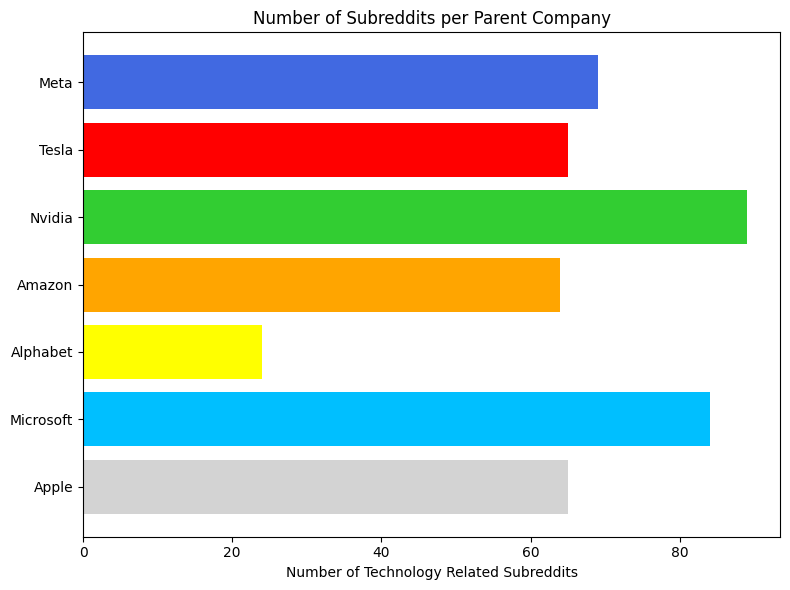

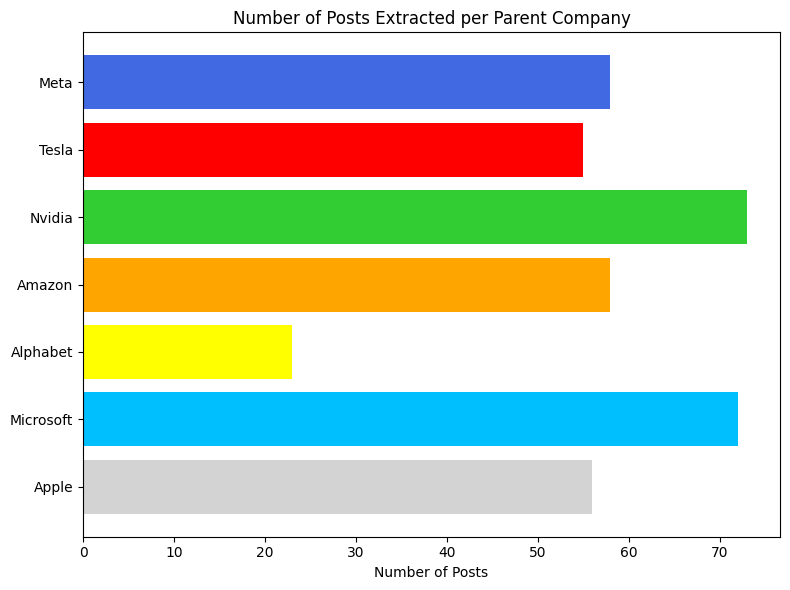

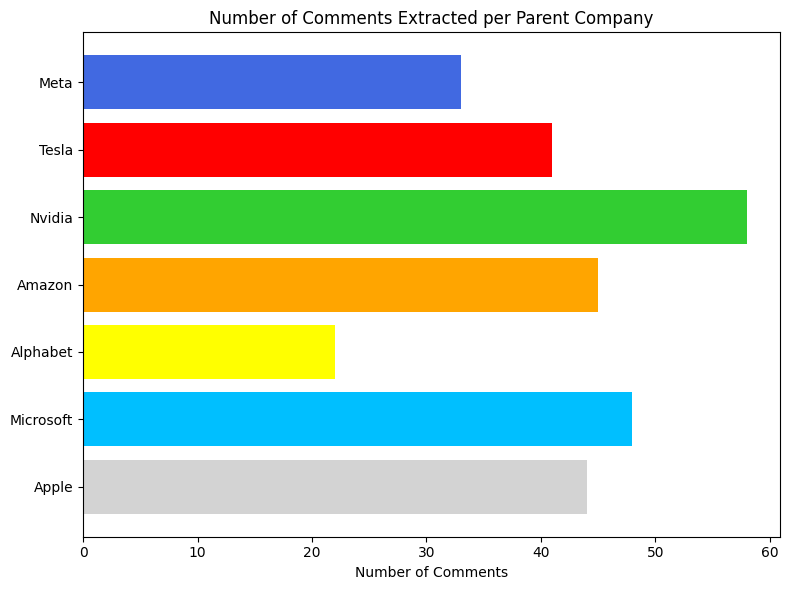

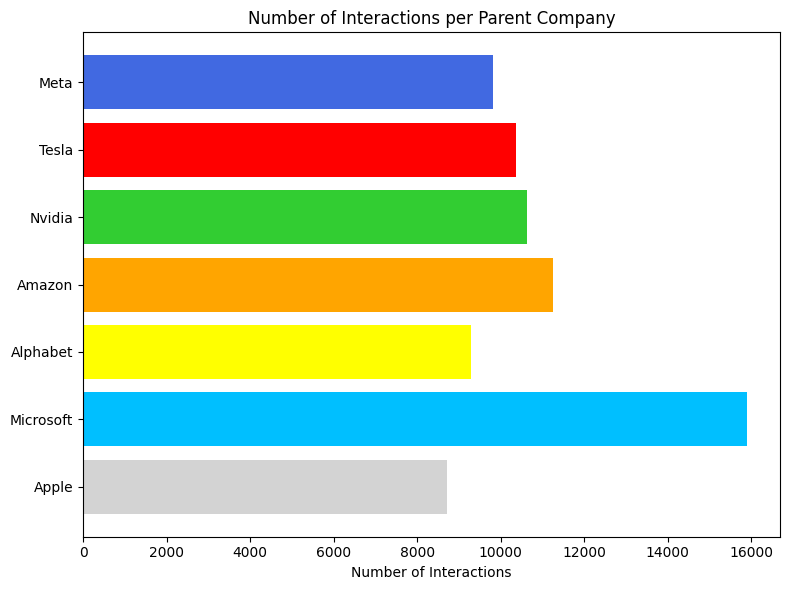

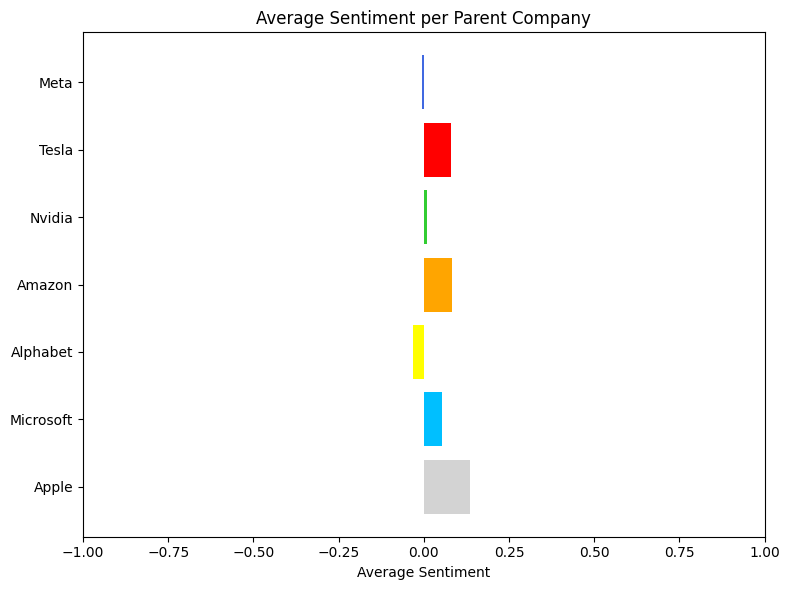

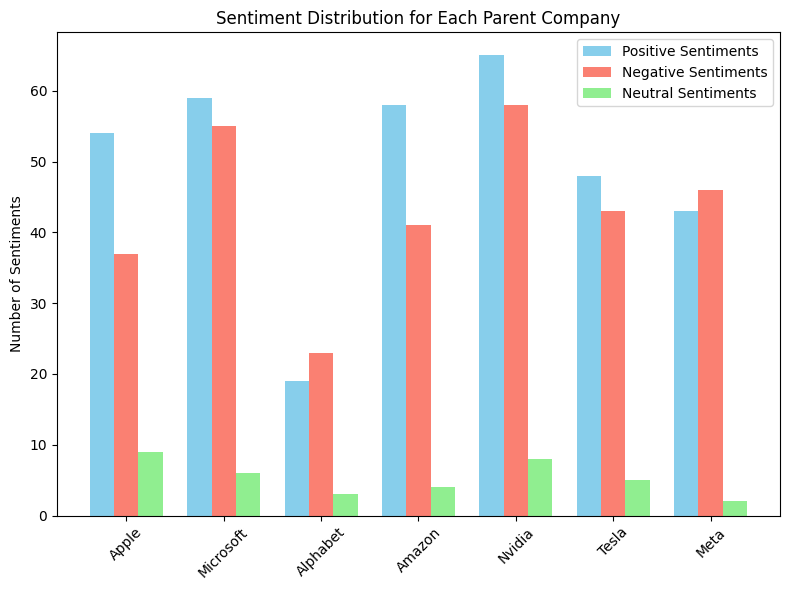

In [136]:
def plot_results(results):
  color_map = {
      'Apple': 'lightgray',
      'Microsoft': 'deepskyblue',
      'Alphabet': 'yellow',
      'Amazon': 'orange',
      'Nvidia': 'limegreen',
      'Tesla': 'red',
      'Meta': 'royalblue'
  }
  fig, axs = plt.subplots(figsize=(8, 6))
  for company, num_subs in results["Num subreddits that were included per parent company"].items():
    plt.barh(company, num_subs, color=color_map.get(company, 'gray'))
  axs.set_title('Number of Subreddits per Parent Company')
  axs.set_xlabel('Number of Technology Related Subreddits')
  plt.tight_layout()
  plt.savefig("results_num_subs.png")

  fig, axs = plt.subplots(figsize=(8, 6))
  for company, num_posts in results["Num of posts extracted for each parent company"].items():
    axs.barh(company, num_posts, color=color_map.get(company, 'gray'))
  axs.set_title('Number of Posts Extracted per Parent Company')
  axs.set_xlabel('Number of Posts')
  plt.tight_layout()
  plt.savefig("results_num_posts.png")

  fig, axs = plt.subplots(figsize=(8, 6))
  for company, num_comments in results["Num of comments extracted for each parent company"].items():
    axs.barh(company, num_comments, color=color_map.get(company, 'gray'))
  axs.set_title('Number of Comments Extracted per Parent Company')
  axs.set_xlabel('Number of Comments')
  plt.tight_layout()
  plt.savefig("results_num_comments.png")

  fig, axs = plt.subplots(figsize=(8, 6))
  for company, num_interactions in results["Num of interactions for each parent company"].items():
    axs.barh(company, num_interactions, color=color_map.get(company, 'gray'))
  axs.set_title('Number of Interactions per Parent Company')
  axs.set_xlabel('Number of Interactions')
  plt.tight_layout()
  plt.savefig("results_num_interactions.png")

  fig, axs = plt.subplots(figsize=(8, 6))
  for company, num_interactions in results["Average sentiment for each parent company"].items():
    axs.barh(company, num_interactions, color=color_map.get(company, 'gray'))
  axs.set_title('Average Sentiment per Parent Company')
  axs.set_xlabel('Average Sentiment')
  axs.set_xlim(-1, 1)  # Set the x-axis limits to range from -1 to 1
  plt.tight_layout()
  plt.savefig("results_average_sentiment.png")

  fig, axs = plt.subplots(figsize=(8, 6))
  bar_width = 0.25
  index = np.arange(7)

  companies = list(results["Num of positive sentiments for each parent company"].keys())
  positive_sentiments = [results["Num of positive sentiments for each parent company"][company] for company in companies]
  negative_sentiments = [results["Num of negative sentiments for each parent company"][company] for company in companies]
  neutral_sentiments = [results["Num of neutral sentiments for each parent company"][company] for company in companies]

  axs.bar(index, positive_sentiments, bar_width, label='Positive Sentiments', color='skyblue')
  axs.bar(index + bar_width, negative_sentiments, bar_width, label='Negative Sentiments', color='salmon')
  axs.bar(index + 2 * bar_width, neutral_sentiments, bar_width, label='Neutral Sentiments', color='lightgreen')

  axs.set_ylabel('Number of Sentiments')
  axs.set_title('Sentiment Distribution for Each Parent Company')
  axs.set_xticks(index + bar_width)
  axs.set_xticklabels(companies, rotation=45)
  axs.legend()
  plt.tight_layout()
  plt.savefig("results_sentiment_distribution.png")

def plot():
  return ["results_num_subs.png", "results_num_posts.png", "results_num_comments.png", "results_num_interactions.png", "results_average_sentiment.png", "results_sentiment_distribution.png"]

def launch_gradio_app():
  # gradio app launch
  title = "Reddit Sentiment Analysis"
  description = ""
  article = "Read more at: "

  demo = gr.Interface(plot,
                      inputs=None,
                      outputs=[gr.Gallery(label="Today", columns=[3,2])],
                      title=title,
                      description=description,
                      article=article)
  demo.launch()

if __name__ == "__main__":
  from datetime import datetime, timedelta
  # load results dataset from hugging face
  reddit_sentiment_analysis_results = load_dataset("gulnuravci/reddit_sentiment_analysis_results", split="train")

  # return latest results
  latest_results = reddit_sentiment_analysis_results[-1]

  # convert string datetime to datetime object
  latest_results_datetime = datetime.strptime(reddit_sentiment_analysis_results[-1]['Datetime'], "%Y-%m-%d %H:%M:%S")

  # get current time
  current_datetime = datetime.now()

  # calculate the time difference between the current datetime and the datetime of the last entry
  time_difference = current_datetime - latest_results_datetime

  # check if the time difference is greater than 24 hours
  if time_difference < timedelta(hours=24):
    results = results_str_to_dict(latest_results)
  else:
    # get results for today
    # async_results, post_comments = await main_async()
    # todays_results = main(async_results, post_comments)
    # todays_results = main()
    # add datetime to results
    todays_results["Datetime"] = current_datetime.strftime("%Y-%m-%d %H:%M:%S")
    # convert non string values to string
    todays_results = {key: str(value) for key, value in todays_results.items()}
    # add results to dataset
    reddit_sentiment_analysis_results = reddit_sentiment_analysis_results.add_item(todays_results)
    # get write permission to hugging face
    get_write_access_to_hf()
    # push to hugging face
    reddit_sentiment_analysis_results.push_to_hub("gulnuravci/reddit_sentiment_analysis_results")
    # convert string results to dict
    results = results_str_to_dict(todays_results)

plot_results(results)
launch_gradio_app()

In [123]:
reddit_sentiment_analysis_results = load_dataset("gulnuravci/reddit_sentiment_analysis_results", split="train")
latest_results = reddit_sentiment_analysis_results[-1]
latest_results = {key: str(value) for key, value in latest_results.items()}
latest_results

{'Datetime': '2024-05-10 04:36:18',
 'Num subreddits with subsidiary/parent company name in its name or description': '1253',
 'Num subreddits after using keywords filter': '653',
 'Num old subreddits that were automatically included': '385',
 'Num subreddits that ran through the model': '248',
 'Total subreddits that are technology related (including old and new subreddits)': '460',
 'Num subreddits that were included per parent company': "{'Apple': 65, 'Microsoft': 84, 'Alphabet': 24, 'Amazon': 64, 'Nvidia': 89, 'Tesla': 65, 'Meta': 69}",
 'Failed subreddits while extracting posts': "defaultdict(<class 'list'>, {'Apple': ['apple_news', 'AppleWatchApps', 'AppleWatches', 'AppleIPTV'], 'Microsoft': ['Microsoft_Build', 'MicrosoftInsiders'], 'Alphabet': ['TechNewsToday'], 'Amazon': ['AmazonTopRated', 'AmazonWebServices'], 'Nvidia': ['realNvidia', 'nvidiashieldtv', 'Shadowplay', 'baos', 'orderof10', 'GauGAN', 'n_switch'], 'Tesla': ['TeslaMasterrace'], 'Meta': ['Oculus_Quill', 'OculusMods',

In [130]:
import ast
def results_str_to_dict(input_results):
  for key, value in input_results.items():
    if not value.isdigit() and "{" in value:
      start_index = value.find("{")
      end_index = value.find("}")
      substring = value[start_index:end_index+1]
      converted_value = ast.literal_eval(substring)
      # print("substring:", substring)
      # print("type(converted_value):", type(converted_value))
      input_results[key] = converted_value
    elif value.isdigit():
      input_results[key] = int(value)
  return input_results

In [119]:
import ast
type(ast.literal_eval("{'Apple': 56, 'Microsoft': 72, 'Alphabet': 23, 'Amazon': 58, 'Nvidia': 73, 'Tesla': 55, 'Meta': 58}"))

dict

In [129]:
bla = results_str_to_dict(latest_results)
bla

substring: {'Apple': 65, 'Microsoft': 84, 'Alphabet': 24, 'Amazon': 64, 'Nvidia': 89, 'Tesla': 65, 'Meta': 69}
type(converted_value): <class 'dict'>
substring: {'Apple': ['apple_news', 'AppleWatchApps', 'AppleWatches', 'AppleIPTV'], 'Microsoft': ['Microsoft_Build', 'MicrosoftInsiders'], 'Alphabet': ['TechNewsToday'], 'Amazon': ['AmazonTopRated', 'AmazonWebServices'], 'Nvidia': ['realNvidia', 'nvidiashieldtv', 'Shadowplay', 'baos', 'orderof10', 'GauGAN', 'n_switch'], 'Tesla': ['TeslaMasterrace'], 'Meta': ['Oculus_Quill', 'OculusMods', 'OculusNames', 'vive_vr', 'OculusQuest_Sverige', 'OculusQuestGerman']}
type(converted_value): <class 'dict'>
substring: {'Apple': 44, 'Microsoft': 48, 'Alphabet': 22, 'Amazon': 45, 'Nvidia': 58, 'Tesla': 41, 'Meta': 33}
type(converted_value): <class 'dict'>
substring: {'Apple': 8712.700000000004, 'Microsoft': 15893.140000000001, 'Alphabet': 9284.239999999998, 'Amazon': 11240.63, 'Nvidia': 10632.239999999998, 'Tesla': 10367.370000000003, 'Meta': 9826.660000

{'Datetime': '2024-05-10 04:36:18',
 'Num subreddits with subsidiary/parent company name in its name or description': 1253,
 'Num subreddits after using keywords filter': 653,
 'Num old subreddits that were automatically included': 385,
 'Num subreddits that ran through the model': 248,
 'Total subreddits that are technology related (including old and new subreddits)': 460,
 'Num subreddits that were included per parent company': {'Apple': 65,
  'Microsoft': 84,
  'Alphabet': 24,
  'Amazon': 64,
  'Nvidia': 89,
  'Tesla': 65,
  'Meta': 69},
 'Failed subreddits while extracting posts': {'Apple': ['apple_news',
   'AppleWatchApps',
   'AppleWatches',
   'AppleIPTV'],
  'Microsoft': ['Microsoft_Build', 'MicrosoftInsiders'],
  'Alphabet': ['TechNewsToday'],
  'Amazon': ['AmazonTopRated', 'AmazonWebServices'],
  'Nvidia': ['realNvidia',
   'nvidiashieldtv',
   'Shadowplay',
   'baos',
   'orderof10',
   'GauGAN',
   'n_switch'],
  'Tesla': ['TeslaMasterrace'],
  'Meta': ['Oculus_Quill',
   

In [110]:
for key, value in bla.items():
  print(key, type(value))

Datetime <class 'str'>
Num subreddits with subsidiary/parent company name in its name or description <class 'int'>
Num subreddits after using keywords filter <class 'int'>
Num old subreddits that were automatically included <class 'int'>
Num subreddits that ran through the model <class 'int'>
Total subreddits that are technology related (including old and new subreddits) <class 'int'>
Num subreddits that were included per parent company <class 'str'>
Failed subreddits while extracting posts <class 'str'>
Num of comments extracted for each parent company <class 'str'>
Num of interactions for each parent company <class 'str'>
Num of neutral sentiments for each parent company <class 'str'>
Num of positive sentiments for each parent company <class 'str'>
Num of negative sentiments for each parent company <class 'str'>
Average sentiment for each parent company <class 'str'>
Num of posts extracted for each parent company <class 'str'>


In [17]:
todays_results_copy = todays_results.copy()

In [72]:
  reddit_sentiment_analysis_results = load_dataset("gulnuravci/reddit_sentiment_analysis_results", split="train[2:]")


In [31]:
from datasets import Value
reddit_sentiment_analysis_results.features

{'Datetime': Value(dtype='string', id=None),
 'Num subreddits with subsidiary/parent company name in its name or description': Value(dtype='int64', id=None),
 'Num subreddits after using keywords filter': Value(dtype='int64', id=None),
 'Num old subreddits that were automatically included': Value(dtype='int64', id=None),
 'Num subreddits that ran through the model': Value(dtype='int64', id=None),
 'Total subreddits that are technology related (including old and new subreddits)': Value(dtype='int64', id=None),
 'Num subreddits that were included per parent company': Value(dtype='int64', id=None),
 'Num of posts extracted for each parent company\n\n': Value(dtype='int64', id=None),
 'Failed subreddits while extracting posts': Value(dtype='int64', id=None),
 'Num of comments extracted for each parent company': Value(dtype='int64', id=None),
 'Num of interactions for each parent company': Value(dtype='int64', id=None),
 'Num of neutral sentiments for each parent company': Value(dtype='int6

In [49]:
from datasets import Value
new_features = reddit_sentiment_analysis_results.features.copy()

In [50]:
new_features["Num subreddits with subsidiary/parent company name in its name or description"] = Value("int64")
new_features["Num subreddits after using keywords filter"] = Value("int64")
new_features["Num old subreddits that were automatically included"] = Value("int64")
new_features["Num subreddits that ran through the model"] = Value("int64")
new_features["Total subreddits that are technology related (including old and new subreddits)"] = Value("int64")

In [51]:
reddit_sentiment_analysis_results = reddit_sentiment_analysis_results.cast(new_features)

Casting the dataset:   0%|          | 0/4 [00:00<?, ? examples/s]

In [58]:
reddit_sentiment_analysis_results = reddit_sentiment_analysis_results.remove_columns("Num of posts extracted for each parent company\n\n")

In [67]:
reddit_sentiment_analysis_results = reddit_sentiment_analysis_results.add_item({key: str(value) for key, value in todays_results.items()})

In [73]:
get_write_access_to_hf()
reddit_sentiment_analysis_results.push_to_hub("gulnuravci/reddit_sentiment_analysis_results", split="train")

The token has not been saved to the git credentials helper. Pass `add_to_git_credential=True` in this function directly or `--add-to-git-credential` if using via `huggingface-cli` if you want to set the git credential as well.
Token is valid (permission: write).
Your token has been saved to /root/.cache/huggingface/token
Login successful


Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

README.md:   0%|          | 0.00/1.44k [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/datasets/gulnuravci/reddit_sentiment_analysis_results/commit/c80775ef0ee47fe229ab24f5413ab65f347e651d', commit_message='Upload dataset', commit_description='', oid='c80775ef0ee47fe229ab24f5413ab65f347e651d', pr_url=None, pr_revision=None, pr_num=None)

In [16]:
todays_results

{'Num subreddits with subsidiary/parent company name in its name or description': 1253,
 'Num subreddits after using keywords filter': 653,
 'Num old subreddits that were automatically included': 385,
 'Num subreddits that ran through the model': 248,
 'Total subreddits that are technology related (including old and new subreddits)': 460,
 'Num subreddits that were included per parent company': {'Apple': 65,
  'Microsoft': 84,
  'Alphabet': 24,
  'Amazon': 64,
  'Nvidia': 89,
  'Tesla': 65,
  'Meta': 69},
 'Num of posts extracted for each parent company': {'Apple': 56,
  'Microsoft': 72,
  'Alphabet': 23,
  'Amazon': 58,
  'Nvidia': 73,
  'Tesla': 55,
  'Meta': 58},
 'Failed subreddits while extracting posts': defaultdict(list,
             {'Apple': ['apple_news',
               'AppleWatchApps',
               'AppleWatches',
               'AppleIPTV'],
              'Microsoft': ['Microsoft_Build', 'MicrosoftInsiders'],
              'Alphabet': ['TechNewsToday'],
              'Am

In [5]:
from google.colab import userdata